#### !pip install git+https://github.com/KindXiaoming/pykan.git

In [2]:
!pip install torch matplotlib

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^


In [6]:
pip install scikit-learn==1.3.2

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
moabb 1.1.1 requires scikit-learn>=1.4.2, but you have scikit-learn 1.3.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import matplotlib.pyplot as plt
from kan import *

In [4]:
!pip install mne
import mne

Defaulting to user installation because normal site-packages is not writeable
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^


In [5]:
!pip install moabb

Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
    sys-platform (=="darwin") ; extra == 'objc'
                 ~^
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [9]:
import warnings
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery
from mne import Epochs, pick_types, events_from_annotations
from kan import *
from kan import KAN
from kan import LBFGS
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
import time
import json

# # Set parameters
# epochs = 40        # Increased number of epochs
# batch = 32            # Increased batch size
# lr = 0.01             # Reduced learning rate for stability
# loss_fn = CrossEntropyLoss()
# steps = 20
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# le = LabelEncoder()
# hidden_layers = 8     # Adjusted hidden layer count based on performance

# Set parameters
epochs = 20        # Increased number of epochs
batch = 16           # Increased batch size
lr = 0.1             # Reduced learning rate for stability
loss_fn = CrossEntropyLoss()
steps = 50
kf = KFold(n_splits=10, shuffle=True, random_state=42)
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
le = LabelEncoder()
hidden_layers = 15     # Adjusted hidden layer count based on performance

# Regularization parameters
lamb = 0.005
lamb_l1 = 0.1
lamb_entropy = 0.5

moabb.set_log_level("info")
warnings.filterwarnings("ignore")
csp = CSP(n_components=4, reg='oas')

# Device configuration
device = torch.device('cpu')  # Adjust for GPU if available: 'cuda' if torch.cuda.is_available() else 'cpu'

def data_EEG(subjects, train=True, multiclass=True):
        # Function to load EEG data based on parameters
        if train:
            session_name = "0train"
        else:
            session_name = "1test"

        dataset = BNCI2014_001()

        if multiclass:
            event_id = dict(left=1, right=2, feet=3, tongue=4)
        else:
            event_id = dict(left=1, right=2)

        tmin, tmax = -1., 6.
        runs = range(5)

        epochs_data = []
        for subject in subjects:
            sessions = dataset.get_data(subjects=[subject])
            for run in runs:
                raw = sessions[subject][session_name][str(run)]
                events = mne.find_events(raw, stim_channel="stim")
                picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
                raw.filter(7., 35., method='iir', picks=picks)

                epochs = Epochs(raw,
                                events,
                                event_id,
                                tmin,
                                tmax,
                                proj=True,
                                picks=picks,
                                baseline=None,
                                preload=True,
                                verbose=False)
                epochs_data.append(epochs)
        return epochs_data

def export_json(data, filename):
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            data[key] = value.tolist()
        elif isinstance(value, list) and all(isinstance(x, list) for x in value):
            data[key] = [[float(item) for item in sublist] for sublist in value]
        elif isinstance(value, list):
            data[key] = [float(item) for item in value]

    with open(filename, "w") as outfile:
        json.dump(data, outfile, indent=4)

# KANModel class with dynamic grid optimization
class KANModel(Module):
    def __init__(self, input_shape, output_shape, grid=5, k=3, device='cpu'):  # Increased grid size to 5
        super(KANModel, self).__init__()
        self.layer = Linear(input_shape, output_shape)
        self.grid = grid
        self.k = k
        self.device = device

        # Ensure all parameters are in double precision
        for param in self.layer.parameters():
            param.data = param.data.double()

    def forward(self, x):
        return self.layer(x)

    def update_grid_size(self, new_grid_size):
        self.grid = new_grid_size
        
    def initialize_from_another_model(self, other_model, train_input):
        with torch.no_grad():
            if hasattr(other_model, 'layer') and hasattr(self, 'layer'):
                if self.layer.weight.shape == other_model.layer.weight.shape:
                    self.layer.weight.copy_(other_model.layer.weight)
                if self.layer.bias.shape == other_model.layer.bias.shape:
                    self.layer.bias.copy_(other_model.layer.bias)
        return self



    def train_model(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0.01, lamb_l1=0.5, lamb_entropy=1.5,
                    update_grid=True, grid_update_num=10, stop_grid_update_step=50, batch=-1, loss_fn=None,
                    lr=1, plateau_threshold=1e-4, max_grid_size=50, small_mag_threshold=1e-16,
                    small_reg_factor=1., sglr_avoid=False):

        pbar = tqdm(range(steps), desc='Training KAN', ncols=100)

        current_grid_size = self.grid
        best_acc = 0.0
        best_grid_size = current_grid_size

        if loss_fn is None:
            loss_fn = lambda x, y: torch.mean((x - y) ** 2)
        acc = lambda x, y: torch.mean((torch.argmax(x, dim=1) == y).float())

        optimizer = optim.Adam(self.parameters(), lr=lr) if opt == "Adam" else LBFGS(
            self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe")

        results = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
        batch_size = dataset['train_input'].shape[0] if batch == -1 or batch > dataset['train_input'].shape[0] else batch

        train_acc = torch.tensor(0.0)  # Initialize to avoid NameError

        for step in pbar:
            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size, replace=True)

            def closure():
                optimizer.zero_grad()
                pred = self.forward(dataset['train_input'][train_id].to(self.device))
                if sglr_avoid:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(self.device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(self.device))
                nonlocal train_acc  # Needed to modify outer variable
                train_acc = acc(pred, dataset['train_label'][train_id].to(self.device))
                objective = train_loss + lamb
                objective.backward()
                return objective

            if opt == "LBFGS":
                optimizer.step(closure)
            else:
                pred = self.forward(dataset['train_input'][train_id].to(self.device))
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(self.device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_acc = acc(pred, dataset['train_label'][train_id].to(self.device))

            test_loss = loss_fn(self.forward(dataset['test_input'][test_id].to(self.device)), dataset['test_label'][test_id].to(self.device))
            test_acc = acc(self.forward(dataset['test_input'][test_id].to(self.device)), dataset['test_label'][test_id].to(self.device))

            if step % log == 0:
                pbar.set_description(f"train acc: {train_acc:.3f} | test acc: {test_acc:.3f}")

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

            if test_acc > best_acc:
                best_acc = test_acc
                best_grid_size = current_grid_size

            if update_grid and step % grid_update_num == 0 and step < stop_grid_update_step:
                if len(results['train_acc']) > 2:
                    acc_diff = abs(results['train_acc'][-1] - results['train_acc'][-2])
                    if acc_diff < plateau_threshold and current_grid_size < max_grid_size:
                        current_grid_size += 1
                        self.update_grid_size(current_grid_size)
                        pbar.set_postfix({'grid_size': current_grid_size})

        self.update_grid_size(best_grid_size)
        print(f"Reverting to best grid size: {best_grid_size} with accuracy: {best_acc:.3f}")

        return results


class MLP(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(input_dim, hidden_dim),
            ReLU(),  # Activation function (you can experiment with others)
            Linear(hidden_dim, output_dim)  # Output layer
        )

    def forward(self, x):
        return self.layers(x)
    
    def initialize_from_another_model(self, model, data):
        """ Initialize the current model from another model using the data provided """
        # Assuming we are initializing the weights from another model
        self.kan.initialize_from(model.kan)
        return self
    

    def train(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, batch=-1,
              small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', device='cpu'):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            device : str
                device
            save_fig_freq : int
                save figure every (save_fig_freq) step

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization

        Example
        -------
        >>> # for interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.plot()
        '''


        pbar = tqdm(range(steps), desc='description', ncols=100)

        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        acc = acc_eval = lambda x,y: torch.mean((torch.argmax(x, dim=1) == y).float())

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['train_acc'] = []
        results['test_acc'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, train_acc

        def closure():
            global train_loss, train_acc
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id].to(device))
            if sglr_avoid == True:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
            train_acc = acc(pred, dataset['train_label'][train_id].to(device))

            objective = train_loss + lamb
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)

        for _ in pbar:

            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            #if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
            #    self.update_grid_from_samples(dataset['train_input'][train_id].to(device))

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id].to(device))
                if sglr_avoid == True:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))
            test_acc = acc_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

            if _ % log == 0:
                pbar.set_description("train acc: %.3f | test acc: %.3f " % ((train_acc).cpu().detach().numpy(), (test_acc).cpu().detach().numpy()))

            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()

        return results

/usr/lib/python3/dist-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/usr/lib/python3/dist-packages/paramiko/transport.py:237: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 45.0.0.
  "class": algorithms.Blowfish,
/usr/lib/python3/dist-packages/paramiko/transport.py:261: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [19]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 1 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.523: 100%|█████████████| 50/50 [00:00<00:00, 380.09it/s, grid_size=6]


Reverting to best grid size: 6 with accuracy: 0.616


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.05it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.583: 100%|█████████████| 50/50 [00:00<00:00, 395.59it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.639


train acc: 0.769 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.11it/s]


###### EPOCH 2 ######


train acc: 0.634 | test acc: 0.556: 100%|█████████████| 50/50 [00:00<00:00, 390.69it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.671


train acc: 0.764 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.95it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.606: 100%|█████████████| 50/50 [00:00<00:00, 392.59it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.644


train acc: 0.769 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.74it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.671: 100%|█████████████| 50/50 [00:00<00:00, 391.67it/s, grid_size=9]


Reverting to best grid size: 9 with accuracy: 0.671


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.29it/s]


###### EPOCH 5 ######


train acc: 0.639 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 391.97it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.662


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.45it/s]


###### EPOCH 6 ######


train acc: 0.639 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 390.38it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.671


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.19it/s]


###### EPOCH 7 ######


train acc: 0.639 | test acc: 0.606: 100%|████████████| 50/50 [00:00<00:00, 395.46it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.662


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.89it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.616: 100%|████████████| 50/50 [00:00<00:00, 391.28it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.644


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.47it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 395.03it/s, grid_size=10]


Reverting to best grid size: 9 with accuracy: 0.671


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.27it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 396.87it/s, grid_size=10]


Reverting to best grid size: 10 with accuracy: 0.662


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.51it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 392.34it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.662


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.32it/s]


###### EPOCH 12 ######


train acc: 0.639 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 389.66it/s, grid_size=12]


Reverting to best grid size: 11 with accuracy: 0.634


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.65it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.519: 100%|████████████| 50/50 [00:00<00:00, 405.78it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.653


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.85it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 404.86it/s, grid_size=14]


Reverting to best grid size: 14 with accuracy: 0.662


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.87it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 399.60it/s, grid_size=16]


Reverting to best grid size: 16 with accuracy: 0.657


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.87it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.542: 100%|████████████| 50/50 [00:00<00:00, 408.00it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.644


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.59it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 400.82it/s, grid_size=19]


Reverting to best grid size: 19 with accuracy: 0.620


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.46it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 405.62it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.648


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.21it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 388.66it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.667


train acc: 0.773 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.89it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 390.65it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.736


train acc: 0.727 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.00it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.713: 100%|████████████| 50/50 [00:00<00:00, 396.81it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.727


train acc: 0.741 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.69it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 389.39it/s, grid_size=25]


Reverting to best grid size: 25 with accuracy: 0.736


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.02it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 387.82it/s, grid_size=26]


Reverting to best grid size: 26 with accuracy: 0.731


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.23it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.60it/s]


Reverting to best grid size: 26 with accuracy: 0.718


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.77it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 344.62it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.722


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.89it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 391.29it/s, grid_size=28]


Reverting to best grid size: 27 with accuracy: 0.773


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.88it/s]


###### EPOCH 7 ######


train acc: 0.625 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 387.62it/s, grid_size=28]


Reverting to best grid size: 28 with accuracy: 0.745


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.54it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 389.98it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.727


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.17it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 393.14it/s, grid_size=30]


Reverting to best grid size: 29 with accuracy: 0.745


train acc: 0.769 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.03it/s]


###### EPOCH 10 ######


train acc: 0.630 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 383.58it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.718


train acc: 0.769 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.97it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 394.28it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.731


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.17it/s]


###### EPOCH 12 ######


train acc: 0.630 | test acc: 0.722: 100%|████████████| 50/50 [00:00<00:00, 379.68it/s, grid_size=34]


Reverting to best grid size: 32 with accuracy: 0.722


train acc: 0.773 | test acc: 0.458 : 100%|█████████████████████████| 50/50 [00:00<00:00, 107.53it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 389.42it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.750


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.72it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.736: 100%|████████████| 50/50 [00:00<00:00, 384.43it/s, grid_size=35]


Reverting to best grid size: 35 with accuracy: 0.736


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.77it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 395.04it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.741


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.19it/s]


###### EPOCH 16 ######


train acc: 0.630 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 389.92it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.773


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.13it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 394.93it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.736


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.54it/s]


###### EPOCH 18 ######


train acc: 0.630 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 405.72it/s, grid_size=39]


Reverting to best grid size: 39 with accuracy: 0.722


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.56it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.39it/s]


Reverting to best grid size: 39 with accuracy: 0.764


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.50it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.463: 100%|████████████| 50/50 [00:00<00:00, 393.51it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.569


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.40it/s]


###### EPOCH 1 ######


train acc: 0.644 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.65it/s]


Reverting to best grid size: 39 with accuracy: 0.583


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.15it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.509: 100%|████████████| 50/50 [00:00<00:00, 394.35it/s, grid_size=40]


Reverting to best grid size: 40 with accuracy: 0.611


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.98it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.47it/s]


Reverting to best grid size: 40 with accuracy: 0.662


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.67it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.34it/s]


Reverting to best grid size: 40 with accuracy: 0.588


train acc: 0.764 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.11it/s]


###### EPOCH 5 ######


train acc: 0.634 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 384.68it/s, grid_size=42]


Reverting to best grid size: 40 with accuracy: 0.606


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.72it/s]


###### EPOCH 6 ######


train acc: 0.639 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 386.07it/s, grid_size=42]


Reverting to best grid size: 42 with accuracy: 0.593


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.61it/s]


###### EPOCH 7 ######


train acc: 0.639 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 392.38it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.606


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.10it/s]


###### EPOCH 8 ######


train acc: 0.639 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.30it/s]


Reverting to best grid size: 43 with accuracy: 0.606


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.84it/s]


###### EPOCH 9 ######


train acc: 0.648 | test acc: 0.477: 100%|████████████| 50/50 [00:00<00:00, 383.43it/s, grid_size=46]


Reverting to best grid size: 43 with accuracy: 0.593


train acc: 0.759 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 107.73it/s]


###### EPOCH 10 ######


train acc: 0.648 | test acc: 0.491: 100%|████████████| 50/50 [00:00<00:00, 390.27it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.583


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.85it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 390.10it/s, grid_size=44]


Reverting to best grid size: 44 with accuracy: 0.574


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.24it/s]


###### EPOCH 12 ######


train acc: 0.648 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 339.93it/s, grid_size=46]


Reverting to best grid size: 44 with accuracy: 0.574


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.38it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.505: 100%|████████████| 50/50 [00:00<00:00, 354.71it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.616


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.31it/s]


###### EPOCH 14 ######


train acc: 0.648 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 347.49it/s, grid_size=48]


Reverting to best grid size: 45 with accuracy: 0.588


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.41it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 407.48it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.565


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.60it/s]


###### EPOCH 16 ######


train acc: 0.648 | test acc: 0.500: 100%|████████████| 50/50 [00:00<00:00, 365.70it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.588


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.69it/s]


###### EPOCH 17 ######


train acc: 0.644 | test acc: 0.463: 100%|████████████| 50/50 [00:00<00:00, 397.10it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.583


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.83it/s]


###### EPOCH 18 ######


train acc: 0.648 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 397.82it/s, grid_size=49]


Reverting to best grid size: 48 with accuracy: 0.569


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.75it/s]


###### EPOCH 19 ######


train acc: 0.648 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 395.68it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.560


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.79it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.96it/s]


Reverting to best grid size: 49 with accuracy: 0.745


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.89it/s]


###### EPOCH 1 ######


train acc: 0.653 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 398.27it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.736


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.58it/s]


###### EPOCH 2 ######


train acc: 0.648 | test acc: 0.708: 100%|████████████| 50/50 [00:00<00:00, 399.59it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.731 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.63it/s]


###### EPOCH 3 ######


train acc: 0.644 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.55it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.736 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.17it/s]


###### EPOCH 4 ######


train acc: 0.648 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.23it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.45it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.46it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.36it/s]


###### EPOCH 6 ######


train acc: 0.648 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.75it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.51it/s]


###### EPOCH 7 ######


train acc: 0.653 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.59it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.70it/s]


###### EPOCH 8 ######


train acc: 0.648 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.20it/s]


Reverting to best grid size: 50 with accuracy: 0.847


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.41it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.24it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.30it/s]


###### EPOCH 10 ######


train acc: 0.648 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.64it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.31it/s]


###### EPOCH 11 ######


train acc: 0.648 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.47it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.32it/s]


###### EPOCH 12 ######


train acc: 0.653 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.54it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.41it/s]


###### EPOCH 13 ######


train acc: 0.648 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.60it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.44it/s]


###### EPOCH 14 ######


train acc: 0.648 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.13it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.49it/s]


###### EPOCH 15 ######


train acc: 0.648 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.22it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.45it/s]


###### EPOCH 16 ######


train acc: 0.648 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.05it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.43it/s]


###### EPOCH 17 ######


train acc: 0.648 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.69it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.61it/s]


###### EPOCH 18 ######


train acc: 0.644 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.74it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.34it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.86it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.741 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.55it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.09it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.97it/s]


###### EPOCH 1 ######


train acc: 0.639 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.81it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.72it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.15it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.42it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.07it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.37it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.34it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.64it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.94it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.71it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.32it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.69it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.91it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.75it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.83it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.42it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.42it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.759 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 128.06it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.97it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.41it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.89it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.69it/s]


###### EPOCH 12 ######


train acc: 0.634 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.63it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.759 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 193.97it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.68it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 90.38it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.59it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.75it/s]


###### EPOCH 15 ######


train acc: 0.630 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.24it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.38it/s]


###### EPOCH 16 ######


train acc: 0.634 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.81it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.49it/s]


###### EPOCH 17 ######


train acc: 0.630 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 341.29it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.49it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.81it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.19it/s]


###### EPOCH 19 ######


train acc: 0.630 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.81it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.759 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.08it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 379.23it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.755 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.00it/s]


###### EPOCH 1 ######


train acc: 0.639 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.55it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.16it/s]


###### EPOCH 2 ######


train acc: 0.634 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.03it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.82it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.35it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.45it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.76it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.35it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.60it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.27it/s]


###### EPOCH 6 ######


train acc: 0.634 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.38it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.43it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.57it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.83it/s]


###### EPOCH 8 ######


train acc: 0.639 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.39it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.21it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.57it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.745 | test acc: 0.583 : 100%|█████████████████████████| 50/50 [00:00<00:00, 118.97it/s]


###### EPOCH 10 ######


train acc: 0.639 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.70it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.52it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.72it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.41it/s]


###### EPOCH 12 ######


train acc: 0.639 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.59it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.42it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.54it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.22it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.34it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.49it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.37it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.45it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.53it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.47it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.60it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.53it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 383.16it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.44it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.85it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.45it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.620 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.36it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.745 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.85it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.16it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.78it/s]


###### EPOCH 2 ######


train acc: 0.625 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.86it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.45it/s]


###### EPOCH 3 ######


train acc: 0.616 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.92it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.54it/s]


###### EPOCH 4 ######


train acc: 0.611 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 360.83it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.26it/s]


###### EPOCH 5 ######


train acc: 0.616 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.96it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.21it/s]


###### EPOCH 6 ######


train acc: 0.611 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.17it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.39it/s]


###### EPOCH 7 ######


train acc: 0.616 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.99it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.12it/s]


###### EPOCH 8 ######


train acc: 0.611 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.44it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.28it/s]


###### EPOCH 9 ######


train acc: 0.616 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.80it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.28it/s]


###### EPOCH 10 ######


train acc: 0.611 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.24it/s]


Reverting to best grid size: 50 with accuracy: 0.727


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 90.31it/s]


###### EPOCH 11 ######


train acc: 0.616 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.95it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.96it/s]


###### EPOCH 12 ######


train acc: 0.611 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.80it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.94it/s]


###### EPOCH 13 ######


train acc: 0.616 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.98it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.28it/s]


###### EPOCH 14 ######


train acc: 0.616 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.22it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.90it/s]


###### EPOCH 15 ######


train acc: 0.616 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.34it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.34it/s]


###### EPOCH 16 ######


train acc: 0.616 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.19it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.48it/s]


###### EPOCH 17 ######


train acc: 0.616 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.46it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.11it/s]


###### EPOCH 18 ######


train acc: 0.616 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.34it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.09it/s]


###### EPOCH 19 ######


train acc: 0.616 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.23it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.62it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.57it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.99it/s]


###### EPOCH 1 ######


train acc: 0.639 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 364.51it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 2 ######


train acc: 0.639 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.52it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.88it/s]


###### EPOCH 3 ######


train acc: 0.639 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.74it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.77it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.98it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.86it/s]


###### EPOCH 5 ######


train acc: 0.639 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.63it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.95it/s]


###### EPOCH 6 ######


train acc: 0.639 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.10it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.68it/s]


###### EPOCH 7 ######


train acc: 0.639 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.91it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.86it/s]


###### EPOCH 8 ######


train acc: 0.639 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.58it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.98it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.04it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.76it/s]


###### EPOCH 10 ######


train acc: 0.639 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.85it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.02it/s]


###### EPOCH 11 ######


train acc: 0.639 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.88it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.86it/s]


###### EPOCH 12 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.92it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.65it/s]


###### EPOCH 13 ######


train acc: 0.639 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.74it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.81it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.21it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.86it/s]


###### EPOCH 15 ######


train acc: 0.639 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.35it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.97it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.35it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.91it/s]


###### EPOCH 17 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.49it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.83it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.38it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.73it/s]


###### EPOCH 19 ######


train acc: 0.639 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.03it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.87it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.93it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.745 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.90it/s]


###### EPOCH 1 ######


train acc: 0.644 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.12it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.93it/s]


###### EPOCH 2 ######


train acc: 0.639 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.32it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 82.05it/s]


###### EPOCH 3 ######


train acc: 0.644 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.12it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.78it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.77it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.58it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.93it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.14it/s]


###### EPOCH 6 ######


train acc: 0.644 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.01it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.81it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.73it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.20it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.60it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.19it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.96it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.12it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.13it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.20it/s]


###### EPOCH 11 ######


train acc: 0.639 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.46it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.65it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.26it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.29it/s]


###### EPOCH 13 ######


train acc: 0.639 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.76it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.85it/s]


###### EPOCH 14 ######


train acc: 0.644 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.52it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.11it/s]


###### EPOCH 15 ######


train acc: 0.639 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.18it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.07it/s]


###### EPOCH 16 ######


train acc: 0.644 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.13it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.75it/s]


###### EPOCH 17 ######


train acc: 0.639 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.54it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.09it/s]


###### EPOCH 18 ######


train acc: 0.644 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.68it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.10it/s]


###### EPOCH 19 ######


train acc: 0.639 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.23it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.21it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.29it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.58it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.37it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.37it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.801: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.62it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.30it/s]


###### EPOCH 3 ######


train acc: 0.625 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.69it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.32it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.29it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.36it/s]


###### EPOCH 5 ######


train acc: 0.625 | test acc: 0.745: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.47it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.42it/s]


###### EPOCH 6 ######


train acc: 0.620 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.01it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.44it/s]


###### EPOCH 7 ######


train acc: 0.620 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.08it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 8 ######


train acc: 0.620 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.20it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.62it/s]


###### EPOCH 9 ######


train acc: 0.620 | test acc: 0.718: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.12it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.50it/s]


###### EPOCH 10 ######


train acc: 0.620 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.50it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.51it/s]


###### EPOCH 11 ######


train acc: 0.620 | test acc: 0.736: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.39it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.08it/s]


###### EPOCH 12 ######


train acc: 0.620 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.36it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.20it/s]


###### EPOCH 13 ######


train acc: 0.620 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.60it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.33it/s]


###### EPOCH 14 ######


train acc: 0.620 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.22it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.15it/s]


###### EPOCH 15 ######


train acc: 0.620 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.71it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.36it/s]


###### EPOCH 16 ######


train acc: 0.620 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.85it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.42it/s]


###### EPOCH 17 ######


train acc: 0.620 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.23it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.55it/s]


###### EPOCH 18 ######


train acc: 0.625 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.42it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.52it/s]


###### EPOCH 19 ######


train acc: 0.620 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.99it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.722 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.47it/s]

### Subject 1 ###
Training time KAN: 26.12 seconds
Training time MLP: 212.26 seconds
KAN Mean Training Accuracy: 0.6333352327346802
KAN Mean Testing Accuracy: 0.5945101976394653
MLP Mean Training Accuracy: 0.751830518245697
MLP Mean Testing Accuracy: 0.5792083144187927


In [18]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [2]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 2 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.616 | test acc: 0.579: 100%|█████████████| 50/50 [00:00<00:00, 279.69it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.630


train acc: 0.769 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.12it/s]


###### EPOCH 1 ######


train acc: 0.602 | test acc: 0.574: 100%|█████████████| 50/50 [00:00<00:00, 319.05it/s, grid_size=8]


Reverting to best grid size: 6 with accuracy: 0.676


train acc: 0.796 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.15it/s]


###### EPOCH 2 ######


train acc: 0.602 | test acc: 0.602: 100%|█████████████| 50/50 [00:00<00:00, 312.57it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.667


train acc: 0.792 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.73it/s]


###### EPOCH 3 ######


train acc: 0.602 | test acc: 0.597: 100%|█████████████| 50/50 [00:00<00:00, 404.22it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.685


train acc: 0.792 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.90it/s]


###### EPOCH 4 ######


train acc: 0.602 | test acc: 0.565: 100%|█████████████| 50/50 [00:00<00:00, 399.60it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.644


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.84it/s]


###### EPOCH 5 ######


train acc: 0.602 | test acc: 0.500: 100%|█████████████| 50/50 [00:00<00:00, 328.76it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.750


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 6 ######


train acc: 0.602 | test acc: 0.616: 100%|█████████████| 50/50 [00:00<00:00, 389.04it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.639


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 85.01it/s]


###### EPOCH 7 ######


train acc: 0.602 | test acc: 0.542: 100%|████████████| 50/50 [00:00<00:00, 345.36it/s, grid_size=10]


Reverting to best grid size: 8 with accuracy: 0.690


train acc: 0.787 | test acc: 0.333 : 100%|█████████████████████████| 50/50 [00:00<00:00, 174.73it/s]


###### EPOCH 8 ######


train acc: 0.597 | test acc: 0.588: 100%|█████████████| 50/50 [00:00<00:00, 387.05it/s, grid_size=9]


Reverting to best grid size: 8 with accuracy: 0.667


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.49it/s]


###### EPOCH 9 ######


train acc: 0.597 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 401.26it/s, grid_size=10]


Reverting to best grid size: 8 with accuracy: 0.662


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.05it/s]


###### EPOCH 10 ######


train acc: 0.597 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 296.70it/s, grid_size=10]


Reverting to best grid size: 8 with accuracy: 0.681


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.68it/s]


###### EPOCH 11 ######


train acc: 0.597 | test acc: 0.560: 100%|████████████| 50/50 [00:00<00:00, 403.06it/s, grid_size=10]


Reverting to best grid size: 8 with accuracy: 0.708


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.10it/s]


###### EPOCH 12 ######


train acc: 0.597 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 400.99it/s, grid_size=10]


Reverting to best grid size: 10 with accuracy: 0.662


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.35it/s]


###### EPOCH 13 ######


train acc: 0.597 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 345.63it/s, grid_size=12]


Reverting to best grid size: 12 with accuracy: 0.681


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.41it/s]


###### EPOCH 14 ######


train acc: 0.597 | test acc: 0.606: 100%|████████████| 50/50 [00:00<00:00, 371.24it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.662


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.75it/s]


###### EPOCH 15 ######


train acc: 0.597 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 376.26it/s, grid_size=15]


Reverting to best grid size: 15 with accuracy: 0.676


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.57it/s]


###### EPOCH 16 ######


train acc: 0.597 | test acc: 0.537: 100%|████████████| 50/50 [00:00<00:00, 386.80it/s, grid_size=17]


Reverting to best grid size: 15 with accuracy: 0.681


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.35it/s]


###### EPOCH 17 ######


train acc: 0.597 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 379.64it/s, grid_size=17]


Reverting to best grid size: 15 with accuracy: 0.639


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.15it/s]


###### EPOCH 18 ######


train acc: 0.597 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 390.84it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.667


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.82it/s]


###### EPOCH 19 ######


train acc: 0.602 | test acc: 0.542: 100%|████████████| 50/50 [00:00<00:00, 388.20it/s, grid_size=18]


Reverting to best grid size: 15 with accuracy: 0.676


train acc: 0.787 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.05it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.602 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 392.18it/s, grid_size=17]


Reverting to best grid size: 15 with accuracy: 0.736


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.14it/s]


###### EPOCH 1 ######


train acc: 0.597 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 398.20it/s, grid_size=16]


Reverting to best grid size: 16 with accuracy: 0.755


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.61it/s]


###### EPOCH 2 ######


train acc: 0.597 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 424.24it/s]


Reverting to best grid size: 16 with accuracy: 0.722


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.54it/s]


###### EPOCH 3 ######


train acc: 0.593 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 397.71it/s, grid_size=19]


Reverting to best grid size: 18 with accuracy: 0.745


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.17it/s]


###### EPOCH 4 ######


train acc: 0.593 | test acc: 0.597: 100%|████████████| 50/50 [00:00<00:00, 399.63it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.769


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.86it/s]


###### EPOCH 5 ######


train acc: 0.593 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 390.01it/s, grid_size=23]


Reverting to best grid size: 21 with accuracy: 0.741


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.36it/s]


###### EPOCH 6 ######


train acc: 0.593 | test acc: 0.708: 100%|████████████| 50/50 [00:00<00:00, 405.97it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.708


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.06it/s]


###### EPOCH 7 ######


train acc: 0.593 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 396.20it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.727


train acc: 0.759 | test acc: 0.542 : 100%|█████████████████████████| 50/50 [00:00<00:00, 184.81it/s]


###### EPOCH 8 ######


train acc: 0.593 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 405.28it/s, grid_size=25]


Reverting to best grid size: 25 with accuracy: 0.741


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.38it/s]


###### EPOCH 9 ######


train acc: 0.593 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 402.51it/s, grid_size=28]


Reverting to best grid size: 25 with accuracy: 0.731


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.93it/s]


###### EPOCH 10 ######


train acc: 0.593 | test acc: 0.764: 100%|████████████| 50/50 [00:00<00:00, 382.84it/s, grid_size=26]


Reverting to best grid size: 26 with accuracy: 0.764


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.53it/s]


###### EPOCH 11 ######


train acc: 0.593 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 378.71it/s, grid_size=29]


Reverting to best grid size: 27 with accuracy: 0.722


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.11it/s]


###### EPOCH 12 ######


train acc: 0.593 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 371.33it/s, grid_size=28]


Reverting to best grid size: 28 with accuracy: 0.745


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.17it/s]


###### EPOCH 13 ######


train acc: 0.593 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 370.39it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.731


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.14it/s]


###### EPOCH 14 ######


train acc: 0.593 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 397.80it/s, grid_size=31]


Reverting to best grid size: 31 with accuracy: 0.773


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.78it/s]


###### EPOCH 15 ######


train acc: 0.593 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 396.68it/s, grid_size=34]


Reverting to best grid size: 32 with accuracy: 0.731


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.14it/s]


###### EPOCH 16 ######


train acc: 0.593 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 403.76it/s, grid_size=33]


Reverting to best grid size: 33 with accuracy: 0.736


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.73it/s]


###### EPOCH 17 ######


train acc: 0.593 | test acc: 0.699: 100%|████████████| 50/50 [00:00<00:00, 401.95it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.736


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.09it/s]


###### EPOCH 18 ######


train acc: 0.593 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 388.25it/s, grid_size=36]


Reverting to best grid size: 36 with accuracy: 0.764


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.67it/s]


###### EPOCH 19 ######


train acc: 0.593 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 404.52it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.731


train acc: 0.759 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.85it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.602 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 406.80it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.574


train acc: 0.755 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.90it/s]


###### EPOCH 1 ######


train acc: 0.602 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 386.95it/s, grid_size=42]


Reverting to best grid size: 40 with accuracy: 0.574


train acc: 0.764 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.82it/s]


###### EPOCH 2 ######


train acc: 0.602 | test acc: 0.477: 100%|████████████| 50/50 [00:00<00:00, 386.04it/s, grid_size=43]


Reverting to best grid size: 40 with accuracy: 0.606


train acc: 0.764 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.93it/s]


###### EPOCH 3 ######


train acc: 0.597 | test acc: 0.509: 100%|████████████| 50/50 [00:00<00:00, 382.07it/s, grid_size=42]


Reverting to best grid size: 40 with accuracy: 0.616


train acc: 0.769 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.24it/s]


###### EPOCH 4 ######


train acc: 0.611 | test acc: 0.495: 100%|████████████| 50/50 [00:00<00:00, 390.62it/s, grid_size=41]


Reverting to best grid size: 41 with accuracy: 0.565


train acc: 0.773 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.76it/s]


###### EPOCH 5 ######


train acc: 0.602 | test acc: 0.491: 100%|████████████| 50/50 [00:00<00:00, 384.17it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.583


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.17it/s]


###### EPOCH 6 ######


train acc: 0.606 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 387.20it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.588


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.66it/s]


###### EPOCH 7 ######


train acc: 0.602 | test acc: 0.477: 100%|████████████| 50/50 [00:00<00:00, 390.22it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.602


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.17it/s]


###### EPOCH 8 ######


train acc: 0.602 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.60it/s]


Reverting to best grid size: 43 with accuracy: 0.579


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.96it/s]


###### EPOCH 9 ######


train acc: 0.602 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 388.20it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.588


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.78it/s]


###### EPOCH 10 ######


train acc: 0.602 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 386.52it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.606


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.97it/s]


###### EPOCH 11 ######


train acc: 0.597 | test acc: 0.519: 100%|████████████| 50/50 [00:00<00:00, 390.26it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.611


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.96it/s]


###### EPOCH 12 ######


train acc: 0.597 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 387.91it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.606


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.92it/s]


###### EPOCH 13 ######


train acc: 0.597 | test acc: 0.505: 100%|████████████| 50/50 [00:00<00:00, 393.77it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.625


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.00it/s]


###### EPOCH 14 ######


train acc: 0.597 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.18it/s]


Reverting to best grid size: 43 with accuracy: 0.593


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.00it/s]


###### EPOCH 15 ######


train acc: 0.597 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 391.22it/s, grid_size=44]


Reverting to best grid size: 44 with accuracy: 0.620


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.92it/s]


###### EPOCH 16 ######


train acc: 0.597 | test acc: 0.551: 100%|████████████| 50/50 [00:00<00:00, 389.82it/s, grid_size=45]


Reverting to best grid size: 44 with accuracy: 0.602


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.74it/s]


###### EPOCH 17 ######


train acc: 0.597 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 391.50it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.583


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.90it/s]


###### EPOCH 18 ######


train acc: 0.597 | test acc: 0.505: 100%|████████████| 50/50 [00:00<00:00, 392.83it/s, grid_size=46]


Reverting to best grid size: 45 with accuracy: 0.606


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.01it/s]


###### EPOCH 19 ######


train acc: 0.597 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 389.94it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.588


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.00it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.560 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.26it/s]


Reverting to best grid size: 46 with accuracy: 0.727


train acc: 0.750 | test acc: 0.792 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.07it/s]


###### EPOCH 1 ######


train acc: 0.565 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 388.31it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.741


train acc: 0.731 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.02it/s]


###### EPOCH 2 ######


train acc: 0.565 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 392.74it/s, grid_size=49]


Reverting to best grid size: 48 with accuracy: 0.755


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.93it/s]


###### EPOCH 3 ######


train acc: 0.565 | test acc: 0.634: 100%|████████████| 50/50 [00:00<00:00, 388.26it/s, grid_size=50]


Reverting to best grid size: 48 with accuracy: 0.764


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.42it/s]


###### EPOCH 4 ######


train acc: 0.565 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 392.33it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.745


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.53it/s]


###### EPOCH 5 ######


train acc: 0.565 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 389.77it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.745


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.44it/s]


###### EPOCH 6 ######


train acc: 0.565 | test acc: 0.718: 100%|████████████| 50/50 [00:00<00:00, 348.23it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.722


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.42it/s]


###### EPOCH 7 ######


train acc: 0.565 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 388.91it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.731


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.40it/s]


###### EPOCH 8 ######


train acc: 0.565 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 391.26it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.36it/s]


###### EPOCH 9 ######


train acc: 0.565 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.40it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.47it/s]


###### EPOCH 10 ######


train acc: 0.565 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.64it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.95it/s]


###### EPOCH 11 ######


train acc: 0.565 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 378.02it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.96it/s]


###### EPOCH 12 ######


train acc: 0.565 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.79it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.22it/s]


###### EPOCH 13 ######


train acc: 0.565 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.29it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.34it/s]


###### EPOCH 14 ######


train acc: 0.565 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.58it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.49it/s]


###### EPOCH 15 ######


train acc: 0.565 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.47it/s]


Reverting to best grid size: 50 with accuracy: 0.741


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.74it/s]


###### EPOCH 16 ######


train acc: 0.565 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.58it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.45it/s]


###### EPOCH 17 ######


train acc: 0.565 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.26it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.57it/s]


###### EPOCH 18 ######


train acc: 0.565 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.31it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.58it/s]


###### EPOCH 19 ######


train acc: 0.565 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.34it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.736 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.28it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.213: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.62it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.773 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.82it/s]


###### EPOCH 1 ######


train acc: 0.648 | test acc: 0.245: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.22it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.773 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.39it/s]


###### EPOCH 2 ######


train acc: 0.648 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.09it/s]


Reverting to best grid size: 50 with accuracy: 0.301


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.32it/s]


###### EPOCH 3 ######


train acc: 0.653 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.15it/s]


Reverting to best grid size: 50 with accuracy: 0.319


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.35it/s]


###### EPOCH 4 ######


train acc: 0.653 | test acc: 0.227: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.79it/s]


Reverting to best grid size: 50 with accuracy: 0.315


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.81it/s]


###### EPOCH 5 ######


train acc: 0.653 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.26it/s]


Reverting to best grid size: 50 with accuracy: 0.306


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.46it/s]


###### EPOCH 6 ######


train acc: 0.648 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.23it/s]


Reverting to best grid size: 50 with accuracy: 0.343


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.38it/s]


###### EPOCH 7 ######


train acc: 0.653 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.09it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.67it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.44it/s]


Reverting to best grid size: 50 with accuracy: 0.315


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.71it/s]


###### EPOCH 9 ######


train acc: 0.634 | test acc: 0.227: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.97it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.85it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.218: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.92it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.21it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.208: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.06it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.73it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.269: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.80it/s]


Reverting to best grid size: 50 with accuracy: 0.370


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.48it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.190: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.11it/s]


Reverting to best grid size: 50 with accuracy: 0.343


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.85it/s]


###### EPOCH 14 ######


train acc: 0.644 | test acc: 0.222: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.92it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.09it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.190: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.66it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.22it/s]


###### EPOCH 16 ######


train acc: 0.634 | test acc: 0.222: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.61it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.37it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.273: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.60it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.25it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.36it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.07it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.204: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.46it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.778 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.13it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.602 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.21it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.773 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.81it/s]


###### EPOCH 1 ######


train acc: 0.597 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.58it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.769 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.00it/s]


###### EPOCH 2 ######


train acc: 0.602 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.84it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.33it/s]


###### EPOCH 3 ######


train acc: 0.602 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.16it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.08it/s]


###### EPOCH 4 ######


train acc: 0.597 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.49it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.54it/s]


###### EPOCH 5 ######


train acc: 0.597 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.13it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.65it/s]


###### EPOCH 6 ######


train acc: 0.597 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.09it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.50it/s]


###### EPOCH 7 ######


train acc: 0.597 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.07it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.56it/s]


###### EPOCH 8 ######


train acc: 0.588 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.10it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.48it/s]


###### EPOCH 9 ######


train acc: 0.593 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.44it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.49it/s]


###### EPOCH 10 ######


train acc: 0.593 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.57it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.09it/s]


###### EPOCH 11 ######


train acc: 0.593 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.72it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.37it/s]


###### EPOCH 12 ######


train acc: 0.593 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.17it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.40it/s]


###### EPOCH 13 ######


train acc: 0.593 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.05it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.47it/s]


###### EPOCH 14 ######


train acc: 0.593 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.70it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.55it/s]


###### EPOCH 15 ######


train acc: 0.593 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.25it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.36it/s]


###### EPOCH 16 ######


train acc: 0.593 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.53it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.18it/s]


###### EPOCH 17 ######


train acc: 0.593 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.89it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.01it/s]


###### EPOCH 18 ######


train acc: 0.593 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.76it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.41it/s]


###### EPOCH 19 ######


train acc: 0.593 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.50it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.47it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.574 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.56it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.731 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.94it/s]


###### EPOCH 1 ######


train acc: 0.579 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.90it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.727 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.17it/s]


###### EPOCH 2 ######


train acc: 0.569 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.24it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.90it/s]


###### EPOCH 3 ######


train acc: 0.574 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.10it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.37it/s]


###### EPOCH 4 ######


train acc: 0.574 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.79it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.34it/s]


###### EPOCH 5 ######


train acc: 0.579 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.07it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.17it/s]


###### EPOCH 6 ######


train acc: 0.579 | test acc: 0.745: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.54it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.43it/s]


###### EPOCH 7 ######


train acc: 0.579 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.37it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.29it/s]


###### EPOCH 8 ######


train acc: 0.579 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.41it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.41it/s]


###### EPOCH 9 ######


train acc: 0.574 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.22it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.30it/s]


###### EPOCH 10 ######


train acc: 0.574 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.31it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.38it/s]


###### EPOCH 11 ######


train acc: 0.569 | test acc: 0.755: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.90it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.42it/s]


###### EPOCH 12 ######


train acc: 0.569 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.17it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.06it/s]


###### EPOCH 13 ######


train acc: 0.569 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.99it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.71it/s]


###### EPOCH 14 ######


train acc: 0.569 | test acc: 0.736: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.64it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.00it/s]


###### EPOCH 15 ######


train acc: 0.569 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.73it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.22it/s]


###### EPOCH 16 ######


train acc: 0.569 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.37it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.05it/s]


###### EPOCH 17 ######


train acc: 0.569 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.16it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.97it/s]


###### EPOCH 18 ######


train acc: 0.569 | test acc: 0.745: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.62it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.96it/s]


###### EPOCH 19 ######


train acc: 0.569 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.03it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.736 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.14it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.588 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.30it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.97it/s]


###### EPOCH 1 ######


train acc: 0.588 | test acc: 0.801: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.20it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.750 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.34it/s]


###### EPOCH 2 ######


train acc: 0.583 | test acc: 0.727:   0%|                                    | 0/50 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train acc: 0.588 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.77it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.16it/s]


###### EPOCH 11 ######


train acc: 0.593 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.12it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.85it/s]


###### EPOCH 12 ######


train acc: 0.593 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.89it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.759 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 155.93it/s]


###### EPOCH 13 ######


train acc: 0.593 | test acc: 0.745: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.57it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.82it/s]


###### EPOCH 14 ######


train acc: 0.593 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.06it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.03it/s]


###### EPOCH 15 ######


train acc: 0.593 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.60it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.03it/s]


###### EPOCH 16 ######


train acc: 0.593 | test acc: 0.718: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.26it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.77it/s]


###### EPOCH 17 ######


train acc: 0.593 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.21it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.02it/s]


###### EPOCH 18 ######


train acc: 0.593 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.54it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.88it/s]


###### EPOCH 19 ######


train acc: 0.593 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.80it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.78it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.602 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.60it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.764 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.39it/s]


###### EPOCH 1 ######


train acc: 0.611 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 383.25it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.764 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.22it/s]


###### EPOCH 2 ######


train acc: 0.602 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.78it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.79it/s]


###### EPOCH 3 ######


train acc: 0.611 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.93it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.72it/s]


###### EPOCH 4 ######


train acc: 0.597 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.34it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.63it/s]


###### EPOCH 5 ######


train acc: 0.602 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.55it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.81it/s]


###### EPOCH 6 ######


train acc: 0.611 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.82it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.07it/s]


###### EPOCH 7 ######


train acc: 0.611 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.22it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.17it/s]


###### EPOCH 8 ######


train acc: 0.611 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.60it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.94it/s]


###### EPOCH 9 ######


train acc: 0.606 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.91it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.95it/s]


###### EPOCH 10 ######


train acc: 0.606 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.89it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.11it/s]


###### EPOCH 11 ######


train acc: 0.606 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.77it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.10it/s]


###### EPOCH 12 ######


train acc: 0.606 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.45it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.01it/s]


###### EPOCH 13 ######


train acc: 0.606 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.05it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.07it/s]


###### EPOCH 14 ######


train acc: 0.606 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.56it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.09it/s]


###### EPOCH 15 ######


train acc: 0.606 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.38it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.01it/s]


###### EPOCH 16 ######


train acc: 0.606 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.65it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.01it/s]


###### EPOCH 17 ######


train acc: 0.606 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.43it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.75it/s]


###### EPOCH 18 ######


train acc: 0.606 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.48it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.75it/s]


###### EPOCH 19 ######


train acc: 0.606 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.09it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.764 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.82it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.588 | test acc: 0.773: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.66it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.99it/s]


###### EPOCH 1 ######


train acc: 0.588 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.49it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.59it/s]


###### EPOCH 2 ######


train acc: 0.588 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.27it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.24it/s]


###### EPOCH 3 ######


train acc: 0.588 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.89it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.54it/s]


###### EPOCH 4 ######


train acc: 0.588 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.36it/s]


Reverting to best grid size: 50 with accuracy: 0.829


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.60it/s]


###### EPOCH 5 ######


train acc: 0.588 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.31it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.38it/s]


###### EPOCH 6 ######


train acc: 0.588 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.72it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.39it/s]


###### EPOCH 7 ######


train acc: 0.588 | test acc: 0.718: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.02it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.42it/s]


###### EPOCH 8 ######


train acc: 0.588 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.13it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.60it/s]


###### EPOCH 9 ######


train acc: 0.588 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.32it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.51it/s]


###### EPOCH 10 ######


train acc: 0.588 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.67it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.49it/s]


###### EPOCH 11 ######


train acc: 0.588 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.47it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.52it/s]


###### EPOCH 12 ######


train acc: 0.588 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.90it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.65it/s]


###### EPOCH 13 ######


train acc: 0.588 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.10it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.43it/s]


###### EPOCH 14 ######


train acc: 0.588 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.53it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.73it/s]


###### EPOCH 15 ######


train acc: 0.588 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.79it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.51it/s]


###### EPOCH 16 ######


train acc: 0.588 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.22it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.09it/s]


###### EPOCH 17 ######


train acc: 0.588 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 344.70it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.36it/s]


###### EPOCH 18 ######


train acc: 0.588 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 361.67it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.43it/s]


###### EPOCH 19 ######


train acc: 0.588 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.29it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.741 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.16it/s]

### Subject 2 ###
Training time KAN: 26.28 seconds
Training time MLP: 190.33 seconds
KAN Mean Training Accuracy: 0.5950235724449158
KAN Mean Testing Accuracy: 0.5728148221969604
MLP Mean Training Accuracy: 0.759524941444397
MLP Mean Testing Accuracy: 0.5552791357040405


In [20]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [3]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 3 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.653 | test acc: 0.454: 100%|█████████████| 50/50 [00:00<00:00, 378.80it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.532


train acc: 0.731 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.86it/s]


###### EPOCH 1 ######


train acc: 0.653 | test acc: 0.468: 100%|█████████████| 50/50 [00:00<00:00, 391.45it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.556


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.74it/s]


###### EPOCH 2 ######


train acc: 0.644 | test acc: 0.495: 100%|█████████████| 50/50 [00:00<00:00, 388.71it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.519


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.88it/s]


###### EPOCH 3 ######


train acc: 0.644 | test acc: 0.412: 100%|█████████████| 50/50 [00:00<00:00, 390.32it/s, grid_size=8]


Reverting to best grid size: 6 with accuracy: 0.565


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.21it/s]


###### EPOCH 4 ######


train acc: 0.648 | test acc: 0.380: 100%|█████████████| 50/50 [00:00<00:00, 389.92it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.528


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.54it/s]


###### EPOCH 5 ######


train acc: 0.648 | test acc: 0.435: 100%|█████████████| 50/50 [00:00<00:00, 391.65it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.500


train acc: 0.741 | test acc: 0.417 : 100%|█████████████████████████| 50/50 [00:00<00:00, 138.77it/s]


###### EPOCH 6 ######


train acc: 0.648 | test acc: 0.417: 100%|█████████████| 50/50 [00:00<00:00, 377.74it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.519


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.02it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.431: 100%|█████████████| 50/50 [00:00<00:00, 386.74it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.546


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 80.97it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.444: 100%|████████████| 50/50 [00:00<00:00, 382.98it/s, grid_size=10]


Reverting to best grid size: 7 with accuracy: 0.551


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.08it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.417: 100%|█████████████| 50/50 [00:00<00:00, 395.44it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.542


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.03it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 390.55it/s, grid_size=10]


Reverting to best grid size: 7 with accuracy: 0.546


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.29it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.458: 100%|█████████████| 50/50 [00:00<00:00, 387.66it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.532


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.15it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 387.32it/s, grid_size=10]


Reverting to best grid size: 9 with accuracy: 0.532


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.31it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.421: 100%|████████████| 50/50 [00:00<00:00, 387.28it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.519


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.00it/s]


###### EPOCH 14 ######


train acc: 0.644 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 379.74it/s, grid_size=12]


Reverting to best grid size: 9 with accuracy: 0.560


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.75it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 386.25it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.542


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.71it/s]


###### EPOCH 16 ######


train acc: 0.644 | test acc: 0.431: 100%|████████████| 50/50 [00:00<00:00, 388.08it/s, grid_size=12]


Reverting to best grid size: 9 with accuracy: 0.546


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.64it/s]


###### EPOCH 17 ######


train acc: 0.644 | test acc: 0.454: 100%|████████████| 50/50 [00:00<00:00, 386.13it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.565


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.96it/s]


###### EPOCH 18 ######


train acc: 0.644 | test acc: 0.458: 100%|████████████| 50/50 [00:00<00:00, 386.84it/s, grid_size=12]


Reverting to best grid size: 9 with accuracy: 0.528


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.49it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 390.98it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.537


train acc: 0.741 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.96it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.625 | test acc: 0.704: 100%|████████████| 50/50 [00:00<00:00, 390.09it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.722


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.73it/s]


###### EPOCH 1 ######


train acc: 0.620 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.53it/s]


Reverting to best grid size: 10 with accuracy: 0.750


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.28it/s]


###### EPOCH 2 ######


train acc: 0.620 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 391.72it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.727


train acc: 0.741 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 122.91it/s]


###### EPOCH 3 ######


train acc: 0.625 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 389.21it/s, grid_size=12]


Reverting to best grid size: 10 with accuracy: 0.778


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.60it/s]


###### EPOCH 4 ######


train acc: 0.620 | test acc: 0.699: 100%|████████████| 50/50 [00:00<00:00, 390.44it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.764


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.38it/s]


###### EPOCH 5 ######


train acc: 0.625 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 384.93it/s, grid_size=12]


Reverting to best grid size: 11 with accuracy: 0.745


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.56it/s]


###### EPOCH 6 ######


train acc: 0.625 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 387.36it/s, grid_size=14]


Reverting to best grid size: 11 with accuracy: 0.722


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.29it/s]


###### EPOCH 7 ######


train acc: 0.625 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 392.06it/s, grid_size=12]


Reverting to best grid size: 11 with accuracy: 0.741


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 8 ######


train acc: 0.625 | test acc: 0.704: 100%|████████████| 50/50 [00:00<00:00, 388.64it/s, grid_size=14]


Reverting to best grid size: 11 with accuracy: 0.755


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.49it/s]


###### EPOCH 9 ######


train acc: 0.625 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 386.80it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.755


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.29it/s]


###### EPOCH 10 ######


train acc: 0.620 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 386.64it/s, grid_size=15]


Reverting to best grid size: 14 with accuracy: 0.722


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.45it/s]


###### EPOCH 11 ######


train acc: 0.620 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 381.57it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.727


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.76it/s]


###### EPOCH 12 ######


train acc: 0.625 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 383.84it/s, grid_size=19]


Reverting to best grid size: 18 with accuracy: 0.718


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.47it/s]


###### EPOCH 13 ######


train acc: 0.620 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 386.94it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.722


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.48it/s]


###### EPOCH 14 ######


train acc: 0.625 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 360.95it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.731


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.65it/s]


###### EPOCH 15 ######


train acc: 0.620 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 353.23it/s, grid_size=26]


Reverting to best grid size: 23 with accuracy: 0.750


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.42it/s]


###### EPOCH 16 ######


train acc: 0.625 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 371.54it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.727


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.30it/s]


###### EPOCH 17 ######


train acc: 0.625 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 387.61it/s, grid_size=26]


Reverting to best grid size: 24 with accuracy: 0.755


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.30it/s]


###### EPOCH 18 ######


train acc: 0.616 | test acc: 0.736: 100%|████████████| 50/50 [00:00<00:00, 344.03it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.736


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.40it/s]


###### EPOCH 19 ######


train acc: 0.625 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 389.51it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.741


train acc: 0.741 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 388.84it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.736


train acc: 0.750 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.79it/s]


###### EPOCH 1 ######


train acc: 0.634 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 395.74it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.741


train acc: 0.764 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.98it/s]


###### EPOCH 2 ######


train acc: 0.634 | test acc: 0.634: 100%|████████████| 50/50 [00:00<00:00, 364.18it/s, grid_size=28]


Reverting to best grid size: 27 with accuracy: 0.731


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.15it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 360.13it/s, grid_size=30]


Reverting to best grid size: 27 with accuracy: 0.736


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.77it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 377.19it/s, grid_size=29]


Reverting to best grid size: 28 with accuracy: 0.727


train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.97it/s]


###### EPOCH 5 ######


train acc: 0.634 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 378.58it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.731


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.28it/s]


###### EPOCH 6 ######


train acc: 0.634 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.48it/s]


Reverting to best grid size: 29 with accuracy: 0.736


train acc: 0.750 | test acc: 0.542 : 100%|█████████████████████████| 50/50 [00:00<00:00, 118.80it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.699: 100%|████████████| 50/50 [00:00<00:00, 393.86it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.722


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.28it/s]


###### EPOCH 8 ######


train acc: 0.634 | test acc: 0.685: 100%|████████████| 50/50 [00:00<00:00, 395.76it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.741


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.25it/s]


###### EPOCH 9 ######


train acc: 0.634 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 390.72it/s, grid_size=31]


Reverting to best grid size: 31 with accuracy: 0.727


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.09it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.653: 100%|████████████| 50/50 [00:00<00:00, 394.68it/s, grid_size=32]


Reverting to best grid size: 32 with accuracy: 0.727


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.90it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 393.42it/s, grid_size=33]


Reverting to best grid size: 33 with accuracy: 0.731


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.12it/s]


###### EPOCH 12 ######


train acc: 0.634 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 387.91it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.741


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.21it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 395.45it/s, grid_size=35]


Reverting to best grid size: 34 with accuracy: 0.741


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.14it/s]


###### EPOCH 14 ######


train acc: 0.634 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.12it/s]


Reverting to best grid size: 34 with accuracy: 0.722


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.13it/s]


###### EPOCH 15 ######


train acc: 0.630 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 389.44it/s, grid_size=35]


Reverting to best grid size: 34 with accuracy: 0.722


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.99it/s]


###### EPOCH 16 ######


train acc: 0.634 | test acc: 0.657: 100%|████████████| 50/50 [00:00<00:00, 388.94it/s, grid_size=37]


Reverting to best grid size: 35 with accuracy: 0.736


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.93it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.704: 100%|████████████| 50/50 [00:00<00:00, 394.62it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.718


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.23it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 388.86it/s, grid_size=37]


Reverting to best grid size: 36 with accuracy: 0.722


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.05it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 388.03it/s, grid_size=39]


Reverting to best grid size: 36 with accuracy: 0.750


train acc: 0.750 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.13it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.634 | test acc: 0.741: 100%|████████████| 50/50 [00:00<00:00, 387.34it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.755


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.34it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.741: 100%|████████████| 50/50 [00:00<00:00, 384.26it/s, grid_size=43]


Reverting to best grid size: 41 with accuracy: 0.773


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.92it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.727: 100%|████████████| 50/50 [00:00<00:00, 385.50it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.769


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.37it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.653: 100%|████████████| 50/50 [00:00<00:00, 386.50it/s, grid_size=45]


Reverting to best grid size: 44 with accuracy: 0.764


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.14it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 387.15it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.769


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.65it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.718: 100%|████████████| 50/50 [00:00<00:00, 389.67it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.769


train acc: 0.694 | test acc: 0.708 : 100%|█████████████████████████| 50/50 [00:00<00:00, 159.93it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.718: 100%|████████████| 50/50 [00:00<00:00, 392.94it/s, grid_size=47]


Reverting to best grid size: 47 with accuracy: 0.750


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.90it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.727: 100%|████████████| 50/50 [00:00<00:00, 387.39it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.759


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.92it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.731: 100%|████████████| 50/50 [00:00<00:00, 387.92it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.787


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.94it/s]


###### EPOCH 9 ######


train acc: 0.634 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 388.30it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.87it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.15it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.51it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.764: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.23it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.75it/s]


###### EPOCH 12 ######


train acc: 0.634 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.96it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.33it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.45it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.81it/s]


###### EPOCH 14 ######


train acc: 0.634 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.79it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.81it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.03it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.62it/s]


###### EPOCH 16 ######


train acc: 0.634 | test acc: 0.755: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.31it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.05it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.65it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.26it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.99it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.68it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.70it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.694 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.96it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.606 | test acc: 0.810: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.23it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.78it/s]


###### EPOCH 1 ######


train acc: 0.606 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.33it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.787 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.82it/s]


###### EPOCH 2 ######


train acc: 0.606 | test acc: 0.755: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.07it/s]


Reverting to best grid size: 50 with accuracy: 0.866


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.73it/s]


###### EPOCH 3 ######


train acc: 0.606 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.67it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.76it/s]


###### EPOCH 4 ######


train acc: 0.606 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.30it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.68it/s]


###### EPOCH 5 ######


train acc: 0.606 | test acc: 0.819: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.73it/s]


Reverting to best grid size: 50 with accuracy: 0.856


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.40it/s]


###### EPOCH 6 ######


train acc: 0.606 | test acc: 0.764: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.24it/s]


Reverting to best grid size: 50 with accuracy: 0.856


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.83it/s]


###### EPOCH 7 ######


train acc: 0.606 | test acc: 0.750: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.07it/s]


Reverting to best grid size: 50 with accuracy: 0.838


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.09it/s]


###### EPOCH 8 ######


train acc: 0.606 | test acc: 0.843: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.07it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.792 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 104.99it/s]


###### EPOCH 9 ######


train acc: 0.606 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.37it/s]


Reverting to best grid size: 50 with accuracy: 0.847


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.33it/s]


###### EPOCH 10 ######


train acc: 0.606 | test acc: 0.796: 100%|██████████████████████████| 50/50 [00:00<00:00, 366.77it/s]


Reverting to best grid size: 50 with accuracy: 0.843


train acc: 0.792 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 160.55it/s]


###### EPOCH 11 ######


train acc: 0.606 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 369.80it/s]


Reverting to best grid size: 50 with accuracy: 0.847


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.07it/s]


###### EPOCH 12 ######


train acc: 0.606 | test acc: 0.769: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.84it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.37it/s]


###### EPOCH 13 ######


train acc: 0.606 | test acc: 0.861: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.23it/s]


Reverting to best grid size: 50 with accuracy: 0.861


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.78it/s]


###### EPOCH 14 ######


train acc: 0.606 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.29it/s]


Reverting to best grid size: 50 with accuracy: 0.870


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.50it/s]


###### EPOCH 15 ######


train acc: 0.606 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.27it/s]


Reverting to best grid size: 50 with accuracy: 0.894


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.17it/s]


###### EPOCH 16 ######


train acc: 0.606 | test acc: 0.801: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.90it/s]


Reverting to best grid size: 50 with accuracy: 0.833


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.50it/s]


###### EPOCH 17 ######


train acc: 0.606 | test acc: 0.773: 100%|██████████████████████████| 50/50 [00:00<00:00, 343.17it/s]


Reverting to best grid size: 50 with accuracy: 0.847


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.48it/s]


###### EPOCH 18 ######


train acc: 0.606 | test acc: 0.819: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.05it/s]


Reverting to best grid size: 50 with accuracy: 0.880


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.27it/s]


###### EPOCH 19 ######


train acc: 0.606 | test acc: 0.755: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.39it/s]


Reverting to best grid size: 50 with accuracy: 0.866


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.49it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.616 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.12it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.85it/s]


###### EPOCH 1 ######


train acc: 0.616 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.83it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.63it/s]


###### EPOCH 2 ######


train acc: 0.616 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.49it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.92it/s]


###### EPOCH 3 ######


train acc: 0.616 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.99it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.02it/s]


###### EPOCH 4 ######


train acc: 0.616 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.13it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.23it/s]


###### EPOCH 5 ######


train acc: 0.616 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.28it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.15it/s]


###### EPOCH 6 ######


train acc: 0.616 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.16it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.85it/s]


###### EPOCH 7 ######


train acc: 0.616 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.12it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.53it/s]


###### EPOCH 8 ######


train acc: 0.616 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.66it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.778 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 133.09it/s]


###### EPOCH 9 ######


train acc: 0.616 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 343.20it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.18it/s]


###### EPOCH 10 ######


train acc: 0.625 | test acc: 0.551:   0%|                                    | 0/50 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train acc: 0.625 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.83it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.77it/s]


###### EPOCH 18 ######


train acc: 0.625 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.86it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.67it/s]


###### EPOCH 19 ######


train acc: 0.625 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.91it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.778 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.91it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.32it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.769 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.97it/s]


###### EPOCH 1 ######


train acc: 0.648 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.45it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.782 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.62it/s]


###### EPOCH 2 ######


train acc: 0.644 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.56it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.782 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.48it/s]


###### EPOCH 3 ######


train acc: 0.644 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 348.87it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.65it/s]


###### EPOCH 4 ######


train acc: 0.644 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.64it/s]


Reverting to best grid size: 50 with accuracy: 0.556


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.92it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.94it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.78it/s]


###### EPOCH 6 ######


train acc: 0.648 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.68it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.95it/s]


###### EPOCH 7 ######


train acc: 0.648 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.52it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 91.70it/s]


###### EPOCH 8 ######


train acc: 0.648 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.22it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.72it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.33it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.41it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 367.45it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.04it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.78it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.70it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.45it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.63it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.50it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.50it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.10it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.51it/s]


###### EPOCH 15 ######


train acc: 0.639 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.71it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.47it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.02it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.30it/s]


###### EPOCH 17 ######


train acc: 0.639 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 378.73it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.84it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 377.42it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.37it/s]


###### EPOCH 19 ######


train acc: 0.639 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 375.97it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.40it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.04it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.815 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.98it/s]


###### EPOCH 1 ######


train acc: 0.648 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.11it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.806 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.47it/s]


###### EPOCH 2 ######


train acc: 0.648 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.42it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.13it/s]


###### EPOCH 3 ######


train acc: 0.648 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.96it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.57it/s]


###### EPOCH 4 ######


train acc: 0.648 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.26it/s]


Reverting to best grid size: 50 with accuracy: 0.556


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.19it/s]


###### EPOCH 5 ######


train acc: 0.648 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.36it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.74it/s]


###### EPOCH 6 ######


train acc: 0.644 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.80it/s]


Reverting to best grid size: 50 with accuracy: 0.556


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.52it/s]


###### EPOCH 7 ######


train acc: 0.648 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.25it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.76it/s]


###### EPOCH 8 ######


train acc: 0.648 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.32it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 87.00it/s]


###### EPOCH 9 ######


train acc: 0.648 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.46it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.34it/s]


###### EPOCH 10 ######


train acc: 0.648 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.40it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 80.43it/s]


###### EPOCH 11 ######


train acc: 0.648 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.64it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.75it/s]


###### EPOCH 12 ######


train acc: 0.648 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.11it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.95it/s]


###### EPOCH 13 ######


train acc: 0.648 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.09it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.71it/s]


###### EPOCH 14 ######


train acc: 0.648 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.25it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.53it/s]


###### EPOCH 15 ######


train acc: 0.648 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.04it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.37it/s]


###### EPOCH 16 ######


train acc: 0.648 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.15it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.45it/s]


###### EPOCH 17 ######


train acc: 0.648 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.02it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.68it/s]


###### EPOCH 18 ######


train acc: 0.648 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.05it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.04it/s]


###### EPOCH 19 ######


train acc: 0.648 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 327.45it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.810 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.23it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.01it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.82it/s]


###### EPOCH 1 ######


train acc: 0.625 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.65it/s]


Reverting to best grid size: 50 with accuracy: 0.727


train acc: 0.759 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.89it/s]


###### EPOCH 2 ######


train acc: 0.625 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 355.61it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.33it/s]


###### EPOCH 3 ######


train acc: 0.639 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 359.49it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.45it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.50it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 86.92it/s]


###### EPOCH 5 ######


train acc: 0.639 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.26it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.91it/s]


###### EPOCH 6 ######


train acc: 0.625 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.13it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.00it/s]


###### EPOCH 7 ######


train acc: 0.625 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.33it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.98it/s]


###### EPOCH 8 ######


train acc: 0.625 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.20it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.95it/s]


###### EPOCH 9 ######


train acc: 0.634 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.95it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.05it/s]


###### EPOCH 10 ######


train acc: 0.630 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.78it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.07it/s]


###### EPOCH 11 ######


train acc: 0.625 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.02it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.08it/s]


###### EPOCH 12 ######


train acc: 0.630 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.76it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.10it/s]


###### EPOCH 13 ######


train acc: 0.625 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.53it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.12it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.39it/s]


Reverting to best grid size: 50 with accuracy: 0.745


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.14it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.63it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.12it/s]


###### EPOCH 16 ######


train acc: 0.620 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.21it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.08it/s]


###### EPOCH 17 ######


train acc: 0.630 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.77it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.75it/s]


###### EPOCH 18 ######


train acc: 0.625 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.44it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.87it/s]


###### EPOCH 19 ######


train acc: 0.625 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.72it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.89it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.01it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.87it/s]


###### EPOCH 1 ######


train acc: 0.634 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.75it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.09it/s]


###### EPOCH 2 ######


train acc: 0.625 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.56it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.22it/s]


###### EPOCH 3 ######


train acc: 0.639 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.15it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.03it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.16it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.792 | test acc: 0.708 : 100%|█████████████████████████| 50/50 [00:00<00:00, 192.66it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.17it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.95it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.69it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.36it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.16it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.61it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.41it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.12it/s]


###### EPOCH 9 ######


train acc: 0.634 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.18it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.16it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.36it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.77it/s]


###### EPOCH 11 ######


train acc: 0.630 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.20it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.97it/s]


###### EPOCH 12 ######


train acc: 0.625 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.70it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.86it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.58it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.27it/s]


###### EPOCH 14 ######


train acc: 0.634 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.78it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.84it/s]


###### EPOCH 15 ######


train acc: 0.639 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.45it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.38it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.91it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.37it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.21it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.11it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.70it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.42it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.87it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.71it/s]

### Subject 3 ###
Training time KAN: 26.57 seconds
Training time MLP: 206.49 seconds
KAN Mean Training Accuracy: 0.6308208703994751
KAN Mean Testing Accuracy: 0.5883861184120178
MLP Mean Training Accuracy: 0.7632406949996948
MLP Mean Testing Accuracy: 0.6051333546638489


In [21]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [4]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 4 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.431 | test acc: 0.468: 100%|█████████████| 50/50 [00:00<00:00, 395.52it/s, grid_size=7]


Reverting to best grid size: 5 with accuracy: 0.579


train acc: 0.565 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.99it/s]


###### EPOCH 1 ######


train acc: 0.440 | test acc: 0.444: 100%|█████████████| 50/50 [00:00<00:00, 406.88it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.565


train acc: 0.569 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.27it/s]


###### EPOCH 2 ######


train acc: 0.444 | test acc: 0.481: 100%|█████████████| 50/50 [00:00<00:00, 408.82it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.500


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.51it/s]


###### EPOCH 3 ######


train acc: 0.440 | test acc: 0.444: 100%|█████████████| 50/50 [00:00<00:00, 408.15it/s, grid_size=8]


Reverting to best grid size: 6 with accuracy: 0.551


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.46it/s]


###### EPOCH 4 ######


train acc: 0.440 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.91it/s]


Reverting to best grid size: 6 with accuracy: 0.537


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.30it/s]


###### EPOCH 5 ######


train acc: 0.440 | test acc: 0.454: 100%|█████████████| 50/50 [00:00<00:00, 406.77it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.593


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.55it/s]


###### EPOCH 6 ######


train acc: 0.440 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.01it/s]


Reverting to best grid size: 7 with accuracy: 0.569


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.72it/s]


###### EPOCH 7 ######


train acc: 0.440 | test acc: 0.431: 100%|█████████████| 50/50 [00:00<00:00, 344.05it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.537


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.23it/s]


###### EPOCH 8 ######


train acc: 0.440 | test acc: 0.458: 100%|█████████████| 50/50 [00:00<00:00, 360.76it/s, grid_size=9]


Reverting to best grid size: 7 with accuracy: 0.546


train acc: 0.574 | test acc: 0.458 : 100%|█████████████████████████| 50/50 [00:00<00:00, 129.39it/s]


###### EPOCH 9 ######


train acc: 0.440 | test acc: 0.435: 100%|████████████| 50/50 [00:00<00:00, 401.68it/s, grid_size=10]


Reverting to best grid size: 10 with accuracy: 0.519


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.40it/s]


###### EPOCH 10 ######


train acc: 0.440 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 385.52it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.509


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.60it/s]


###### EPOCH 11 ######


train acc: 0.440 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 411.71it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.537


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.81it/s]


###### EPOCH 12 ######


train acc: 0.440 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 404.51it/s, grid_size=15]


Reverting to best grid size: 12 with accuracy: 0.583


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.74it/s]


###### EPOCH 13 ######


train acc: 0.440 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 408.68it/s, grid_size=14]


Reverting to best grid size: 12 with accuracy: 0.551


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.09it/s]


###### EPOCH 14 ######


train acc: 0.440 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 403.21it/s, grid_size=16]


Reverting to best grid size: 16 with accuracy: 0.579


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.79it/s]


###### EPOCH 15 ######


train acc: 0.440 | test acc: 0.500: 100%|████████████| 50/50 [00:00<00:00, 326.20it/s, grid_size=20]


Reverting to best grid size: 16 with accuracy: 0.537


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.26it/s]


###### EPOCH 16 ######


train acc: 0.440 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 383.15it/s, grid_size=19]


Reverting to best grid size: 16 with accuracy: 0.523


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.04it/s]


###### EPOCH 17 ######


train acc: 0.435 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 381.72it/s, grid_size=18]


Reverting to best grid size: 16 with accuracy: 0.528


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.68it/s]


###### EPOCH 18 ######


train acc: 0.444 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 387.50it/s, grid_size=18]


Reverting to best grid size: 16 with accuracy: 0.551


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.44it/s]


###### EPOCH 19 ######


train acc: 0.440 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 351.23it/s, grid_size=19]


Reverting to best grid size: 16 with accuracy: 0.579


train acc: 0.574 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.03it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.440 | test acc: 0.458: 100%|████████████| 50/50 [00:00<00:00, 401.89it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.593


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.38it/s]


###### EPOCH 1 ######


train acc: 0.440 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.41it/s]


Reverting to best grid size: 16 with accuracy: 0.560


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.44it/s]


###### EPOCH 2 ######


train acc: 0.440 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 403.14it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.597


train acc: 0.574 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.44it/s]


###### EPOCH 3 ######


train acc: 0.440 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 393.77it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.602


train acc: 0.579 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.12it/s]


###### EPOCH 4 ######


train acc: 0.440 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.09it/s]


Reverting to best grid size: 16 with accuracy: 0.560


train acc: 0.579 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.08it/s]


###### EPOCH 5 ######


train acc: 0.440 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.50it/s]


Reverting to best grid size: 16 with accuracy: 0.551


train acc: 0.583 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.62it/s]


###### EPOCH 6 ######


train acc: 0.435 | test acc: 0.519: 100%|████████████| 50/50 [00:00<00:00, 365.95it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.597


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.04it/s]


###### EPOCH 7 ######


train acc: 0.435 | test acc: 0.551: 100%|████████████| 50/50 [00:00<00:00, 368.06it/s, grid_size=19]


Reverting to best grid size: 19 with accuracy: 0.551


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.48it/s]


###### EPOCH 8 ######


train acc: 0.435 | test acc: 0.486: 100%|████████████| 50/50 [00:00<00:00, 360.68it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.620


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.54it/s]


###### EPOCH 9 ######


train acc: 0.435 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 368.34it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.588


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.49it/s]


###### EPOCH 10 ######


train acc: 0.435 | test acc: 0.435: 100%|████████████| 50/50 [00:00<00:00, 366.72it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.583


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.65it/s]


###### EPOCH 11 ######


train acc: 0.440 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 348.84it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.588


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.54it/s]


###### EPOCH 12 ######


train acc: 0.435 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 348.36it/s]


Reverting to best grid size: 22 with accuracy: 0.569


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.38it/s]


###### EPOCH 13 ######


train acc: 0.435 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 402.23it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.597


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.62it/s]


###### EPOCH 14 ######


train acc: 0.440 | test acc: 0.384: 100%|████████████| 50/50 [00:00<00:00, 408.76it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.579


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.76it/s]


###### EPOCH 15 ######


train acc: 0.440 | test acc: 0.468: 100%|████████████| 50/50 [00:00<00:00, 310.52it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.574


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.63it/s]


###### EPOCH 16 ######


train acc: 0.440 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 384.45it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.583


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.02it/s]


###### EPOCH 17 ######


train acc: 0.435 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.14it/s]


Reverting to best grid size: 24 with accuracy: 0.583


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.63it/s]


###### EPOCH 18 ######


train acc: 0.440 | test acc: 0.500: 100%|████████████| 50/50 [00:00<00:00, 390.39it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.574


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.90it/s]


###### EPOCH 19 ######


train acc: 0.435 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.13it/s]


Reverting to best grid size: 24 with accuracy: 0.574


train acc: 0.583 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.93it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.435 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 383.73it/s, grid_size=26]


Reverting to best grid size: 25 with accuracy: 0.491


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.28it/s]


###### EPOCH 1 ######


train acc: 0.431 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 371.36it/s, grid_size=28]


Reverting to best grid size: 25 with accuracy: 0.477


train acc: 0.602 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.67it/s]


###### EPOCH 2 ######


train acc: 0.435 | test acc: 0.384: 100%|████████████| 50/50 [00:00<00:00, 294.92it/s, grid_size=28]


Reverting to best grid size: 25 with accuracy: 0.519


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.33it/s]


###### EPOCH 3 ######


train acc: 0.435 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.30it/s]


Reverting to best grid size: 25 with accuracy: 0.495


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.23it/s]


###### EPOCH 4 ######


train acc: 0.440 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.86it/s]


Reverting to best grid size: 25 with accuracy: 0.481


train acc: 0.593 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.12it/s]


###### EPOCH 5 ######


train acc: 0.435 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 373.64it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.495


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.86it/s]


###### EPOCH 6 ######


train acc: 0.435 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.31it/s]


Reverting to best grid size: 26 with accuracy: 0.481


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.30it/s]


###### EPOCH 7 ######


train acc: 0.435 | test acc: 0.463: 100%|████████████| 50/50 [00:00<00:00, 401.97it/s, grid_size=28]


Reverting to best grid size: 27 with accuracy: 0.500


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.01it/s]


###### EPOCH 8 ######


train acc: 0.431 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 394.43it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.495


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.86it/s]


###### EPOCH 9 ######


train acc: 0.435 | test acc: 0.444: 100%|████████████| 50/50 [00:00<00:00, 394.70it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.468


train acc: 0.597 | test acc: 0.417 : 100%|█████████████████████████| 50/50 [00:00<00:00, 167.40it/s]


###### EPOCH 10 ######


train acc: 0.431 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 381.39it/s, grid_size=33]


Reverting to best grid size: 33 with accuracy: 0.491


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.63it/s]


###### EPOCH 11 ######


train acc: 0.435 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 331.15it/s, grid_size=35]


Reverting to best grid size: 35 with accuracy: 0.495


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.14it/s]


###### EPOCH 12 ######


train acc: 0.431 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 393.89it/s, grid_size=38]


Reverting to best grid size: 35 with accuracy: 0.481


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.80it/s]


###### EPOCH 13 ######


train acc: 0.435 | test acc: 0.366: 100%|████████████| 50/50 [00:00<00:00, 354.48it/s, grid_size=37]


Reverting to best grid size: 37 with accuracy: 0.495


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.56it/s]


###### EPOCH 14 ######


train acc: 0.431 | test acc: 0.458: 100%|████████████| 50/50 [00:00<00:00, 373.36it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.509


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.34it/s]


###### EPOCH 15 ######


train acc: 0.435 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 391.77it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.491


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.19it/s]


###### EPOCH 16 ######


train acc: 0.435 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 355.13it/s, grid_size=39]


Reverting to best grid size: 39 with accuracy: 0.472


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.91it/s]


###### EPOCH 17 ######


train acc: 0.431 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 388.63it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.481


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.09it/s]


###### EPOCH 18 ######


train acc: 0.435 | test acc: 0.444: 100%|████████████| 50/50 [00:00<00:00, 395.39it/s, grid_size=41]


Reverting to best grid size: 41 with accuracy: 0.514


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.06it/s]


###### EPOCH 19 ######


train acc: 0.431 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 397.49it/s, grid_size=43]


Reverting to best grid size: 41 with accuracy: 0.509


train acc: 0.597 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.49it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.426 | test acc: 0.356: 100%|████████████| 50/50 [00:00<00:00, 352.60it/s, grid_size=43]


Reverting to best grid size: 41 with accuracy: 0.551


train acc: 0.616 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.48it/s]


###### EPOCH 1 ######


train acc: 0.426 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 354.02it/s, grid_size=43]


Reverting to best grid size: 42 with accuracy: 0.523


train acc: 0.606 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.91it/s]


###### EPOCH 2 ######


train acc: 0.426 | test acc: 0.384: 100%|████████████| 50/50 [00:00<00:00, 348.12it/s, grid_size=46]


Reverting to best grid size: 42 with accuracy: 0.523


train acc: 0.606 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.95it/s]


###### EPOCH 3 ######


train acc: 0.426 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 356.19it/s, grid_size=43]


Reverting to best grid size: 42 with accuracy: 0.537


train acc: 0.630 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.56it/s]


###### EPOCH 4 ######


train acc: 0.426 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 296.42it/s, grid_size=43]


Reverting to best grid size: 42 with accuracy: 0.560


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.60it/s]


###### EPOCH 5 ######


train acc: 0.426 | test acc: 0.421: 100%|████████████| 50/50 [00:00<00:00, 291.76it/s, grid_size=44]


Reverting to best grid size: 42 with accuracy: 0.495


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.41it/s]


###### EPOCH 6 ######


train acc: 0.426 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 298.07it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.528


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.23it/s]


###### EPOCH 7 ######


train acc: 0.426 | test acc: 0.454: 100%|████████████| 50/50 [00:00<00:00, 362.64it/s, grid_size=46]


Reverting to best grid size: 43 with accuracy: 0.616


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.89it/s]


###### EPOCH 8 ######


train acc: 0.426 | test acc: 0.421: 100%|████████████| 50/50 [00:00<00:00, 338.46it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.546


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.69it/s]


###### EPOCH 9 ######


train acc: 0.426 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 296.79it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.542


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.01it/s]


###### EPOCH 10 ######


train acc: 0.421 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 296.95it/s, grid_size=46]


Reverting to best grid size: 43 with accuracy: 0.556


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.99it/s]


###### EPOCH 11 ######


train acc: 0.421 | test acc: 0.463: 100%|████████████| 50/50 [00:00<00:00, 299.56it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.500


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.20it/s]


###### EPOCH 12 ######


train acc: 0.426 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 407.51it/s, grid_size=44]


Reverting to best grid size: 43 with accuracy: 0.528


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.07it/s]


###### EPOCH 13 ######


train acc: 0.426 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 406.98it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.523


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.91it/s]


###### EPOCH 14 ######


train acc: 0.426 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 408.51it/s, grid_size=44]


Reverting to best grid size: 44 with accuracy: 0.519


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.95it/s]


###### EPOCH 15 ######


train acc: 0.426 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 407.05it/s, grid_size=46]


Reverting to best grid size: 44 with accuracy: 0.500


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.39it/s]


###### EPOCH 16 ######


train acc: 0.426 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 389.94it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.532


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.68it/s]


###### EPOCH 17 ######


train acc: 0.426 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 406.83it/s, grid_size=46]


Reverting to best grid size: 45 with accuracy: 0.519


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.59it/s]


###### EPOCH 18 ######


train acc: 0.426 | test acc: 0.491: 100%|████████████| 50/50 [00:00<00:00, 373.64it/s, grid_size=48]


Reverting to best grid size: 45 with accuracy: 0.505


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.59it/s]


###### EPOCH 19 ######


train acc: 0.426 | test acc: 0.468: 100%|████████████| 50/50 [00:00<00:00, 404.79it/s, grid_size=46]


Reverting to best grid size: 45 with accuracy: 0.481


train acc: 0.625 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.30it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.444 | test acc: 0.208: 100%|████████████| 50/50 [00:00<00:00, 357.76it/s, grid_size=47]


Reverting to best grid size: 45 with accuracy: 0.361


train acc: 0.593 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.73it/s]


###### EPOCH 1 ######


train acc: 0.435 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.63it/s]


Reverting to best grid size: 45 with accuracy: 0.356


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.52it/s]


###### EPOCH 2 ######


train acc: 0.426 | test acc: 0.171: 100%|████████████| 50/50 [00:00<00:00, 349.90it/s, grid_size=47]


Reverting to best grid size: 45 with accuracy: 0.417


train acc: 0.630 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.46it/s]


###### EPOCH 3 ######


train acc: 0.435 | test acc: 0.324: 100%|████████████| 50/50 [00:00<00:00, 335.88it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.347


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.52it/s]


###### EPOCH 4 ######


train acc: 0.435 | test acc: 0.282: 100%|████████████| 50/50 [00:00<00:00, 308.07it/s, grid_size=49]


Reverting to best grid size: 46 with accuracy: 0.403


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.57it/s]


###### EPOCH 5 ######


train acc: 0.435 | test acc: 0.222: 100%|████████████| 50/50 [00:00<00:00, 359.23it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.343


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.47it/s]


###### EPOCH 6 ######


train acc: 0.444 | test acc: 0.310: 100%|████████████| 50/50 [00:00<00:00, 311.30it/s, grid_size=48]


Reverting to best grid size: 46 with accuracy: 0.426


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.67it/s]


###### EPOCH 7 ######


train acc: 0.444 | test acc: 0.273: 100%|████████████| 50/50 [00:00<00:00, 405.02it/s, grid_size=47]


Reverting to best grid size: 46 with accuracy: 0.394


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.95it/s]


###### EPOCH 8 ######


train acc: 0.440 | test acc: 0.301: 100%|████████████| 50/50 [00:00<00:00, 312.94it/s, grid_size=48]


Reverting to best grid size: 46 with accuracy: 0.356


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.58it/s]


###### EPOCH 9 ######


train acc: 0.440 | test acc: 0.324: 100%|████████████| 50/50 [00:00<00:00, 409.84it/s, grid_size=47]


Reverting to best grid size: 47 with accuracy: 0.384


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 82.95it/s]


###### EPOCH 10 ######


train acc: 0.444 | test acc: 0.292: 100%|████████████| 50/50 [00:00<00:00, 292.44it/s, grid_size=50]


Reverting to best grid size: 47 with accuracy: 0.412


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.98it/s]


###### EPOCH 11 ######


train acc: 0.444 | test acc: 0.213: 100%|██████████████████████████| 50/50 [00:00<00:00, 418.86it/s]


Reverting to best grid size: 47 with accuracy: 0.380


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.57it/s]


###### EPOCH 12 ######


train acc: 0.444 | test acc: 0.269: 100%|████████████| 50/50 [00:00<00:00, 358.59it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.380


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.69it/s]


###### EPOCH 13 ######


train acc: 0.440 | test acc: 0.278: 100%|████████████| 50/50 [00:00<00:00, 371.71it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.59it/s]


###### EPOCH 14 ######


train acc: 0.444 | test acc: 0.278: 100%|██████████████████████████| 50/50 [00:00<00:00, 426.72it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.91it/s]


###### EPOCH 15 ######


train acc: 0.440 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 424.84it/s]


Reverting to best grid size: 50 with accuracy: 0.370


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.51it/s]


###### EPOCH 16 ######


train acc: 0.431 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.88it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.75it/s]


###### EPOCH 17 ######


train acc: 0.431 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.22it/s]


Reverting to best grid size: 50 with accuracy: 0.380


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.05it/s]


###### EPOCH 18 ######


train acc: 0.440 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 427.48it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.92it/s]


###### EPOCH 19 ######


train acc: 0.440 | test acc: 0.269: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.52it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.620 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.57it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.407 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.10it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.94it/s]


###### EPOCH 1 ######


train acc: 0.412 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.20it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.52it/s]


###### EPOCH 2 ######


train acc: 0.417 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.27it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.11it/s]


###### EPOCH 3 ######


train acc: 0.426 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.85it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.625 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.20it/s]


###### EPOCH 4 ######


train acc: 0.417 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.88it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.66it/s]


###### EPOCH 5 ######


train acc: 0.426 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 374.02it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.49it/s]


###### EPOCH 6 ######


train acc: 0.417 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.10it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.19it/s]


###### EPOCH 7 ######


train acc: 0.421 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.21it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.83it/s]


###### EPOCH 8 ######


train acc: 0.417 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.08it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.77it/s]


###### EPOCH 9 ######


train acc: 0.431 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.15it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.18it/s]


###### EPOCH 10 ######


train acc: 0.431 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.40it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.77it/s]


###### EPOCH 11 ######


train acc: 0.417 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.18it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.14it/s]


###### EPOCH 12 ######


train acc: 0.421 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.28it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.91it/s]


###### EPOCH 13 ######


train acc: 0.426 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.03it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.69it/s]


###### EPOCH 14 ######


train acc: 0.421 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.91it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.54it/s]


###### EPOCH 15 ######


train acc: 0.417 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.88it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.55it/s]


###### EPOCH 16 ######


train acc: 0.421 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.43it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.88it/s]


###### EPOCH 17 ######


train acc: 0.426 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.39it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.95it/s]


###### EPOCH 18 ######


train acc: 0.417 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 424.99it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.04it/s]


###### EPOCH 19 ######


train acc: 0.412 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 421.30it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.639 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.06it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.435 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.74it/s]


Reverting to best grid size: 50 with accuracy: 0.505


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.40it/s]


###### EPOCH 1 ######


train acc: 0.431 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.68it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.85it/s]


###### EPOCH 2 ######


train acc: 0.435 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.56it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.611 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.42it/s]


###### EPOCH 3 ######


train acc: 0.431 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.89it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.611 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.26it/s]


###### EPOCH 4 ######


train acc: 0.435 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.77it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.76it/s]


###### EPOCH 5 ######


train acc: 0.431 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.84it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.44it/s]


###### EPOCH 6 ######


train acc: 0.435 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.99it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.04it/s]


###### EPOCH 7 ######


train acc: 0.431 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.89it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.07it/s]


###### EPOCH 8 ######


train acc: 0.435 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.87it/s]


Reverting to best grid size: 50 with accuracy: 0.491


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.40it/s]


###### EPOCH 9 ######


train acc: 0.431 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.09it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.38it/s]


###### EPOCH 10 ######


train acc: 0.435 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.67it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.33it/s]


###### EPOCH 11 ######


train acc: 0.431 | test acc: 0.375: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.40it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.31it/s]


###### EPOCH 12 ######


train acc: 0.435 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.35it/s]


Reverting to best grid size: 50 with accuracy: 0.491


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.35it/s]


###### EPOCH 13 ######


train acc: 0.431 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.60it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.35it/s]


###### EPOCH 14 ######


train acc: 0.435 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.32it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.97it/s]


###### EPOCH 15 ######


train acc: 0.431 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.90it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.23it/s]


###### EPOCH 16 ######


train acc: 0.435 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.83it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.94it/s]


###### EPOCH 17 ######


train acc: 0.431 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.98it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.09it/s]


###### EPOCH 18 ######


train acc: 0.435 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.60it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.44it/s]


###### EPOCH 19 ######


train acc: 0.431 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.01it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.616 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.87it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.431 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 310.99it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.602 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.15it/s]


###### EPOCH 1 ######


train acc: 0.435 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.71it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.602 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.25it/s]


###### EPOCH 2 ######


train acc: 0.435 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.09it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.24it/s]


###### EPOCH 3 ######


train acc: 0.426 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.50it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.05it/s]


###### EPOCH 4 ######


train acc: 0.421 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.01it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.06it/s]


###### EPOCH 5 ######


train acc: 0.431 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.91it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.42it/s]


###### EPOCH 6 ######


train acc: 0.431 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 353.66it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.78it/s]


###### EPOCH 7 ######


train acc: 0.435 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 300.39it/s]


Reverting to best grid size: 50 with accuracy: 0.505


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.78it/s]


###### EPOCH 8 ######


train acc: 0.440 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.22it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.46it/s]


###### EPOCH 9 ######


train acc: 0.440 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.60it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.09it/s]


###### EPOCH 10 ######


train acc: 0.440 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 364.31it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.53it/s]


###### EPOCH 11 ######


train acc: 0.440 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.85it/s]


Reverting to best grid size: 50 with accuracy: 0.505


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.82it/s]


###### EPOCH 12 ######


train acc: 0.440 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.34it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.25it/s]


###### EPOCH 13 ######


train acc: 0.440 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.67it/s]


Reverting to best grid size: 50 with accuracy: 0.505


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.40it/s]


###### EPOCH 14 ######


train acc: 0.440 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.43it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.75it/s]


###### EPOCH 15 ######


train acc: 0.440 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.63it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.26it/s]


###### EPOCH 16 ######


train acc: 0.440 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.71it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.95it/s]


###### EPOCH 17 ######


train acc: 0.440 | test acc: 0.333: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.91it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.26it/s]


###### EPOCH 18 ######


train acc: 0.440 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.00it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.80it/s]


###### EPOCH 19 ######


train acc: 0.440 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.65it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.611 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.75it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.449 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.53it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.611 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.93it/s]


###### EPOCH 1 ######


train acc: 0.458 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.86it/s]


Reverting to best grid size: 50 with accuracy: 0.347


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.65it/s]


###### EPOCH 2 ######


train acc: 0.449 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 379.70it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.87it/s]


###### EPOCH 3 ######


train acc: 0.449 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.54it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.88it/s]


###### EPOCH 4 ######


train acc: 0.449 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.89it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.89it/s]


###### EPOCH 5 ######


train acc: 0.449 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.67it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.07it/s]


###### EPOCH 6 ######


train acc: 0.449 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.90it/s]


Reverting to best grid size: 50 with accuracy: 0.347


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.31it/s]


###### EPOCH 7 ######


train acc: 0.444 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 295.88it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.45it/s]


###### EPOCH 8 ######


train acc: 0.449 | test acc: 0.245: 100%|██████████████████████████| 50/50 [00:00<00:00, 367.43it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.85it/s]


###### EPOCH 9 ######


train acc: 0.449 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.18it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.02it/s]


###### EPOCH 10 ######


train acc: 0.449 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.07it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.08it/s]


###### EPOCH 11 ######


train acc: 0.449 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.41it/s]


Reverting to best grid size: 50 with accuracy: 0.370


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.39it/s]


###### EPOCH 12 ######


train acc: 0.449 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.88it/s]


Reverting to best grid size: 50 with accuracy: 0.440


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.29it/s]


###### EPOCH 13 ######


train acc: 0.449 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.65it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.45it/s]


###### EPOCH 14 ######


train acc: 0.449 | test acc: 0.273: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.30it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.16it/s]


###### EPOCH 15 ######


train acc: 0.449 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.15it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.64it/s]


###### EPOCH 16 ######


train acc: 0.449 | test acc: 0.361: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.55it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.29it/s]


###### EPOCH 17 ######


train acc: 0.449 | test acc: 0.255: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.26it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.83it/s]


###### EPOCH 18 ######


train acc: 0.449 | test acc: 0.269: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.49it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.00it/s]


###### EPOCH 19 ######


train acc: 0.449 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 294.60it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.620 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.02it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.440 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 295.69it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.639 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.98it/s]


###### EPOCH 1 ######


train acc: 0.440 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.42it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.630 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.70it/s]


###### EPOCH 2 ######


train acc: 0.440 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.80it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.630 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.91it/s]


###### EPOCH 3 ######


train acc: 0.449 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.99it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.06it/s]


###### EPOCH 4 ######


train acc: 0.449 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.91it/s]


Reverting to best grid size: 50 with accuracy: 0.412


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.86it/s]


###### EPOCH 5 ######


train acc: 0.440 | test acc: 0.324: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.20it/s]


Reverting to best grid size: 50 with accuracy: 0.412


train acc: 0.644 | test acc: 0.292 : 100%|█████████████████████████| 50/50 [00:00<00:00, 106.60it/s]


###### EPOCH 6 ######


train acc: 0.444 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 427.01it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.644 | test acc: 0.292 : 100%|█████████████████████████| 50/50 [00:00<00:00, 122.23it/s]


###### EPOCH 7 ######


train acc: 0.444 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.12it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.08it/s]


###### EPOCH 8 ######


train acc: 0.444 | test acc: 0.236: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.83it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.02it/s]


###### EPOCH 9 ######


train acc: 0.444 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.96it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.58it/s]


###### EPOCH 10 ######


train acc: 0.444 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.80it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.28it/s]


###### EPOCH 11 ######


train acc: 0.444 | test acc: 0.273: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.04it/s]


Reverting to best grid size: 50 with accuracy: 0.421


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.40it/s]


###### EPOCH 12 ######


train acc: 0.444 | test acc: 0.236: 100%|██████████████████████████| 50/50 [00:00<00:00, 335.72it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.33it/s]


###### EPOCH 13 ######


train acc: 0.444 | test acc: 0.329: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.77it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.05it/s]


###### EPOCH 14 ######


train acc: 0.444 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.03it/s]


Reverting to best grid size: 50 with accuracy: 0.370


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.94it/s]


###### EPOCH 15 ######


train acc: 0.444 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.01it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.93it/s]


###### EPOCH 16 ######


train acc: 0.444 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.85it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.10it/s]


###### EPOCH 17 ######


train acc: 0.444 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.01it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.28it/s]


###### EPOCH 18 ######


train acc: 0.444 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 295.56it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.81it/s]


###### EPOCH 19 ######


train acc: 0.444 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 300.11it/s]


Reverting to best grid size: 50 with accuracy: 0.412


train acc: 0.644 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.31it/s]

### Subject 4 ###
Training time KAN: 26.78 seconds
Training time MLP: 210.15 seconds
KAN Mean Training Accuracy: 0.4350476861000061
KAN Mean Testing Accuracy: 0.3994055688381195
MLP Mean Training Accuracy: 0.6109176278114319
MLP Mean Testing Accuracy: 0.37443751096725464


In [22]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [5]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 5 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.426 | test acc: 0.134: 100%|█████████████| 50/50 [00:00<00:00, 299.08it/s, grid_size=8]


Reverting to best grid size: 5 with accuracy: 0.264


train acc: 0.569 | test acc: 0.167 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.77it/s]


###### EPOCH 1 ######


train acc: 0.435 | test acc: 0.185: 100%|█████████████| 50/50 [00:00<00:00, 345.92it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.236


train acc: 0.569 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.39it/s]


###### EPOCH 2 ######


train acc: 0.440 | test acc: 0.190: 100%|█████████████| 50/50 [00:00<00:00, 402.74it/s, grid_size=8]


Reverting to best grid size: 8 with accuracy: 0.199


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.54it/s]


###### EPOCH 3 ######


train acc: 0.440 | test acc: 0.157: 100%|████████████| 50/50 [00:00<00:00, 386.87it/s, grid_size=11]


Reverting to best grid size: 11 with accuracy: 0.204


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.08it/s]


###### EPOCH 4 ######


train acc: 0.440 | test acc: 0.162: 100%|████████████| 50/50 [00:00<00:00, 405.54it/s, grid_size=13]


Reverting to best grid size: 13 with accuracy: 0.213


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.61it/s]


###### EPOCH 5 ######


train acc: 0.440 | test acc: 0.199: 100%|████████████| 50/50 [00:00<00:00, 399.42it/s, grid_size=15]


Reverting to best grid size: 14 with accuracy: 0.222


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.28it/s]


###### EPOCH 6 ######


train acc: 0.440 | test acc: 0.181: 100%|████████████| 50/50 [00:00<00:00, 323.04it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.236


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.83it/s]


###### EPOCH 7 ######


train acc: 0.440 | test acc: 0.162: 100%|████████████| 50/50 [00:00<00:00, 400.20it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.213


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 87.57it/s]


###### EPOCH 8 ######


train acc: 0.440 | test acc: 0.185: 100%|████████████| 50/50 [00:00<00:00, 393.50it/s, grid_size=20]


Reverting to best grid size: 17 with accuracy: 0.245


train acc: 0.583 | test acc: 0.125 : 100%|█████████████████████████| 50/50 [00:00<00:00, 161.49it/s]


###### EPOCH 9 ######


train acc: 0.440 | test acc: 0.181: 100%|████████████| 50/50 [00:00<00:00, 348.76it/s, grid_size=19]


Reverting to best grid size: 18 with accuracy: 0.218


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.67it/s]


###### EPOCH 10 ######


train acc: 0.440 | test acc: 0.153: 100%|████████████| 50/50 [00:00<00:00, 402.49it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.204


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.61it/s]


###### EPOCH 11 ######


train acc: 0.440 | test acc: 0.167: 100%|████████████| 50/50 [00:00<00:00, 409.35it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.213


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.51it/s]


###### EPOCH 12 ######


train acc: 0.440 | test acc: 0.218: 100%|████████████| 50/50 [00:00<00:00, 400.56it/s, grid_size=25]


Reverting to best grid size: 25 with accuracy: 0.218


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.57it/s]


###### EPOCH 13 ######


train acc: 0.440 | test acc: 0.171: 100%|████████████| 50/50 [00:00<00:00, 403.81it/s, grid_size=27]


Reverting to best grid size: 27 with accuracy: 0.231


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.80it/s]


###### EPOCH 14 ######


train acc: 0.440 | test acc: 0.190: 100%|████████████| 50/50 [00:00<00:00, 384.58it/s, grid_size=30]


Reverting to best grid size: 30 with accuracy: 0.208


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.20it/s]


###### EPOCH 15 ######


train acc: 0.440 | test acc: 0.111: 100%|████████████| 50/50 [00:00<00:00, 329.10it/s, grid_size=32]


Reverting to best grid size: 32 with accuracy: 0.213


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.70it/s]


###### EPOCH 16 ######


train acc: 0.440 | test acc: 0.162: 100%|████████████| 50/50 [00:00<00:00, 398.62it/s, grid_size=35]


Reverting to best grid size: 33 with accuracy: 0.231


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.64it/s]


###### EPOCH 17 ######


train acc: 0.440 | test acc: 0.144: 100%|████████████| 50/50 [00:00<00:00, 405.28it/s, grid_size=35]


Reverting to best grid size: 34 with accuracy: 0.208


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.44it/s]


###### EPOCH 18 ######


train acc: 0.440 | test acc: 0.171: 100%|████████████| 50/50 [00:00<00:00, 403.85it/s, grid_size=36]


Reverting to best grid size: 34 with accuracy: 0.208


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.90it/s]


###### EPOCH 19 ######


train acc: 0.440 | test acc: 0.190: 100%|████████████| 50/50 [00:00<00:00, 403.63it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.204


train acc: 0.583 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.01it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.375 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 408.95it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.764


train acc: 0.537 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.75it/s]


###### EPOCH 1 ######


train acc: 0.370 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 408.83it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.676


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.00it/s]


###### EPOCH 2 ######


train acc: 0.375 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 406.94it/s, grid_size=37]


Reverting to best grid size: 35 with accuracy: 0.625


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.06it/s]


###### EPOCH 3 ######


train acc: 0.375 | test acc: 0.495: 100%|████████████| 50/50 [00:00<00:00, 403.80it/s, grid_size=37]


Reverting to best grid size: 37 with accuracy: 0.667


train acc: 0.556 | test acc: 0.500 : 100%|█████████████████████████| 50/50 [00:00<00:00, 115.90it/s]


###### EPOCH 4 ######


train acc: 0.375 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 406.80it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.685


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.59it/s]


###### EPOCH 5 ######


train acc: 0.375 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 410.37it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.625


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.50it/s]


###### EPOCH 6 ######


train acc: 0.375 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 407.32it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.657


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.88it/s]


###### EPOCH 7 ######


train acc: 0.375 | test acc: 0.606: 100%|████████████| 50/50 [00:00<00:00, 408.97it/s, grid_size=39]


Reverting to best grid size: 38 with accuracy: 0.685


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.51it/s]


###### EPOCH 8 ######


train acc: 0.375 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 410.07it/s, grid_size=39]


Reverting to best grid size: 38 with accuracy: 0.681


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.96it/s]


###### EPOCH 9 ######


train acc: 0.375 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 407.91it/s, grid_size=39]


Reverting to best grid size: 38 with accuracy: 0.648


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.68it/s]


###### EPOCH 10 ######


train acc: 0.375 | test acc: 0.505: 100%|████████████| 50/50 [00:00<00:00, 403.07it/s, grid_size=39]


Reverting to best grid size: 38 with accuracy: 0.657


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.04it/s]


###### EPOCH 11 ######


train acc: 0.375 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 405.14it/s, grid_size=39]


Reverting to best grid size: 38 with accuracy: 0.662


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.02it/s]


###### EPOCH 12 ######


train acc: 0.375 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 407.98it/s, grid_size=39]


Reverting to best grid size: 39 with accuracy: 0.644


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.48it/s]


###### EPOCH 13 ######


train acc: 0.375 | test acc: 0.579: 100%|████████████| 50/50 [00:00<00:00, 402.59it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.653


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.54it/s]


###### EPOCH 14 ######


train acc: 0.375 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 322.46it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.644


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.94it/s]


###### EPOCH 15 ######


train acc: 0.375 | test acc: 0.537: 100%|████████████| 50/50 [00:00<00:00, 391.90it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.653


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 16 ######


train acc: 0.375 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 391.45it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.676


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.73it/s]


###### EPOCH 17 ######


train acc: 0.375 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 395.01it/s, grid_size=40]


Reverting to best grid size: 39 with accuracy: 0.653


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.77it/s]


###### EPOCH 18 ######


train acc: 0.375 | test acc: 0.579: 100%|████████████| 50/50 [00:00<00:00, 391.26it/s, grid_size=40]


Reverting to best grid size: 40 with accuracy: 0.676


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.73it/s]


###### EPOCH 19 ######


train acc: 0.375 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 391.03it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.639


train acc: 0.556 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.75it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.431 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 386.95it/s, grid_size=42]


Reverting to best grid size: 41 with accuracy: 0.491


train acc: 0.560 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.79it/s]


###### EPOCH 1 ######


train acc: 0.431 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.86it/s]


Reverting to best grid size: 41 with accuracy: 0.495


train acc: 0.560 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.21it/s]


###### EPOCH 2 ######


train acc: 0.431 | test acc: 0.361: 100%|████████████| 50/50 [00:00<00:00, 386.95it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.486


train acc: 0.560 | test acc: 0.250 :  88%|██████████████████████▉   | 44/50 [00:00<00:00, 59.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train acc: 0.579 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.31it/s]


###### EPOCH 7 ######


train acc: 0.426 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 400.72it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.486


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.14it/s]


###### EPOCH 8 ######


train acc: 0.426 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 402.38it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.472


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.10it/s]


###### EPOCH 9 ######


train acc: 0.421 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.91it/s]


Reverting to best grid size: 47 with accuracy: 0.481


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.12it/s]


###### EPOCH 10 ######


train acc: 0.421 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 362.80it/s]


Reverting to best grid size: 47 with accuracy: 0.509


train acc: 0.583 | test acc: 0.208 : 100%|█████████████████████████| 50/50 [00:00<00:00, 141.43it/s]


###### EPOCH 11 ######


train acc: 0.421 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.30it/s]


Reverting to best grid size: 47 with accuracy: 0.481


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.84it/s]


###### EPOCH 12 ######


train acc: 0.421 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 406.34it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.491


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.53it/s]


###### EPOCH 13 ######


train acc: 0.417 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 387.28it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.486


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.32it/s]


###### EPOCH 14 ######


train acc: 0.421 | test acc: 0.375: 100%|████████████| 50/50 [00:00<00:00, 369.21it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.23it/s]


###### EPOCH 15 ######


train acc: 0.421 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.61it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.00it/s]


###### EPOCH 16 ######


train acc: 0.421 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.45it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.76it/s]


###### EPOCH 17 ######


train acc: 0.421 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.47it/s]


Reverting to best grid size: 50 with accuracy: 0.477


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.63it/s]


###### EPOCH 18 ######


train acc: 0.421 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.08it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.29it/s]


###### EPOCH 19 ######


train acc: 0.421 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.19it/s]


Reverting to best grid size: 50 with accuracy: 0.491


train acc: 0.583 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.99it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.412 | test acc: 0.222: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.75it/s]


Reverting to best grid size: 50 with accuracy: 0.306


train acc: 0.588 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.44it/s]


###### EPOCH 1 ######


train acc: 0.407 | test acc: 0.190: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.52it/s]


Reverting to best grid size: 50 with accuracy: 0.301


train acc: 0.593 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.66it/s]


###### EPOCH 2 ######


train acc: 0.417 | test acc: 0.222: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.67it/s]


Reverting to best grid size: 50 with accuracy: 0.347


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.50it/s]


###### EPOCH 3 ######


train acc: 0.412 | test acc: 0.213: 100%|██████████████████████████| 50/50 [00:00<00:00, 359.32it/s]


Reverting to best grid size: 50 with accuracy: 0.306


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.73it/s]


###### EPOCH 4 ######


train acc: 0.417 | test acc: 0.227: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.10it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 78.50it/s]


###### EPOCH 5 ######


train acc: 0.412 | test acc: 0.208: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.84it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.602 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.18it/s]


###### EPOCH 6 ######


train acc: 0.412 | test acc: 0.171: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.72it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.602 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.92it/s]


###### EPOCH 7 ######


train acc: 0.412 | test acc: 0.241: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.42it/s]


Reverting to best grid size: 50 with accuracy: 0.306


train acc: 0.593 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.42it/s]


###### EPOCH 8 ######


train acc: 0.412 | test acc: 0.204: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.34it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.593 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.09it/s]


###### EPOCH 9 ######


train acc: 0.412 | test acc: 0.194: 100%|██████████████████████████| 50/50 [00:00<00:00, 353.35it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.58it/s]


###### EPOCH 10 ######


train acc: 0.412 | test acc: 0.199: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.05it/s]


Reverting to best grid size: 50 with accuracy: 0.343


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.07it/s]


###### EPOCH 11 ######


train acc: 0.412 | test acc: 0.208: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.42it/s]


Reverting to best grid size: 50 with accuracy: 0.296


train acc: 0.611 | test acc: 0.250 : 100%|█████████████████████████| 50/50 [00:00<00:00, 109.82it/s]


###### EPOCH 12 ######


train acc: 0.412 | test acc: 0.199: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.46it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.76it/s]


###### EPOCH 13 ######


train acc: 0.412 | test acc: 0.208: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.79it/s]


Reverting to best grid size: 50 with accuracy: 0.301


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.17it/s]


###### EPOCH 14 ######


train acc: 0.412 | test acc: 0.181: 100%|██████████████████████████| 50/50 [00:00<00:00, 421.45it/s]


Reverting to best grid size: 50 with accuracy: 0.319


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.11it/s]


###### EPOCH 15 ######


train acc: 0.417 | test acc: 0.213: 100%|██████████████████████████| 50/50 [00:00<00:00, 421.75it/s]


Reverting to best grid size: 50 with accuracy: 0.319


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.58it/s]


###### EPOCH 16 ######


train acc: 0.412 | test acc: 0.185: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.42it/s]


Reverting to best grid size: 50 with accuracy: 0.324


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.82it/s]


###### EPOCH 17 ######


train acc: 0.412 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.62it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.51it/s]


###### EPOCH 18 ######


train acc: 0.412 | test acc: 0.255: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.89it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.79it/s]


###### EPOCH 19 ######


train acc: 0.412 | test acc: 0.190: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.04it/s]


Reverting to best grid size: 50 with accuracy: 0.343


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.28it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.407 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.35it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.542 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.09it/s]


###### EPOCH 1 ######


train acc: 0.407 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.23it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.569 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.51it/s]


###### EPOCH 2 ######


train acc: 0.407 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.44it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.32it/s]


###### EPOCH 3 ######


train acc: 0.403 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 334.86it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.76it/s]


###### EPOCH 4 ######


train acc: 0.403 | test acc: 0.218: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.33it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.39it/s]


###### EPOCH 5 ######


train acc: 0.403 | test acc: 0.236: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.10it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.38it/s]


###### EPOCH 6 ######


train acc: 0.403 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.03it/s]


Reverting to best grid size: 50 with accuracy: 0.347


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.97it/s]


###### EPOCH 7 ######


train acc: 0.403 | test acc: 0.245: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.92it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.65it/s]


###### EPOCH 8 ######


train acc: 0.412 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.44it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 80.47it/s]


###### EPOCH 9 ######


train acc: 0.407 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.74it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.89it/s]


###### EPOCH 10 ######


train acc: 0.403 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.07it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.92it/s]


###### EPOCH 11 ######


train acc: 0.412 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.68it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.38it/s]


###### EPOCH 12 ######


train acc: 0.407 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.55it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.05it/s]


###### EPOCH 13 ######


train acc: 0.407 | test acc: 0.306: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.11it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.48it/s]


###### EPOCH 14 ######


train acc: 0.407 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.54it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.05it/s]


###### EPOCH 15 ######


train acc: 0.407 | test acc: 0.222: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.80it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.60it/s]


###### EPOCH 16 ######


train acc: 0.407 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.51it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.05it/s]


###### EPOCH 17 ######


train acc: 0.407 | test acc: 0.241: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.10it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.81it/s]


###### EPOCH 18 ######


train acc: 0.407 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.11it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.19it/s]


###### EPOCH 19 ######


train acc: 0.407 | test acc: 0.236: 100%|██████████████████████████| 50/50 [00:00<00:00, 297.79it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.569 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.08it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.412 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.25it/s]


Reverting to best grid size: 50 with accuracy: 0.347


train acc: 0.597 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.35it/s]


###### EPOCH 1 ######


train acc: 0.421 | test acc: 0.255: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.30it/s]


Reverting to best grid size: 50 with accuracy: 0.458


train acc: 0.597 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.24it/s]


###### EPOCH 2 ######


train acc: 0.426 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.51it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.597 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.89it/s]


###### EPOCH 3 ######


train acc: 0.421 | test acc: 0.329: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.54it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.602 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.92it/s]


###### EPOCH 4 ######


train acc: 0.421 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.25it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.602 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.45it/s]


###### EPOCH 5 ######


train acc: 0.426 | test acc: 0.269: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.66it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.597 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.92it/s]


###### EPOCH 6 ######


train acc: 0.421 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 300.37it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.611 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.57it/s]


###### EPOCH 7 ######


train acc: 0.412 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 298.19it/s]


Reverting to best grid size: 50 with accuracy: 0.431


train acc: 0.611 | test acc: 0.375 : 100%|█████████████████████████| 50/50 [00:00<00:00, 161.79it/s]


###### EPOCH 8 ######


train acc: 0.421 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 367.06it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.67it/s]


###### EPOCH 9 ######


train acc: 0.421 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 298.64it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.23it/s]


###### EPOCH 10 ######


train acc: 0.417 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 296.00it/s]


Reverting to best grid size: 50 with accuracy: 0.421


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.83it/s]


###### EPOCH 11 ######


train acc: 0.421 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 296.80it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.92it/s]


###### EPOCH 12 ######


train acc: 0.421 | test acc: 0.245: 100%|██████████████████████████| 50/50 [00:00<00:00, 296.81it/s]


Reverting to best grid size: 50 with accuracy: 0.468


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.60it/s]


###### EPOCH 13 ######


train acc: 0.421 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.96it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.85it/s]


###### EPOCH 14 ######


train acc: 0.421 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 346.46it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.80it/s]


###### EPOCH 15 ######


train acc: 0.421 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.44it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.52it/s]


###### EPOCH 16 ######


train acc: 0.421 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.91it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.77it/s]


###### EPOCH 17 ######


train acc: 0.426 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.66it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.95it/s]


###### EPOCH 18 ######


train acc: 0.421 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.52it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.92it/s]


###### EPOCH 19 ######


train acc: 0.426 | test acc: 0.255: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.34it/s]


Reverting to best grid size: 50 with accuracy: 0.412


train acc: 0.606 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.03it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.403 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.72it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.560 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.84it/s]


###### EPOCH 1 ######


train acc: 0.398 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.00it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.560 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.91it/s]


###### EPOCH 2 ######


train acc: 0.403 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.71it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.78it/s]


###### EPOCH 3 ######


train acc: 0.403 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.14it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.08it/s]


###### EPOCH 4 ######


train acc: 0.389 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.71it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.61it/s]


###### EPOCH 5 ######


train acc: 0.394 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.79it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.56it/s]


###### EPOCH 6 ######


train acc: 0.398 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.66it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.21it/s]


###### EPOCH 7 ######


train acc: 0.384 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.23it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.27it/s]


###### EPOCH 8 ######


train acc: 0.394 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.76it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.74it/s]


###### EPOCH 9 ######


train acc: 0.389 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.88it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.01it/s]


###### EPOCH 10 ######


train acc: 0.398 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.46it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.33it/s]


###### EPOCH 11 ######


train acc: 0.398 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.42it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.46it/s]


###### EPOCH 12 ######


train acc: 0.398 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.24it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.35it/s]


###### EPOCH 13 ######


train acc: 0.398 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.84it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.43it/s]


###### EPOCH 14 ######


train acc: 0.398 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.23it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.23it/s]


###### EPOCH 15 ######


train acc: 0.398 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.65it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.36it/s]


###### EPOCH 16 ######


train acc: 0.398 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.64it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.35it/s]


###### EPOCH 17 ######


train acc: 0.398 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.89it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.11it/s]


###### EPOCH 18 ######


train acc: 0.398 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.59it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.34it/s]


###### EPOCH 19 ######


train acc: 0.398 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.98it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.556 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.34it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.421 | test acc: 0.361: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.61it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.569 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.29it/s]


###### EPOCH 1 ######


train acc: 0.417 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.68it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.90it/s]


###### EPOCH 2 ######


train acc: 0.421 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.07it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.41it/s]


###### EPOCH 3 ######


train acc: 0.426 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.43it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.68it/s]


###### EPOCH 4 ######


train acc: 0.426 | test acc: 0.315: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.98it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.76it/s]


###### EPOCH 5 ######


train acc: 0.421 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.70it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.90it/s]


###### EPOCH 6 ######


train acc: 0.421 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.88it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.78it/s]


###### EPOCH 7 ######


train acc: 0.421 | test acc: 0.329: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.48it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.87it/s]


###### EPOCH 8 ######


train acc: 0.421 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.35it/s]


Reverting to best grid size: 50 with accuracy: 0.421


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.67it/s]


###### EPOCH 9 ######


train acc: 0.421 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.54it/s]


Reverting to best grid size: 50 with accuracy: 0.380


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 10 ######


train acc: 0.421 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.46it/s]


Reverting to best grid size: 50 with accuracy: 0.370


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 11 ######


train acc: 0.421 | test acc: 0.333: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.31it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.86it/s]


###### EPOCH 12 ######


train acc: 0.421 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.93it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.91it/s]


###### EPOCH 13 ######


train acc: 0.421 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.03it/s]


Reverting to best grid size: 50 with accuracy: 0.421


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.84it/s]


###### EPOCH 14 ######


train acc: 0.421 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.40it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.91it/s]


###### EPOCH 15 ######


train acc: 0.421 | test acc: 0.324: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.15it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.56it/s]


###### EPOCH 16 ######


train acc: 0.421 | test acc: 0.380: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.18it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.67it/s]


###### EPOCH 17 ######


train acc: 0.421 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.09it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.16it/s]


###### EPOCH 18 ######


train acc: 0.421 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.22it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.53it/s]


###### EPOCH 19 ######


train acc: 0.421 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.04it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.579 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.69it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.417 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.14it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.588 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.91it/s]


###### EPOCH 1 ######


train acc: 0.412 | test acc: 0.333: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.57it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.75it/s]


###### EPOCH 2 ######


train acc: 0.417 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.67it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.26it/s]


###### EPOCH 3 ######


train acc: 0.426 | test acc: 0.380: 100%|██████████████████████████| 50/50 [00:00<00:00, 426.29it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.19it/s]


###### EPOCH 4 ######


train acc: 0.417 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 424.60it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.88it/s]


###### EPOCH 5 ######


train acc: 0.421 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 424.19it/s]


Reverting to best grid size: 50 with accuracy: 0.477


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.26it/s]


###### EPOCH 6 ######


train acc: 0.426 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 378.84it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.73it/s]


###### EPOCH 7 ######


train acc: 0.421 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.29it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.80it/s]


###### EPOCH 8 ######


train acc: 0.412 | test acc: 0.324: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.19it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.27it/s]


###### EPOCH 9 ######


train acc: 0.412 | test acc: 0.356: 100%|██████████████████████████| 50/50 [00:00<00:00, 423.37it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.21it/s]


###### EPOCH 10 ######


train acc: 0.412 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 423.42it/s]


Reverting to best grid size: 50 with accuracy: 0.468


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.96it/s]


###### EPOCH 11 ######


train acc: 0.412 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 423.27it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.50it/s]


###### EPOCH 12 ######


train acc: 0.412 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 423.11it/s]


Reverting to best grid size: 50 with accuracy: 0.449


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.04it/s]


###### EPOCH 13 ######


train acc: 0.412 | test acc: 0.315: 100%|██████████████████████████| 50/50 [00:00<00:00, 425.71it/s]


Reverting to best grid size: 50 with accuracy: 0.454


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.59it/s]


###### EPOCH 14 ######


train acc: 0.412 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.01it/s]


Reverting to best grid size: 50 with accuracy: 0.440


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.15it/s]


###### EPOCH 15 ######


train acc: 0.412 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 426.45it/s]


Reverting to best grid size: 50 with accuracy: 0.440


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.58it/s]


###### EPOCH 16 ######


train acc: 0.412 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 426.01it/s]


Reverting to best grid size: 50 with accuracy: 0.435


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.02it/s]


###### EPOCH 17 ######


train acc: 0.412 | test acc: 0.333: 100%|██████████████████████████| 50/50 [00:00<00:00, 426.08it/s]


Reverting to best grid size: 50 with accuracy: 0.417


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.13it/s]


###### EPOCH 18 ######


train acc: 0.412 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.28it/s]


Reverting to best grid size: 50 with accuracy: 0.477


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.94it/s]


###### EPOCH 19 ######


train acc: 0.412 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 423.76it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.569 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.33it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.375 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.72it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.616 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.68it/s]


###### EPOCH 1 ######


train acc: 0.366 | test acc: 0.315: 100%|██████████████████████████| 50/50 [00:00<00:00, 418.31it/s]


Reverting to best grid size: 50 with accuracy: 0.468


train acc: 0.611 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.66it/s]


###### EPOCH 2 ######


train acc: 0.370 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.07it/s]


Reverting to best grid size: 50 with accuracy: 0.454


train acc: 0.602 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.87it/s]


###### EPOCH 3 ######


train acc: 0.370 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.76it/s]


Reverting to best grid size: 50 with accuracy: 0.449


train acc: 0.602 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.01it/s]


###### EPOCH 4 ######


train acc: 0.370 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 421.90it/s]


Reverting to best grid size: 50 with accuracy: 0.468


train acc: 0.602 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.71it/s]


###### EPOCH 5 ######


train acc: 0.366 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.34it/s]


Reverting to best grid size: 50 with accuracy: 0.491


train acc: 0.616 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.52it/s]


###### EPOCH 6 ######


train acc: 0.366 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.62it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.28it/s]


###### EPOCH 7 ######


train acc: 0.380 | test acc: 0.361: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.83it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.88it/s]


###### EPOCH 8 ######


train acc: 0.366 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.79it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.73it/s]


###### EPOCH 9 ######


train acc: 0.370 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.92it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.00it/s]


###### EPOCH 10 ######


train acc: 0.370 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.67it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.08it/s]


###### EPOCH 11 ######


train acc: 0.370 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.67it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.20it/s]


###### EPOCH 12 ######


train acc: 0.370 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 424.84it/s]


Reverting to best grid size: 50 with accuracy: 0.468


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.14it/s]


###### EPOCH 13 ######


train acc: 0.370 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 425.27it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.31it/s]


###### EPOCH 14 ######


train acc: 0.370 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.97it/s]


Reverting to best grid size: 50 with accuracy: 0.477


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.92it/s]


###### EPOCH 15 ######


train acc: 0.370 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.02it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.96it/s]


###### EPOCH 16 ######


train acc: 0.370 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.95it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.14it/s]


###### EPOCH 17 ######


train acc: 0.370 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.59it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.15it/s]


###### EPOCH 18 ######


train acc: 0.370 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.19it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.98it/s]


###### EPOCH 19 ######


train acc: 0.370 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.30it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.606 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.79it/s]

### Subject 5 ###
Training time KAN: 26.23 seconds
Training time MLP: 202.91 seconds
KAN Mean Training Accuracy: 0.409115731716156
KAN Mean Testing Accuracy: 0.3540555238723755
MLP Mean Training Accuracy: 0.5798763036727905
MLP Mean Testing Accuracy: 0.3747125267982483


In [23]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [6]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 6 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.454 | test acc: 0.468: 100%|█████████████| 50/50 [00:00<00:00, 378.71it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.565


train acc: 0.634 | test acc: 0.167 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.82it/s]


###### EPOCH 1 ######


train acc: 0.449 | test acc: 0.440: 100%|█████████████| 50/50 [00:00<00:00, 403.36it/s, grid_size=7]


Reverting to best grid size: 5 with accuracy: 0.579


train acc: 0.648 | test acc: 0.167 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.24it/s]


###### EPOCH 2 ######


train acc: 0.458 | test acc: 0.472: 100%|█████████████| 50/50 [00:00<00:00, 404.75it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.486


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.14it/s]


###### EPOCH 3 ######


train acc: 0.458 | test acc: 0.417: 100%|█████████████| 50/50 [00:00<00:00, 421.62it/s, grid_size=7]


Reverting to best grid size: 5 with accuracy: 0.509


train acc: 0.653 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.93it/s]


###### EPOCH 4 ######


train acc: 0.454 | test acc: 0.421: 100%|█████████████| 50/50 [00:00<00:00, 401.75it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.532


train acc: 0.667 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.74it/s]


###### EPOCH 5 ######


train acc: 0.454 | test acc: 0.426: 100%|█████████████| 50/50 [00:00<00:00, 421.71it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.509


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.83it/s]


###### EPOCH 6 ######


train acc: 0.454 | test acc: 0.440: 100%|█████████████| 50/50 [00:00<00:00, 423.11it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.537


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.61it/s]


###### EPOCH 7 ######


train acc: 0.454 | test acc: 0.468: 100%|█████████████| 50/50 [00:00<00:00, 424.16it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.537


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.41it/s]


###### EPOCH 8 ######


train acc: 0.454 | test acc: 0.338: 100%|█████████████| 50/50 [00:00<00:00, 405.72it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.528


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.78it/s]


###### EPOCH 9 ######


train acc: 0.454 | test acc: 0.394: 100%|█████████████| 50/50 [00:00<00:00, 419.63it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.528


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.48it/s]


###### EPOCH 10 ######


train acc: 0.454 | test acc: 0.412: 100%|█████████████| 50/50 [00:00<00:00, 403.01it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.537


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.26it/s]


###### EPOCH 11 ######


train acc: 0.449 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 423.53it/s]


Reverting to best grid size: 5 with accuracy: 0.495


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.84it/s]


###### EPOCH 12 ######


train acc: 0.458 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 422.68it/s]


Reverting to best grid size: 5 with accuracy: 0.542


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.73it/s]


###### EPOCH 13 ######


train acc: 0.463 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.41it/s]


Reverting to best grid size: 5 with accuracy: 0.477


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.80it/s]


###### EPOCH 14 ######


train acc: 0.454 | test acc: 0.454: 100%|█████████████| 50/50 [00:00<00:00, 405.06it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.514


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.89it/s]


###### EPOCH 15 ######


train acc: 0.458 | test acc: 0.417: 100%|█████████████| 50/50 [00:00<00:00, 400.44it/s, grid_size=7]


Reverting to best grid size: 5 with accuracy: 0.519


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.41it/s]


###### EPOCH 16 ######


train acc: 0.454 | test acc: 0.458: 100%|█████████████| 50/50 [00:00<00:00, 394.16it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.528


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.71it/s]


###### EPOCH 17 ######


train acc: 0.454 | test acc: 0.449: 100%|█████████████| 50/50 [00:00<00:00, 381.86it/s, grid_size=8]


Reverting to best grid size: 5 with accuracy: 0.519


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.83it/s]


###### EPOCH 18 ######


train acc: 0.463 | test acc: 0.444: 100%|█████████████| 50/50 [00:00<00:00, 409.01it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.477


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.09it/s]


###### EPOCH 19 ######


train acc: 0.454 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 400.41it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.491


train acc: 0.662 | test acc: 0.208 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.13it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.454 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 394.86it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.514


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.78it/s]


###### EPOCH 1 ######


train acc: 0.454 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 395.45it/s, grid_size=14]


Reverting to best grid size: 12 with accuracy: 0.583


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.69it/s]


###### EPOCH 2 ######


train acc: 0.454 | test acc: 0.426: 100%|████████████| 50/50 [00:00<00:00, 408.91it/s, grid_size=14]


Reverting to best grid size: 12 with accuracy: 0.542


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.47it/s]


###### EPOCH 3 ######


train acc: 0.454 | test acc: 0.421: 100%|████████████| 50/50 [00:00<00:00, 355.80it/s, grid_size=14]


Reverting to best grid size: 12 with accuracy: 0.551


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.74it/s]


###### EPOCH 4 ######


train acc: 0.454 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 361.05it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.505


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.68it/s]


###### EPOCH 5 ######


train acc: 0.454 | test acc: 0.375: 100%|████████████| 50/50 [00:00<00:00, 280.05it/s, grid_size=16]


Reverting to best grid size: 13 with accuracy: 0.537


train acc: 0.634 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.65it/s]


###### EPOCH 6 ######


train acc: 0.454 | test acc: 0.435: 100%|████████████| 50/50 [00:00<00:00, 365.78it/s, grid_size=15]


Reverting to best grid size: 14 with accuracy: 0.505


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.17it/s]


###### EPOCH 7 ######


train acc: 0.454 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 367.14it/s, grid_size=15]


Reverting to best grid size: 15 with accuracy: 0.523


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.24it/s]


###### EPOCH 8 ######


train acc: 0.454 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 399.46it/s, grid_size=16]


Reverting to best grid size: 16 with accuracy: 0.495


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.87it/s]


###### EPOCH 9 ######


train acc: 0.454 | test acc: 0.431: 100%|████████████| 50/50 [00:00<00:00, 385.77it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.505


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.57it/s]


###### EPOCH 10 ######


train acc: 0.454 | test acc: 0.389: 100%|████████████| 50/50 [00:00<00:00, 401.47it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.546


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.99it/s]


###### EPOCH 11 ######


train acc: 0.454 | test acc: 0.394: 100%|████████████| 50/50 [00:00<00:00, 392.41it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.569


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.63it/s]


###### EPOCH 12 ######


train acc: 0.454 | test acc: 0.384: 100%|████████████| 50/50 [00:00<00:00, 404.42it/s, grid_size=17]


Reverting to best grid size: 17 with accuracy: 0.519


train acc: 0.630 | test acc: 0.333 : 100%|█████████████████████████| 50/50 [00:00<00:00, 197.20it/s]


###### EPOCH 13 ######


train acc: 0.454 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 412.81it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.505


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.96it/s]


###### EPOCH 14 ######


train acc: 0.454 | test acc: 0.389: 100%|████████████| 50/50 [00:00<00:00, 381.31it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.532


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.35it/s]


###### EPOCH 15 ######


train acc: 0.454 | test acc: 0.454: 100%|████████████| 50/50 [00:00<00:00, 394.90it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.486


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.15it/s]


###### EPOCH 16 ######


train acc: 0.454 | test acc: 0.394: 100%|████████████| 50/50 [00:00<00:00, 408.68it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.514


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.66it/s]


###### EPOCH 17 ######


train acc: 0.454 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 409.66it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.532


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.56it/s]


###### EPOCH 18 ######


train acc: 0.454 | test acc: 0.431: 100%|████████████| 50/50 [00:00<00:00, 362.00it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.514


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.07it/s]


###### EPOCH 19 ######


train acc: 0.454 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 357.92it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.514


train acc: 0.630 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.42it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.486 | test acc: 0.421: 100%|████████████| 50/50 [00:00<00:00, 398.36it/s, grid_size=19]


Reverting to best grid size: 19 with accuracy: 0.440


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.79it/s]


###### EPOCH 1 ######


train acc: 0.495 | test acc: 0.306: 100%|████████████| 50/50 [00:00<00:00, 409.64it/s, grid_size=20]


Reverting to best grid size: 19 with accuracy: 0.440


train acc: 0.634 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.75it/s]


###### EPOCH 2 ######


train acc: 0.495 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 355.55it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.444


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.17it/s]


###### EPOCH 3 ######


train acc: 0.495 | test acc: 0.319: 100%|████████████| 50/50 [00:00<00:00, 354.57it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.481


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.62it/s]


###### EPOCH 4 ######


train acc: 0.495 | test acc: 0.352: 100%|████████████| 50/50 [00:00<00:00, 396.66it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.426


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.32it/s]


###### EPOCH 5 ######


train acc: 0.495 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 394.30it/s, grid_size=24]


Reverting to best grid size: 22 with accuracy: 0.435


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.28it/s]


###### EPOCH 6 ######


train acc: 0.495 | test acc: 0.384: 100%|████████████| 50/50 [00:00<00:00, 388.99it/s, grid_size=25]


Reverting to best grid size: 23 with accuracy: 0.417


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.68it/s]


###### EPOCH 7 ######


train acc: 0.495 | test acc: 0.352: 100%|████████████| 50/50 [00:00<00:00, 373.43it/s, grid_size=24]


Reverting to best grid size: 23 with accuracy: 0.449


train acc: 0.639 | test acc: 0.500 : 100%|█████████████████████████| 50/50 [00:00<00:00, 112.18it/s]


###### EPOCH 8 ######


train acc: 0.495 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 387.07it/s, grid_size=25]


Reverting to best grid size: 23 with accuracy: 0.449


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.61it/s]


###### EPOCH 9 ######


train acc: 0.495 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 392.02it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.426


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.31it/s]


###### EPOCH 10 ######


train acc: 0.495 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 388.52it/s, grid_size=26]


Reverting to best grid size: 25 with accuracy: 0.463


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.38it/s]


###### EPOCH 11 ######


train acc: 0.495 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 388.67it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.431


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.37it/s]


###### EPOCH 12 ######


train acc: 0.495 | test acc: 0.375: 100%|████████████| 50/50 [00:00<00:00, 389.06it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.435


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.52it/s]


###### EPOCH 13 ######


train acc: 0.495 | test acc: 0.356: 100%|████████████| 50/50 [00:00<00:00, 397.47it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.449


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.75it/s]


###### EPOCH 14 ######


train acc: 0.495 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 397.67it/s, grid_size=28]


Reverting to best grid size: 27 with accuracy: 0.444


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.72it/s]


###### EPOCH 15 ######


train acc: 0.495 | test acc: 0.384: 100%|████████████| 50/50 [00:00<00:00, 394.54it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.440


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.76it/s]


###### EPOCH 16 ######


train acc: 0.495 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 394.29it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.440


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.79it/s]


###### EPOCH 17 ######


train acc: 0.495 | test acc: 0.333: 100%|████████████| 50/50 [00:00<00:00, 390.55it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.463


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.67it/s]


###### EPOCH 18 ######


train acc: 0.495 | test acc: 0.338: 100%|████████████| 50/50 [00:00<00:00, 395.00it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.435


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.35it/s]


###### EPOCH 19 ######


train acc: 0.495 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 409.44it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.444


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.66it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.444 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 394.11it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.657


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.00it/s]


###### EPOCH 1 ######


train acc: 0.444 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 406.37it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.685


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.34it/s]


###### EPOCH 2 ######


train acc: 0.440 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.81it/s]


Reverting to best grid size: 35 with accuracy: 0.648


train acc: 0.620 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 194.52it/s]


###### EPOCH 3 ######


train acc: 0.440 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 390.21it/s, grid_size=37]


Reverting to best grid size: 35 with accuracy: 0.667


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.76it/s]


###### EPOCH 4 ######


train acc: 0.444 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 401.40it/s, grid_size=37]


Reverting to best grid size: 36 with accuracy: 0.644


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.30it/s]


###### EPOCH 5 ######


train acc: 0.449 | test acc: 0.537: 100%|████████████| 50/50 [00:00<00:00, 404.51it/s, grid_size=37]


Reverting to best grid size: 37 with accuracy: 0.634


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.49it/s]


###### EPOCH 6 ######


train acc: 0.449 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 400.49it/s, grid_size=40]


Reverting to best grid size: 37 with accuracy: 0.671


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.21it/s]


###### EPOCH 7 ######


train acc: 0.449 | test acc: 0.597: 100%|████████████| 50/50 [00:00<00:00, 407.01it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.667


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.33it/s]


###### EPOCH 8 ######


train acc: 0.449 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 346.51it/s, grid_size=40]


Reverting to best grid size: 38 with accuracy: 0.630


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.74it/s]


###### EPOCH 9 ######


train acc: 0.449 | test acc: 0.616: 100%|████████████| 50/50 [00:00<00:00, 380.19it/s, grid_size=40]


Reverting to best grid size: 40 with accuracy: 0.648


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.96it/s]


###### EPOCH 10 ######


train acc: 0.449 | test acc: 0.542: 100%|████████████| 50/50 [00:00<00:00, 295.13it/s, grid_size=41]


Reverting to best grid size: 41 with accuracy: 0.662


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.23it/s]


###### EPOCH 11 ######


train acc: 0.449 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 301.61it/s, grid_size=43]


Reverting to best grid size: 41 with accuracy: 0.630


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.58it/s]


###### EPOCH 12 ######


train acc: 0.449 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 385.52it/s, grid_size=42]


Reverting to best grid size: 42 with accuracy: 0.662


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.03it/s]


###### EPOCH 13 ######


train acc: 0.449 | test acc: 0.597: 100%|████████████| 50/50 [00:00<00:00, 395.38it/s, grid_size=44]


Reverting to best grid size: 44 with accuracy: 0.653


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.59it/s]


###### EPOCH 14 ######


train acc: 0.449 | test acc: 0.560: 100%|████████████| 50/50 [00:00<00:00, 407.02it/s, grid_size=45]


Reverting to best grid size: 44 with accuracy: 0.634


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.09it/s]


###### EPOCH 15 ######


train acc: 0.449 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 403.46it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.667


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.82it/s]


###### EPOCH 16 ######


train acc: 0.449 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 408.65it/s, grid_size=47]


Reverting to best grid size: 47 with accuracy: 0.662


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.11it/s]


###### EPOCH 17 ######


train acc: 0.449 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 342.58it/s, grid_size=48]


Reverting to best grid size: 48 with accuracy: 0.671


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.90it/s]


###### EPOCH 18 ######


train acc: 0.449 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.46it/s]


Reverting to best grid size: 48 with accuracy: 0.644


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.81it/s]


###### EPOCH 19 ######


train acc: 0.449 | test acc: 0.634: 100%|████████████| 50/50 [00:00<00:00, 409.50it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.662


train acc: 0.620 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.26it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.481 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 291.08it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.546


train acc: 0.602 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.93it/s]


###### EPOCH 1 ######


train acc: 0.481 | test acc: 0.495: 100%|████████████| 50/50 [00:00<00:00, 299.01it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.546


train acc: 0.602 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.64it/s]


###### EPOCH 2 ######


train acc: 0.481 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 358.88it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.80it/s]


###### EPOCH 3 ######


train acc: 0.481 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 361.53it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.602 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.66it/s]


###### EPOCH 4 ######


train acc: 0.481 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.39it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.63it/s]


###### EPOCH 5 ######


train acc: 0.477 | test acc: 0.361: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.50it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.02it/s]


###### EPOCH 6 ######


train acc: 0.486 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.69it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.60it/s]


###### EPOCH 7 ######


train acc: 0.477 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.81it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.597 | test acc: 0.583 : 100%|█████████████████████████| 50/50 [00:00<00:00, 172.24it/s]


###### EPOCH 8 ######


train acc: 0.477 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.16it/s]


Reverting to best grid size: 50 with accuracy: 0.532


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.93it/s]


###### EPOCH 9 ######


train acc: 0.477 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.93it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.20it/s]


###### EPOCH 10 ######


train acc: 0.477 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 381.21it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.11it/s]


###### EPOCH 11 ######


train acc: 0.477 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.01it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.57it/s]


###### EPOCH 12 ######


train acc: 0.477 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.60it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.27it/s]


###### EPOCH 13 ######


train acc: 0.477 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.12it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.98it/s]


###### EPOCH 14 ######


train acc: 0.477 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.96it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.72it/s]


###### EPOCH 15 ######


train acc: 0.477 | test acc: 0.375: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.07it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.52it/s]


###### EPOCH 16 ######


train acc: 0.477 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.12it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.30it/s]


###### EPOCH 17 ######


train acc: 0.477 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.36it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.27it/s]


###### EPOCH 18 ######


train acc: 0.477 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 379.34it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.18it/s]


###### EPOCH 19 ######


train acc: 0.477 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.39it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.597 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.13it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.495 | test acc: 0.273: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.88it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.644 | test acc: 0.333 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.98it/s]


###### EPOCH 1 ######


train acc: 0.495 | test acc: 0.296: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.95it/s]


Reverting to best grid size: 50 with accuracy: 0.421


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.00it/s]


###### EPOCH 2 ######


train acc: 0.495 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.29it/s]


Reverting to best grid size: 50 with accuracy: 0.412


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.42it/s]


###### EPOCH 3 ######


train acc: 0.495 | test acc: 0.269: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.57it/s]


Reverting to best grid size: 50 with accuracy: 0.426


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 79.86it/s]


###### EPOCH 4 ######


train acc: 0.491 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.42it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.46it/s]


###### EPOCH 5 ######


train acc: 0.495 | test acc: 0.315: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.81it/s]


Reverting to best grid size: 50 with accuracy: 0.417


train acc: 0.634 | test acc: 0.292 : 100%|█████████████████████████| 50/50 [00:00<00:00, 137.82it/s]


###### EPOCH 6 ######


train acc: 0.495 | test acc: 0.255: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.04it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.16it/s]


###### EPOCH 7 ######


train acc: 0.495 | test acc: 0.306: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.11it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.74it/s]


###### EPOCH 8 ######


train acc: 0.491 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 344.77it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.60it/s]


###### EPOCH 9 ######


train acc: 0.491 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.63it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.07it/s]


###### EPOCH 10 ######


train acc: 0.491 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.09it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.10it/s]


###### EPOCH 11 ######


train acc: 0.491 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.00it/s]


Reverting to best grid size: 50 with accuracy: 0.384


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.05it/s]


###### EPOCH 12 ######


train acc: 0.491 | test acc: 0.269: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.74it/s]


Reverting to best grid size: 50 with accuracy: 0.421


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.13it/s]


###### EPOCH 13 ######


train acc: 0.495 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.55it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.13it/s]


###### EPOCH 14 ######


train acc: 0.491 | test acc: 0.227: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.37it/s]


Reverting to best grid size: 50 with accuracy: 0.403


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.11it/s]


###### EPOCH 15 ######


train acc: 0.491 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.07it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.19it/s]


###### EPOCH 16 ######


train acc: 0.495 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.01it/s]


Reverting to best grid size: 50 with accuracy: 0.417


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.23it/s]


###### EPOCH 17 ######


train acc: 0.495 | test acc: 0.306: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.25it/s]


Reverting to best grid size: 50 with accuracy: 0.394


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.22it/s]


###### EPOCH 18 ######


train acc: 0.495 | test acc: 0.319: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.22it/s]


Reverting to best grid size: 50 with accuracy: 0.407


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.25it/s]


###### EPOCH 19 ######


train acc: 0.495 | test acc: 0.329: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.19it/s]


Reverting to best grid size: 50 with accuracy: 0.380


train acc: 0.634 | test acc: 0.292 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.28it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.444 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.11it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.88it/s]


###### EPOCH 1 ######


train acc: 0.454 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.51it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.96it/s]


###### EPOCH 2 ######


train acc: 0.454 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.97it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.64it/s]


###### EPOCH 3 ######


train acc: 0.454 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.56it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.91it/s]


###### EPOCH 4 ######


train acc: 0.454 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.40it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.648 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.88it/s]


###### EPOCH 5 ######


train acc: 0.454 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 383.16it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.648 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.13it/s]


###### EPOCH 6 ######


train acc: 0.454 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.09it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.22it/s]


###### EPOCH 7 ######


train acc: 0.454 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.63it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.16it/s]


###### EPOCH 8 ######


train acc: 0.454 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.98it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.38it/s]


###### EPOCH 9 ######


train acc: 0.454 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.39it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.94it/s]


###### EPOCH 10 ######


train acc: 0.454 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.81it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.644 | test acc: 0.542 : 100%|█████████████████████████| 50/50 [00:00<00:00, 134.16it/s]


###### EPOCH 11 ######


train acc: 0.454 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.68it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.21it/s]


###### EPOCH 12 ######


train acc: 0.454 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.08it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.14it/s]


###### EPOCH 13 ######


train acc: 0.454 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.10it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.32it/s]


###### EPOCH 14 ######


train acc: 0.454 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.80it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.22it/s]


###### EPOCH 15 ######


train acc: 0.454 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.40it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.32it/s]


###### EPOCH 16 ######


train acc: 0.454 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.22it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.25it/s]


###### EPOCH 17 ######


train acc: 0.454 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.75it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.18it/s]


###### EPOCH 18 ######


train acc: 0.454 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.86it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.23it/s]


###### EPOCH 19 ######


train acc: 0.454 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.33it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.644 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.55it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.468 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.49it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.87it/s]


###### EPOCH 1 ######


train acc: 0.468 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.79it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.657 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.97it/s]


###### EPOCH 2 ######


train acc: 0.468 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.05it/s]


Reverting to best grid size: 50 with accuracy: 0.375


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.13it/s]


###### EPOCH 3 ######


train acc: 0.468 | test acc: 0.333: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.58it/s]


Reverting to best grid size: 50 with accuracy: 0.380


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.55it/s]


###### EPOCH 4 ######


train acc: 0.468 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.55it/s]


Reverting to best grid size: 50 with accuracy: 0.366


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.18it/s]


###### EPOCH 5 ######


train acc: 0.468 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.31it/s]


Reverting to best grid size: 50 with accuracy: 0.380


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.15it/s]


###### EPOCH 6 ######


train acc: 0.468 | test acc: 0.301: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.12it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.08it/s]


###### EPOCH 7 ######


train acc: 0.468 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.63it/s]


Reverting to best grid size: 50 with accuracy: 0.380


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.13it/s]


###### EPOCH 8 ######


train acc: 0.468 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.72it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.14it/s]


###### EPOCH 9 ######


train acc: 0.468 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.50it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.14it/s]


###### EPOCH 10 ######


train acc: 0.468 | test acc: 0.315: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.70it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.08it/s]


###### EPOCH 11 ######


train acc: 0.468 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.58it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.14it/s]


###### EPOCH 12 ######


train acc: 0.468 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.55it/s]


Reverting to best grid size: 50 with accuracy: 0.361


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.17it/s]


###### EPOCH 13 ######


train acc: 0.468 | test acc: 0.278: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.40it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.84it/s]


###### EPOCH 14 ######


train acc: 0.468 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.86it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.77it/s]


###### EPOCH 15 ######


train acc: 0.468 | test acc: 0.306: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.33it/s]


Reverting to best grid size: 50 with accuracy: 0.389


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.81it/s]


###### EPOCH 16 ######


train acc: 0.468 | test acc: 0.287: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.81it/s]


Reverting to best grid size: 50 with accuracy: 0.356


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.65it/s]


###### EPOCH 17 ######


train acc: 0.468 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.93it/s]


Reverting to best grid size: 50 with accuracy: 0.398


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.30it/s]


###### EPOCH 18 ######


train acc: 0.468 | test acc: 0.310: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.19it/s]


Reverting to best grid size: 50 with accuracy: 0.343


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.01it/s]


###### EPOCH 19 ######


train acc: 0.468 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.48it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.27it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.477 | test acc: 0.347: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.68it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.634 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.88it/s]


###### EPOCH 1 ######


train acc: 0.486 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.36it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.634 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.84it/s]


###### EPOCH 2 ######


train acc: 0.486 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.22it/s]


Reverting to best grid size: 50 with accuracy: 0.500


train acc: 0.639 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.92it/s]


###### EPOCH 3 ######


train acc: 0.486 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 383.20it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.87it/s]


###### EPOCH 4 ######


train acc: 0.486 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.03it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.43it/s]


###### EPOCH 5 ######


train acc: 0.486 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.03it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.38it/s]


###### EPOCH 6 ######


train acc: 0.486 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.07it/s]


Reverting to best grid size: 50 with accuracy: 0.537


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.55it/s]


###### EPOCH 7 ######


train acc: 0.486 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.29it/s]


Reverting to best grid size: 50 with accuracy: 0.551


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 8 ######


train acc: 0.486 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.74it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.58it/s]


###### EPOCH 9 ######


train acc: 0.486 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.33it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 10 ######


train acc: 0.486 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.21it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.53it/s]


###### EPOCH 11 ######


train acc: 0.486 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.02it/s]


Reverting to best grid size: 50 with accuracy: 0.546


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.71it/s]


###### EPOCH 12 ######


train acc: 0.486 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.14it/s]


Reverting to best grid size: 50 with accuracy: 0.542


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.95it/s]


###### EPOCH 13 ######


train acc: 0.486 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.06it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.57it/s]


###### EPOCH 14 ######


train acc: 0.486 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.95it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 15 ######


train acc: 0.486 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.34it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.78it/s]


###### EPOCH 16 ######


train acc: 0.486 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.01it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.90it/s]


###### EPOCH 17 ######


train acc: 0.477 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.88it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.84it/s]


###### EPOCH 18 ######


train acc: 0.486 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.26it/s]


Reverting to best grid size: 50 with accuracy: 0.528


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.96it/s]


###### EPOCH 19 ######


train acc: 0.477 | test acc: 0.426: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.33it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.657 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.00it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.472 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.34it/s]


Reverting to best grid size: 50 with accuracy: 0.431


train acc: 0.634 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.93it/s]


###### EPOCH 1 ######


train acc: 0.472 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.47it/s]


Reverting to best grid size: 50 with accuracy: 0.444


train acc: 0.634 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.07it/s]


###### EPOCH 2 ######


train acc: 0.472 | test acc: 0.380: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.93it/s]


Reverting to best grid size: 50 with accuracy: 0.458


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.12it/s]


###### EPOCH 3 ######


train acc: 0.472 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.50it/s]


Reverting to best grid size: 50 with accuracy: 0.468


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.77it/s]


###### EPOCH 4 ######


train acc: 0.472 | test acc: 0.329: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.06it/s]


Reverting to best grid size: 50 with accuracy: 0.440


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.24it/s]


###### EPOCH 5 ######


train acc: 0.472 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.82it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.47it/s]


###### EPOCH 6 ######


train acc: 0.472 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.44it/s]


Reverting to best grid size: 50 with accuracy: 0.477


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.56it/s]


###### EPOCH 7 ######


train acc: 0.472 | test acc: 0.356: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.01it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.77it/s]


###### EPOCH 8 ######


train acc: 0.481 | test acc: 0.407:   0%|                                    | 0/50 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train acc: 0.472 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 360.65it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.51it/s]


###### EPOCH 16 ######


train acc: 0.472 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.17it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.09it/s]


###### EPOCH 17 ######


train acc: 0.472 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.07it/s]


Reverting to best grid size: 50 with accuracy: 0.449


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.57it/s]


###### EPOCH 18 ######


train acc: 0.472 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.28it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.57it/s]


###### EPOCH 19 ######


train acc: 0.472 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 379.68it/s]


Reverting to best grid size: 50 with accuracy: 0.454


train acc: 0.639 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.25it/s]

### Subject 6 ###
Training time KAN: 26.17 seconds
Training time MLP: 202.94 seconds
KAN Mean Training Accuracy: 0.46588101983070374
KAN Mean Testing Accuracy: 0.4168226718902588
MLP Mean Training Accuracy: 0.6362727284431458
MLP Mean Testing Accuracy: 0.4530875086784363


In [24]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [7]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 7 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.574 | test acc: 0.477: 100%|█████████████| 50/50 [00:00<00:00, 302.15it/s, grid_size=7]


Reverting to best grid size: 5 with accuracy: 0.583


train acc: 0.648 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.78it/s]


###### EPOCH 1 ######


train acc: 0.593 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 357.38it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.620


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.75it/s]


###### EPOCH 2 ######


train acc: 0.588 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.20it/s]


Reverting to best grid size: 5 with accuracy: 0.657


train acc: 0.648 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.52it/s]


###### EPOCH 3 ######


train acc: 0.588 | test acc: 0.523: 100%|█████████████| 50/50 [00:00<00:00, 392.07it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.648


train acc: 0.648 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.07it/s]


###### EPOCH 4 ######


train acc: 0.593 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 387.71it/s, grid_size=8]


Reverting to best grid size: 5 with accuracy: 0.644


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.08it/s]


###### EPOCH 5 ######


train acc: 0.588 | test acc: 0.579: 100%|█████████████| 50/50 [00:00<00:00, 390.08it/s, grid_size=7]


Reverting to best grid size: 5 with accuracy: 0.620


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.99it/s]


###### EPOCH 6 ######


train acc: 0.593 | test acc: 0.523: 100%|█████████████| 50/50 [00:00<00:00, 406.60it/s, grid_size=8]


Reverting to best grid size: 5 with accuracy: 0.611


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.42it/s]


###### EPOCH 7 ######


train acc: 0.588 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 406.11it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.667


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.91it/s]


###### EPOCH 8 ######


train acc: 0.593 | test acc: 0.574: 100%|█████████████| 50/50 [00:00<00:00, 408.55it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.630


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.24it/s]


###### EPOCH 9 ######


train acc: 0.593 | test acc: 0.556: 100%|█████████████| 50/50 [00:00<00:00, 411.60it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.625


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.29it/s]


###### EPOCH 10 ######


train acc: 0.593 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 404.42it/s, grid_size=10]


Reverting to best grid size: 7 with accuracy: 0.620


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.57it/s]


###### EPOCH 11 ######


train acc: 0.597 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 405.19it/s, grid_size=10]


Reverting to best grid size: 7 with accuracy: 0.588


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.24it/s]


###### EPOCH 12 ######


train acc: 0.588 | test acc: 0.574: 100%|█████████████| 50/50 [00:00<00:00, 409.72it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.634


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.52it/s]


###### EPOCH 13 ######


train acc: 0.593 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 405.89it/s, grid_size=10]


Reverting to best grid size: 8 with accuracy: 0.620


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.49it/s]


###### EPOCH 14 ######


train acc: 0.593 | test acc: 0.537: 100%|████████████| 50/50 [00:00<00:00, 406.69it/s, grid_size=10]


Reverting to best grid size: 9 with accuracy: 0.611


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.12it/s]


###### EPOCH 15 ######


train acc: 0.593 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 382.85it/s, grid_size=12]


Reverting to best grid size: 11 with accuracy: 0.653


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.91it/s]


###### EPOCH 16 ######


train acc: 0.593 | test acc: 0.486: 100%|████████████| 50/50 [00:00<00:00, 409.40it/s, grid_size=13]


Reverting to best grid size: 11 with accuracy: 0.606


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.65it/s]


###### EPOCH 17 ######


train acc: 0.593 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 387.43it/s, grid_size=14]


Reverting to best grid size: 11 with accuracy: 0.620


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.05it/s]


###### EPOCH 18 ######


train acc: 0.593 | test acc: 0.500: 100%|████████████| 50/50 [00:00<00:00, 389.82it/s, grid_size=13]


Reverting to best grid size: 12 with accuracy: 0.588


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.41it/s]


###### EPOCH 19 ######


train acc: 0.593 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 385.94it/s, grid_size=16]


Reverting to best grid size: 12 with accuracy: 0.606


train acc: 0.644 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.33it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.606 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.95it/s]


Reverting to best grid size: 12 with accuracy: 0.806


train acc: 0.722 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.08it/s]


###### EPOCH 1 ######


train acc: 0.606 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 405.31it/s, grid_size=14]


Reverting to best grid size: 14 with accuracy: 0.796


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.76it/s]


###### EPOCH 2 ######


train acc: 0.606 | test acc: 0.713: 100%|████████████| 50/50 [00:00<00:00, 404.10it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.819


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.02it/s]


###### EPOCH 3 ######


train acc: 0.606 | test acc: 0.750: 100%|████████████| 50/50 [00:00<00:00, 390.94it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.806


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.42it/s]


###### EPOCH 4 ######


train acc: 0.611 | test acc: 0.699: 100%|████████████| 50/50 [00:00<00:00, 395.18it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.833


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.62it/s]


###### EPOCH 5 ######


train acc: 0.606 | test acc: 0.745: 100%|████████████| 50/50 [00:00<00:00, 392.52it/s, grid_size=17]


Reverting to best grid size: 17 with accuracy: 0.833


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 6 ######


train acc: 0.606 | test acc: 0.782: 100%|████████████| 50/50 [00:00<00:00, 386.35it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.815


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.49it/s]


###### EPOCH 7 ######


train acc: 0.606 | test acc: 0.782: 100%|████████████| 50/50 [00:00<00:00, 388.19it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.810


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.49it/s]


###### EPOCH 8 ######


train acc: 0.606 | test acc: 0.759: 100%|████████████| 50/50 [00:00<00:00, 390.61it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.819


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.63it/s]


###### EPOCH 9 ######


train acc: 0.606 | test acc: 0.731: 100%|████████████| 50/50 [00:00<00:00, 401.92it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.815


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.14it/s]


###### EPOCH 10 ######


train acc: 0.606 | test acc: 0.750: 100%|████████████| 50/50 [00:00<00:00, 380.56it/s, grid_size=24]


Reverting to best grid size: 22 with accuracy: 0.815


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.55it/s]


###### EPOCH 11 ######


train acc: 0.606 | test acc: 0.722: 100%|████████████| 50/50 [00:00<00:00, 353.52it/s, grid_size=25]


Reverting to best grid size: 22 with accuracy: 0.796


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.14it/s]


###### EPOCH 12 ######


train acc: 0.606 | test acc: 0.731: 100%|████████████| 50/50 [00:00<00:00, 359.65it/s, grid_size=25]


Reverting to best grid size: 22 with accuracy: 0.829


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.67it/s]


###### EPOCH 13 ######


train acc: 0.606 | test acc: 0.727: 100%|████████████| 50/50 [00:00<00:00, 366.62it/s, grid_size=23]


Reverting to best grid size: 23 with accuracy: 0.815


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.88it/s]


###### EPOCH 14 ######


train acc: 0.606 | test acc: 0.755: 100%|████████████| 50/50 [00:00<00:00, 284.01it/s, grid_size=26]


Reverting to best grid size: 24 with accuracy: 0.806


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.22it/s]


###### EPOCH 15 ######


train acc: 0.606 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 359.92it/s, grid_size=26]


Reverting to best grid size: 26 with accuracy: 0.819


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.20it/s]


###### EPOCH 16 ######


train acc: 0.606 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 363.59it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.819


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.10it/s]


###### EPOCH 17 ######


train acc: 0.606 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 357.57it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.815


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.29it/s]


###### EPOCH 18 ######


train acc: 0.606 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 364.31it/s, grid_size=33]


Reverting to best grid size: 31 with accuracy: 0.824


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.07it/s]


###### EPOCH 19 ######


train acc: 0.606 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 365.96it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.829


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.24it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.597 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 362.61it/s]


Reverting to best grid size: 32 with accuracy: 0.551


train acc: 0.704 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.01it/s]


###### EPOCH 1 ######


train acc: 0.597 | test acc: 0.481: 100%|████████████| 50/50 [00:00<00:00, 350.48it/s, grid_size=34]


Reverting to best grid size: 32 with accuracy: 0.565


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 18.47it/s]


###### EPOCH 2 ######


train acc: 0.602 | test acc: 0.505: 100%|████████████| 50/50 [00:00<00:00, 392.99it/s, grid_size=33]


Reverting to best grid size: 32 with accuracy: 0.574


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.66it/s]


###### EPOCH 3 ######


train acc: 0.597 | test acc: 0.537: 100%|████████████| 50/50 [00:00<00:00, 384.02it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.606


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.92it/s]


###### EPOCH 4 ######


train acc: 0.602 | test acc: 0.486: 100%|████████████| 50/50 [00:00<00:00, 402.48it/s, grid_size=37]


Reverting to best grid size: 34 with accuracy: 0.606


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.96it/s]


###### EPOCH 5 ######


train acc: 0.597 | test acc: 0.481: 100%|████████████| 50/50 [00:00<00:00, 403.62it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.574


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.37it/s]


###### EPOCH 6 ######


train acc: 0.602 | test acc: 0.458: 100%|████████████| 50/50 [00:00<00:00, 404.88it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.560


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.87it/s]


###### EPOCH 7 ######


train acc: 0.602 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 404.31it/s, grid_size=41]


Reverting to best grid size: 41 with accuracy: 0.569


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.54it/s]


###### EPOCH 8 ######


train acc: 0.602 | test acc: 0.463: 100%|████████████| 50/50 [00:00<00:00, 401.47it/s, grid_size=44]


Reverting to best grid size: 44 with accuracy: 0.556


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.70it/s]


###### EPOCH 9 ######


train acc: 0.597 | test acc: 0.481: 100%|████████████| 50/50 [00:00<00:00, 407.14it/s, grid_size=46]


Reverting to best grid size: 44 with accuracy: 0.551


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.09it/s]


###### EPOCH 10 ######


train acc: 0.602 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 401.57it/s, grid_size=47]


Reverting to best grid size: 45 with accuracy: 0.606


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.54it/s]


###### EPOCH 11 ######


train acc: 0.597 | test acc: 0.481: 100%|████████████| 50/50 [00:00<00:00, 404.72it/s, grid_size=47]


Reverting to best grid size: 45 with accuracy: 0.569


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.28it/s]


###### EPOCH 12 ######


train acc: 0.602 | test acc: 0.532: 100%|████████████| 50/50 [00:00<00:00, 388.82it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.569


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.50it/s]


###### EPOCH 13 ######


train acc: 0.597 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 403.57it/s, grid_size=50]


Reverting to best grid size: 48 with accuracy: 0.593


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.64it/s]


###### EPOCH 14 ######


train acc: 0.602 | test acc: 0.481: 100%|████████████| 50/50 [00:00<00:00, 405.76it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.588


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.78it/s]


###### EPOCH 15 ######


train acc: 0.597 | test acc: 0.505: 100%|████████████| 50/50 [00:00<00:00, 370.96it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.28it/s]


###### EPOCH 16 ######


train acc: 0.602 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.23it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.58it/s]


###### EPOCH 17 ######


train acc: 0.597 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 298.09it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.53it/s]


###### EPOCH 18 ######


train acc: 0.602 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.72it/s]


Reverting to best grid size: 50 with accuracy: 0.556


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.42it/s]


###### EPOCH 19 ######


train acc: 0.602 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.68it/s]


Reverting to best grid size: 50 with accuracy: 0.556


train acc: 0.718 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.77it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.579 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.25it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.69it/s]


###### EPOCH 1 ######


train acc: 0.579 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.57it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.26it/s]


###### EPOCH 2 ######


train acc: 0.579 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 365.76it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.52it/s]


###### EPOCH 3 ######


train acc: 0.579 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.35it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.22it/s]


###### EPOCH 4 ######


train acc: 0.579 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 370.60it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 87.59it/s]


###### EPOCH 5 ######


train acc: 0.579 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.25it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.08it/s]


###### EPOCH 6 ######


train acc: 0.574 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.87it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.88it/s]


###### EPOCH 7 ######


train acc: 0.574 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.34it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.75it/s]


###### EPOCH 8 ######


train acc: 0.574 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 365.34it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.28it/s]


###### EPOCH 9 ######


train acc: 0.574 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 345.41it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.82it/s]


###### EPOCH 10 ######


train acc: 0.574 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 359.47it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.27it/s]


###### EPOCH 11 ######


train acc: 0.574 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.64it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.10it/s]


###### EPOCH 12 ######


train acc: 0.574 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.66it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.24it/s]


###### EPOCH 13 ######


train acc: 0.574 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.92it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.91it/s]


###### EPOCH 14 ######


train acc: 0.574 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.51it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.98it/s]


###### EPOCH 15 ######


train acc: 0.574 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.76it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.40it/s]


###### EPOCH 16 ######


train acc: 0.574 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.70it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.20it/s]


###### EPOCH 17 ######


train acc: 0.574 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.74it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.33it/s]


###### EPOCH 18 ######


train acc: 0.574 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.38it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.20it/s]


###### EPOCH 19 ######


train acc: 0.574 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 376.69it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.694 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.52it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.611 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 329.64it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.681 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.58it/s]


###### EPOCH 1 ######


train acc: 0.616 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.94it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.685 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.92it/s]


###### EPOCH 2 ######


train acc: 0.606 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 367.35it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.690 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.41it/s]


###### EPOCH 3 ######


train acc: 0.616 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.60it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.676 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.47it/s]


###### EPOCH 4 ######


train acc: 0.620 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.59it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.685 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.11it/s]


###### EPOCH 5 ######


train acc: 0.620 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.94it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.681 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.38it/s]


###### EPOCH 6 ######


train acc: 0.620 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.49it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.29it/s]


###### EPOCH 7 ######


train acc: 0.620 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.09it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.676 | test acc: 0.542 : 100%|█████████████████████████| 50/50 [00:00<00:00, 127.96it/s]


###### EPOCH 8 ######


train acc: 0.611 | test acc: 0.444: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.55it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.39it/s]


###### EPOCH 9 ######


train acc: 0.616 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.23it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.07it/s]


###### EPOCH 10 ######


train acc: 0.620 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.36it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.74it/s]


###### EPOCH 11 ######


train acc: 0.606 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.30it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.76it/s]


###### EPOCH 12 ######


train acc: 0.620 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.39it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.80it/s]


###### EPOCH 13 ######


train acc: 0.616 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.23it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.70it/s]


###### EPOCH 14 ######


train acc: 0.616 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 359.40it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.19it/s]


###### EPOCH 15 ######


train acc: 0.616 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 343.28it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.86it/s]


###### EPOCH 16 ######


train acc: 0.616 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 366.39it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.93it/s]


###### EPOCH 17 ######


train acc: 0.616 | test acc: 0.412: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.57it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.64it/s]


###### EPOCH 18 ######


train acc: 0.616 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 368.41it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.39it/s]


###### EPOCH 19 ######


train acc: 0.616 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.51it/s]


Reverting to best grid size: 50 with accuracy: 0.569


train acc: 0.676 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.42it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.606 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.97it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.694 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.72it/s]


###### EPOCH 1 ######


train acc: 0.606 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.64it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.694 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.30it/s]


###### EPOCH 2 ######


train acc: 0.606 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.33it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.60it/s]


###### EPOCH 3 ######


train acc: 0.606 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 355.57it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.699 | test acc: 0.500 : 100%|█████████████████████████| 50/50 [00:00<00:00, 110.69it/s]


###### EPOCH 4 ######


train acc: 0.606 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.92it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.52it/s]


###### EPOCH 5 ######


train acc: 0.606 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 349.82it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.59it/s]


###### EPOCH 6 ######


train acc: 0.602 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.43it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.52it/s]


###### EPOCH 7 ######


train acc: 0.606 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.89it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.05it/s]


###### EPOCH 8 ######


train acc: 0.606 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.34it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.60it/s]


###### EPOCH 9 ######


train acc: 0.611 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.28it/s]


Reverting to best grid size: 50 with accuracy: 0.727


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.20it/s]


###### EPOCH 10 ######


train acc: 0.606 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.31it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.23it/s]


###### EPOCH 11 ######


train acc: 0.611 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.48it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.08it/s]


###### EPOCH 12 ######


train acc: 0.606 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.96it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.24it/s]


###### EPOCH 13 ######


train acc: 0.611 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.22it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.57it/s]


###### EPOCH 14 ######


train acc: 0.606 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.78it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.17it/s]


###### EPOCH 15 ######


train acc: 0.611 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.16it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.12it/s]


###### EPOCH 16 ######


train acc: 0.606 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.21it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.37it/s]


###### EPOCH 17 ######


train acc: 0.611 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.49it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.25it/s]


###### EPOCH 18 ######


train acc: 0.606 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.91it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.39it/s]


###### EPOCH 19 ######


train acc: 0.611 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.44it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.699 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.67it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.606 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.98it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.55it/s]


###### EPOCH 1 ######


train acc: 0.616 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.07it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.46it/s]


###### EPOCH 2 ######


train acc: 0.611 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.10it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.98it/s]


###### EPOCH 3 ######


train acc: 0.611 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.04it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.71it/s]


###### EPOCH 4 ######


train acc: 0.606 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.53it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.78it/s]


###### EPOCH 5 ######


train acc: 0.606 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.32it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.75it/s]


###### EPOCH 6 ######


train acc: 0.606 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.53it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.62it/s]


###### EPOCH 7 ######


train acc: 0.606 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.92it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.86it/s]


###### EPOCH 8 ######


train acc: 0.611 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.16it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.82it/s]


###### EPOCH 9 ######


train acc: 0.611 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.35it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.14it/s]


###### EPOCH 10 ######


train acc: 0.606 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.68it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.46it/s]


###### EPOCH 11 ######


train acc: 0.602 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.65it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.42it/s]


###### EPOCH 12 ######


train acc: 0.611 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.09it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.89it/s]


###### EPOCH 13 ######


train acc: 0.606 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.28it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.80it/s]


###### EPOCH 14 ######


train acc: 0.606 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.98it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.52it/s]


###### EPOCH 15 ######


train acc: 0.616 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.10it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.77it/s]


###### EPOCH 16 ######


train acc: 0.611 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.23it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.49it/s]


###### EPOCH 17 ######


train acc: 0.606 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.71it/s]


Reverting to best grid size: 50 with accuracy: 0.727


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.76it/s]


###### EPOCH 18 ######


train acc: 0.611 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.93it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.56it/s]


###### EPOCH 19 ######


train acc: 0.611 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.07it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.708 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.87it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.583 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.32it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.04it/s]


###### EPOCH 1 ######


train acc: 0.579 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.79it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.13it/s]


###### EPOCH 2 ######


train acc: 0.579 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.41it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.90it/s]


###### EPOCH 3 ######


train acc: 0.579 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.48it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.10it/s]


###### EPOCH 4 ######


train acc: 0.579 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 378.24it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 90.17it/s]


###### EPOCH 5 ######


train acc: 0.583 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 288.25it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.42it/s]


###### EPOCH 6 ######


train acc: 0.583 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 324.76it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.27it/s]


###### EPOCH 7 ######


train acc: 0.583 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.63it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.17it/s]


###### EPOCH 8 ######


train acc: 0.583 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.00it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.40it/s]


###### EPOCH 9 ######


train acc: 0.583 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 300.36it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.48it/s]


###### EPOCH 10 ######


train acc: 0.583 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 302.24it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.61it/s]


###### EPOCH 11 ######


train acc: 0.583 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 322.08it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.29it/s]


###### EPOCH 12 ######


train acc: 0.583 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.28it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.55it/s]


###### EPOCH 13 ######


train acc: 0.583 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.31it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.88it/s]


###### EPOCH 14 ######


train acc: 0.583 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.46it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.61it/s]


###### EPOCH 15 ######


train acc: 0.583 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 318.13it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.74it/s]


###### EPOCH 16 ######


train acc: 0.583 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.60it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.44it/s]


###### EPOCH 17 ######


train acc: 0.579 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.52it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.32it/s]


###### EPOCH 18 ######


train acc: 0.583 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.58it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.68it/s]


###### EPOCH 19 ######


train acc: 0.583 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 332.27it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.694 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.93it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.602 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.25it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.43it/s]


###### EPOCH 1 ######


train acc: 0.597 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.46it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.57it/s]


###### EPOCH 2 ######


train acc: 0.597 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 364.05it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.11it/s]


###### EPOCH 3 ######


train acc: 0.597 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 290.46it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.09it/s]


###### EPOCH 4 ######


train acc: 0.597 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.01it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.690 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 104.24it/s]


###### EPOCH 5 ######


train acc: 0.602 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.96it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.10it/s]


###### EPOCH 6 ######


train acc: 0.597 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.89it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.690 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 139.29it/s]


###### EPOCH 7 ######


train acc: 0.602 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.70it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.82it/s]


###### EPOCH 8 ######


train acc: 0.597 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.11it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.51it/s]


###### EPOCH 9 ######


train acc: 0.597 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.69it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.74it/s]


###### EPOCH 10 ######


train acc: 0.597 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.48it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.04it/s]


###### EPOCH 11 ######


train acc: 0.597 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 295.18it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.38it/s]


###### EPOCH 12 ######


train acc: 0.597 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 300.33it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.41it/s]


###### EPOCH 13 ######


train acc: 0.597 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 301.14it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.47it/s]


###### EPOCH 14 ######


train acc: 0.597 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.65it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.28it/s]


###### EPOCH 15 ######


train acc: 0.597 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.41it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.66it/s]


###### EPOCH 16 ######


train acc: 0.597 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.58it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.30it/s]


###### EPOCH 17 ######


train acc: 0.597 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.58it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.42it/s]


###### EPOCH 18 ######


train acc: 0.597 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 319.29it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.49it/s]


###### EPOCH 19 ######


train acc: 0.597 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 296.82it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.690 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.77it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.588 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 297.84it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.704 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.64it/s]


###### EPOCH 1 ######


train acc: 0.593 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.58it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.55it/s]


###### EPOCH 2 ######


train acc: 0.593 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.45it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.708 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.24it/s]


###### EPOCH 3 ######


train acc: 0.593 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.21it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.10it/s]


###### EPOCH 4 ######


train acc: 0.588 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.72it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.14it/s]


###### EPOCH 5 ######


train acc: 0.588 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.99it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.46it/s]


###### EPOCH 6 ######


train acc: 0.593 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.84it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.24it/s]


###### EPOCH 7 ######


train acc: 0.593 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.12it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.86it/s]


###### EPOCH 8 ######


train acc: 0.593 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.60it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.64it/s]


###### EPOCH 9 ######


train acc: 0.593 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.94it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.61it/s]


###### EPOCH 10 ######


train acc: 0.588 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.02it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.77it/s]


###### EPOCH 11 ######


train acc: 0.588 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 362.57it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.25it/s]


###### EPOCH 12 ######


train acc: 0.593 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.82it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.34it/s]


###### EPOCH 13 ######


train acc: 0.593 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.31it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.32it/s]


###### EPOCH 14 ######


train acc: 0.597 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.87it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.57it/s]


###### EPOCH 15 ######


train acc: 0.588 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.25it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.15it/s]


###### EPOCH 16 ######


train acc: 0.588 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.10it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.88it/s]


###### EPOCH 17 ######


train acc: 0.593 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.60it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.03it/s]


###### EPOCH 18 ######


train acc: 0.597 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.46it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.73it/s]


###### EPOCH 19 ######


train acc: 0.593 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.06it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.704 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.07it/s]

### Subject 7 ###
Training time KAN: 26.84 seconds
Training time MLP: 188.67 seconds
KAN Mean Training Accuracy: 0.596457839012146
KAN Mean Testing Accuracy: 0.5730189681053162
MLP Mean Training Accuracy: 0.6935383677482605
MLP Mean Testing Accuracy: 0.5688166618347168


In [25]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [8]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 8 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.597: 100%|█████████████| 50/50 [00:00<00:00, 367.63it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.634


train acc: 0.787 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.47it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 293.27it/s, grid_size=8]


Reverting to best grid size: 6 with accuracy: 0.667


train acc: 0.801 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.02it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.602: 100%|█████████████| 50/50 [00:00<00:00, 406.85it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.648


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.30it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.528: 100%|█████████████| 50/50 [00:00<00:00, 406.61it/s, grid_size=8]


Reverting to best grid size: 8 with accuracy: 0.653


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.09it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 288.69it/s, grid_size=11]


Reverting to best grid size: 9 with accuracy: 0.662


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.39it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 403.77it/s, grid_size=12]


Reverting to best grid size: 10 with accuracy: 0.653


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.27it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 404.18it/s, grid_size=13]


Reverting to best grid size: 13 with accuracy: 0.662


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.20it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 403.04it/s, grid_size=16]


Reverting to best grid size: 14 with accuracy: 0.644


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.64it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.606: 100%|████████████| 50/50 [00:00<00:00, 364.79it/s, grid_size=17]


Reverting to best grid size: 15 with accuracy: 0.653


train acc: 0.810 | test acc: 0.375 : 100%|█████████████████████████| 50/50 [00:00<00:00, 127.60it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 364.24it/s, grid_size=18]


Reverting to best grid size: 15 with accuracy: 0.657


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.77it/s]


###### EPOCH 10 ######


train acc: 0.630 | test acc: 0.579: 100%|████████████| 50/50 [00:00<00:00, 288.14it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.648


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.02it/s]


###### EPOCH 11 ######


train acc: 0.630 | test acc: 0.597: 100%|████████████| 50/50 [00:00<00:00, 361.40it/s, grid_size=19]


Reverting to best grid size: 16 with accuracy: 0.657


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.53it/s]


###### EPOCH 12 ######


train acc: 0.630 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 364.05it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.653


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.07it/s]


###### EPOCH 13 ######


train acc: 0.630 | test acc: 0.616: 100%|████████████| 50/50 [00:00<00:00, 318.51it/s, grid_size=20]


Reverting to best grid size: 18 with accuracy: 0.639


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.35it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 330.21it/s, grid_size=20]


Reverting to best grid size: 20 with accuracy: 0.644


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH 15 ######


train acc: 0.630 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 364.65it/s, grid_size=23]


Reverting to best grid size: 21 with accuracy: 0.657


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.86it/s]


###### EPOCH 16 ######


train acc: 0.630 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 303.43it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.671


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.08it/s]


###### EPOCH 17 ######


train acc: 0.630 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 362.56it/s, grid_size=25]


Reverting to best grid size: 23 with accuracy: 0.639


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.51it/s]


###### EPOCH 18 ######


train acc: 0.630 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 404.82it/s, grid_size=25]


Reverting to best grid size: 24 with accuracy: 0.644


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.65it/s]


###### EPOCH 19 ######


train acc: 0.630 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 351.01it/s, grid_size=26]


Reverting to best grid size: 25 with accuracy: 0.662


train acc: 0.810 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.21it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.611 | test acc: 0.815: 100%|████████████| 50/50 [00:00<00:00, 358.71it/s, grid_size=26]


Reverting to best grid size: 25 with accuracy: 0.889


train acc: 0.755 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.07it/s]


###### EPOCH 1 ######


train acc: 0.611 | test acc: 0.824: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.07it/s]


Reverting to best grid size: 25 with accuracy: 0.944


train acc: 0.759 | test acc: 0.792 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.32it/s]


###### EPOCH 2 ######


train acc: 0.611 | test acc: 0.824: 100%|████████████| 50/50 [00:00<00:00, 351.52it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.880


train acc: 0.782 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.21it/s]


###### EPOCH 3 ######


train acc: 0.611 | test acc: 0.806: 100%|████████████| 50/50 [00:00<00:00, 406.25it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.894


train acc: 0.796 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.91it/s]


###### EPOCH 4 ######


train acc: 0.611 | test acc: 0.824: 100%|████████████| 50/50 [00:00<00:00, 400.23it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.889


train acc: 0.796 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.70it/s]


###### EPOCH 5 ######


train acc: 0.611 | test acc: 0.759: 100%|████████████| 50/50 [00:00<00:00, 389.49it/s, grid_size=28]


Reverting to best grid size: 27 with accuracy: 0.907


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.27it/s]


###### EPOCH 6 ######


train acc: 0.611 | test acc: 0.769: 100%|████████████| 50/50 [00:00<00:00, 392.82it/s, grid_size=29]


Reverting to best grid size: 27 with accuracy: 0.898


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.29it/s]


###### EPOCH 7 ######


train acc: 0.611 | test acc: 0.773: 100%|████████████| 50/50 [00:00<00:00, 354.30it/s, grid_size=29]


Reverting to best grid size: 27 with accuracy: 0.894


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.94it/s]


###### EPOCH 8 ######


train acc: 0.611 | test acc: 0.843: 100%|████████████| 50/50 [00:00<00:00, 402.59it/s, grid_size=29]


Reverting to best grid size: 28 with accuracy: 0.912


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.56it/s]


###### EPOCH 9 ######


train acc: 0.611 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 404.95it/s, grid_size=30]


Reverting to best grid size: 28 with accuracy: 0.898


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.48it/s]


###### EPOCH 10 ######


train acc: 0.611 | test acc: 0.866: 100%|████████████| 50/50 [00:00<00:00, 405.71it/s, grid_size=30]


Reverting to best grid size: 29 with accuracy: 0.875


train acc: 0.796 | test acc: 0.625 : 100%|█████████████████████████| 50/50 [00:00<00:00, 174.39it/s]


###### EPOCH 11 ######


train acc: 0.611 | test acc: 0.782: 100%|████████████| 50/50 [00:00<00:00, 386.98it/s, grid_size=31]


Reverting to best grid size: 29 with accuracy: 0.894


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.79it/s]


###### EPOCH 12 ######


train acc: 0.611 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 393.57it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.894


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.47it/s]


###### EPOCH 13 ######


train acc: 0.611 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 385.51it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.898


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.24it/s]


###### EPOCH 14 ######


train acc: 0.611 | test acc: 0.824: 100%|████████████| 50/50 [00:00<00:00, 330.96it/s, grid_size=33]


Reverting to best grid size: 31 with accuracy: 0.903


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.45it/s]


###### EPOCH 15 ######


train acc: 0.611 | test acc: 0.796: 100%|████████████| 50/50 [00:00<00:00, 394.75it/s, grid_size=33]


Reverting to best grid size: 31 with accuracy: 0.894


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.25it/s]


###### EPOCH 16 ######


train acc: 0.611 | test acc: 0.838: 100%|████████████| 50/50 [00:00<00:00, 398.60it/s, grid_size=34]


Reverting to best grid size: 31 with accuracy: 0.907


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.17it/s]


###### EPOCH 17 ######


train acc: 0.611 | test acc: 0.764: 100%|████████████| 50/50 [00:00<00:00, 383.74it/s, grid_size=33]


Reverting to best grid size: 31 with accuracy: 0.912


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.83it/s]


###### EPOCH 18 ######


train acc: 0.611 | test acc: 0.847: 100%|████████████| 50/50 [00:00<00:00, 319.93it/s, grid_size=34]


Reverting to best grid size: 32 with accuracy: 0.917


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.15it/s]


###### EPOCH 19 ######


train acc: 0.611 | test acc: 0.731: 100%|████████████| 50/50 [00:00<00:00, 401.85it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.875


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.85it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.602 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 395.81it/s, grid_size=36]


Reverting to best grid size: 33 with accuracy: 0.741


train acc: 0.773 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.02it/s]


###### EPOCH 1 ######


train acc: 0.597 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 362.21it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.741


train acc: 0.778 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.12it/s]


###### EPOCH 2 ######


train acc: 0.593 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 350.35it/s, grid_size=35]


Reverting to best grid size: 33 with accuracy: 0.727


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.59it/s]


###### EPOCH 3 ######


train acc: 0.597 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 373.19it/s, grid_size=36]


Reverting to best grid size: 33 with accuracy: 0.727


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.92it/s]


###### EPOCH 4 ######


train acc: 0.597 | test acc: 0.653: 100%|████████████| 50/50 [00:00<00:00, 355.00it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.97it/s]


###### EPOCH 5 ######


train acc: 0.597 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.40it/s]


Reverting to best grid size: 33 with accuracy: 0.759


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 77.68it/s]


###### EPOCH 6 ######


train acc: 0.597 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 402.62it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.84it/s]


###### EPOCH 7 ######


train acc: 0.602 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 402.16it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.731


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.06it/s]


###### EPOCH 8 ######


train acc: 0.597 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 292.25it/s, grid_size=35]


Reverting to best grid size: 33 with accuracy: 0.727


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.72it/s]


###### EPOCH 9 ######


train acc: 0.593 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 402.67it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.727


train acc: 0.769 | test acc: 0.667 : 100%|█████████████████████████| 50/50 [00:00<00:00, 175.10it/s]


###### EPOCH 10 ######


train acc: 0.593 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 403.04it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.91it/s]


###### EPOCH 11 ######


train acc: 0.593 | test acc: 0.690: 100%|████████████| 50/50 [00:00<00:00, 402.71it/s, grid_size=35]


Reverting to best grid size: 34 with accuracy: 0.750


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.61it/s]


###### EPOCH 12 ######


train acc: 0.593 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 376.06it/s, grid_size=35]


Reverting to best grid size: 34 with accuracy: 0.792


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.19it/s]


###### EPOCH 13 ######


train acc: 0.593 | test acc: 0.713: 100%|████████████| 50/50 [00:00<00:00, 402.37it/s, grid_size=36]


Reverting to best grid size: 35 with accuracy: 0.736


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.40it/s]


###### EPOCH 14 ######


train acc: 0.593 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 335.74it/s, grid_size=37]


Reverting to best grid size: 35 with accuracy: 0.778


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 73.37it/s]


###### EPOCH 15 ######


train acc: 0.593 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 399.49it/s, grid_size=37]


Reverting to best grid size: 37 with accuracy: 0.745


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.76it/s]


###### EPOCH 16 ######


train acc: 0.593 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 323.64it/s, grid_size=39]


Reverting to best grid size: 37 with accuracy: 0.736


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.56it/s]


###### EPOCH 17 ######


train acc: 0.593 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 298.20it/s, grid_size=39]


Reverting to best grid size: 38 with accuracy: 0.769


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.16it/s]


###### EPOCH 18 ######


train acc: 0.593 | test acc: 0.676: 100%|████████████| 50/50 [00:00<00:00, 291.64it/s, grid_size=41]


Reverting to best grid size: 39 with accuracy: 0.755


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.94it/s]


###### EPOCH 19 ######


train acc: 0.593 | test acc: 0.694: 100%|████████████| 50/50 [00:00<00:00, 399.80it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.755


train acc: 0.769 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 75.77it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 402.74it/s, grid_size=43]


Reverting to best grid size: 40 with accuracy: 0.514


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.69it/s]


###### EPOCH 1 ######


train acc: 0.644 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 401.28it/s, grid_size=42]


Reverting to best grid size: 42 with accuracy: 0.500


train acc: 0.801 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.86it/s]


###### EPOCH 2 ######


train acc: 0.639 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 388.52it/s, grid_size=44]


Reverting to best grid size: 42 with accuracy: 0.505


train acc: 0.801 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.13it/s]


###### EPOCH 3 ######


train acc: 0.639 | test acc: 0.394: 100%|████████████| 50/50 [00:00<00:00, 401.56it/s, grid_size=44]


Reverting to best grid size: 42 with accuracy: 0.514


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.02it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 406.53it/s, grid_size=43]


Reverting to best grid size: 42 with accuracy: 0.546


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.88it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 400.88it/s, grid_size=44]


Reverting to best grid size: 42 with accuracy: 0.505


train acc: 0.796 | test acc: 0.417 : 100%|█████████████████████████| 50/50 [00:00<00:00, 140.94it/s]


###### EPOCH 6 ######


train acc: 0.644 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.33it/s]


Reverting to best grid size: 42 with accuracy: 0.519


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.98it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.431: 100%|████████████| 50/50 [00:00<00:00, 397.76it/s, grid_size=44]


Reverting to best grid size: 42 with accuracy: 0.495


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.23it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.380: 100%|████████████| 50/50 [00:00<00:00, 401.39it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.495


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.24it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 408.22it/s, grid_size=45]


Reverting to best grid size: 43 with accuracy: 0.500


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.25it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 404.91it/s, grid_size=46]


Reverting to best grid size: 45 with accuracy: 0.523


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.57it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 405.90it/s, grid_size=47]


Reverting to best grid size: 45 with accuracy: 0.481


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.41it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.394: 100%|████████████| 50/50 [00:00<00:00, 403.42it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.509


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.44it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 296.15it/s, grid_size=49]


Reverting to best grid size: 47 with accuracy: 0.481


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.69it/s]


###### EPOCH 14 ######


train acc: 0.644 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 291.11it/s, grid_size=50]


Reverting to best grid size: 48 with accuracy: 0.463


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.66it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 326.58it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.477


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.61it/s]


###### EPOCH 16 ######


train acc: 0.644 | test acc: 0.417: 100%|████████████| 50/50 [00:00<00:00, 370.35it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.98it/s]


###### EPOCH 17 ######


train acc: 0.644 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.57it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.68it/s]


###### EPOCH 18 ######


train acc: 0.644 | test acc: 0.361: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.17it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.55it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.84it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.796 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.57it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.13it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.778 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.36it/s]


###### EPOCH 1 ######


train acc: 0.648 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.93it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.773 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.89it/s]


###### EPOCH 2 ######


train acc: 0.653 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 351.97it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.85it/s]


###### EPOCH 3 ######


train acc: 0.639 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 367.82it/s]


Reverting to best grid size: 50 with accuracy: 0.745


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.11it/s]


###### EPOCH 4 ######


train acc: 0.644 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.92it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.20it/s]


###### EPOCH 5 ######


train acc: 0.648 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.11it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.782 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.94it/s]


###### EPOCH 6 ######


train acc: 0.644 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 370.88it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.69it/s]


###### EPOCH 7 ######


train acc: 0.648 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 352.94it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.38it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.14it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.21it/s]


###### EPOCH 9 ######


train acc: 0.648 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.95it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.07it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 359.64it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.15it/s]


###### EPOCH 11 ######


train acc: 0.648 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 340.67it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.95it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.74it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.56it/s]


###### EPOCH 13 ######


train acc: 0.648 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 370.11it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.82it/s]


###### EPOCH 14 ######


train acc: 0.648 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.83it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.70it/s]


###### EPOCH 15 ######


train acc: 0.648 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.38it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.29it/s]


###### EPOCH 16 ######


train acc: 0.648 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.06it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.10it/s]


###### EPOCH 17 ######


train acc: 0.648 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.24it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.26it/s]


###### EPOCH 18 ######


train acc: 0.648 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.94it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.82it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.35it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.787 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.41it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.625 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.84it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.49it/s]


###### EPOCH 1 ######


train acc: 0.616 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.87it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.87it/s]


###### EPOCH 2 ######


train acc: 0.616 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.44it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.53it/s]


###### EPOCH 3 ######


train acc: 0.616 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 316.54it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.63it/s]


###### EPOCH 4 ######


train acc: 0.616 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.12it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.41it/s]


###### EPOCH 5 ######


train acc: 0.616 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.76it/s]


Reverting to best grid size: 50 with accuracy: 0.727


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.64it/s]


###### EPOCH 6 ######


train acc: 0.616 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.89it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.61it/s]


###### EPOCH 7 ######


train acc: 0.616 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 370.38it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.61it/s]


###### EPOCH 8 ######


train acc: 0.616 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.26it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.20it/s]


###### EPOCH 9 ######


train acc: 0.616 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.75it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.56it/s]


###### EPOCH 10 ######


train acc: 0.616 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.39it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.67it/s]


###### EPOCH 11 ######


train acc: 0.616 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.43it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.04it/s]


###### EPOCH 12 ######


train acc: 0.616 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.85it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.37it/s]


###### EPOCH 13 ######


train acc: 0.616 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.12it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.67it/s]


###### EPOCH 14 ######


train acc: 0.616 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.23it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.48it/s]


###### EPOCH 15 ######


train acc: 0.616 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.92it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.49it/s]


###### EPOCH 16 ######


train acc: 0.616 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.17it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.42it/s]


###### EPOCH 17 ######


train acc: 0.616 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.25it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.30it/s]


###### EPOCH 18 ######


train acc: 0.616 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.09it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.50it/s]


###### EPOCH 19 ######


train acc: 0.616 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 366.30it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.77it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.657 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.79it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.810 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.91it/s]


###### EPOCH 1 ######


train acc: 0.657 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.68it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.84it/s]


###### EPOCH 2 ######


train acc: 0.657 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.25it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.815 | test acc: 0.500 : 100%|█████████████████████████| 50/50 [00:00<00:00, 108.68it/s]


###### EPOCH 3 ######


train acc: 0.657 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.24it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.62it/s]


###### EPOCH 4 ######


train acc: 0.657 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.21it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.58it/s]


###### EPOCH 5 ######


train acc: 0.657 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.76it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.30it/s]


###### EPOCH 6 ######


train acc: 0.657 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.07it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.61it/s]


###### EPOCH 7 ######


train acc: 0.657 | test acc: 0.468: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.45it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.52it/s]


###### EPOCH 8 ######


train acc: 0.657 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.87it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.16it/s]


###### EPOCH 9 ######


train acc: 0.657 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.28it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.14it/s]


###### EPOCH 10 ######


train acc: 0.657 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.01it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.08it/s]


###### EPOCH 11 ######


train acc: 0.657 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.10it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.09it/s]


###### EPOCH 12 ######


train acc: 0.657 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.00it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.13it/s]


###### EPOCH 13 ######


train acc: 0.657 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.77it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.11it/s]


###### EPOCH 14 ######


train acc: 0.657 | test acc: 0.449: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.93it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.84it/s]


###### EPOCH 15 ######


train acc: 0.657 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.36it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.40it/s]


###### EPOCH 16 ######


train acc: 0.657 | test acc: 0.454: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.03it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.815 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.25it/s]


###### EPOCH 17 ######


train acc: 0.653 | test acc: 0.444:   0%|                                    | 0/50 [00:00<?, ?it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.82it/s]


###### EPOCH 1 ######


train acc: 0.653 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.32it/s]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.87it/s]


###### EPOCH 2 ######


train acc: 0.648 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 375.10it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.75it/s]


###### EPOCH 3 ######


train acc: 0.648 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.03it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.13it/s]


###### EPOCH 4 ######


train acc: 0.653 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.49it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.92it/s]


###### EPOCH 5 ######


train acc: 0.653 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.37it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.95it/s]


###### EPOCH 6 ######


train acc: 0.644 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.51it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.76it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.65it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.93it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.16it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.93it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.42it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.97it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.57it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.01it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.24it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.67it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.20it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.96it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.83it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.07it/s]


###### EPOCH 14 ######


train acc: 0.644 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.88it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.04it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.20it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.19it/s]


###### EPOCH 16 ######


train acc: 0.644 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.55it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.14it/s]


###### EPOCH 17 ######


train acc: 0.648 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.54it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.23it/s]


###### EPOCH 18 ######


train acc: 0.648 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 152.66it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.80it/s]


###### EPOCH 19 ######


train acc: 0.648 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.98it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.88it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.82it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.44it/s]


###### EPOCH 1 ######


train acc: 0.634 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.69it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.63it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.47it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.70it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.58it/s]


Reverting to best grid size: 50 with accuracy: 0.606


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.81it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.47it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.83it/s]


###### EPOCH 5 ######


train acc: 0.639 | test acc: 0.542: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.30it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.84it/s]


###### EPOCH 6 ######


train acc: 0.634 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.29it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.85it/s]


###### EPOCH 7 ######


train acc: 0.634 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.95it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.75it/s]


###### EPOCH 8 ######


train acc: 0.634 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.32it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.09it/s]


###### EPOCH 9 ######


train acc: 0.634 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.18it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.85it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.37it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.93it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.85it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.95it/s]


###### EPOCH 12 ######


train acc: 0.634 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.29it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.99it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.47it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.01it/s]


###### EPOCH 14 ######


train acc: 0.634 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.10it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.99it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.50it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.96it/s]


###### EPOCH 16 ######


train acc: 0.634 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.02it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.01it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.50it/s]


Reverting to best grid size: 50 with accuracy: 0.630


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.02it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.09it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.01it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.22it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.833 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.98it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.625 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.54it/s]


Reverting to best grid size: 50 with accuracy: 0.727


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.10it/s]


###### EPOCH 1 ######


train acc: 0.625 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.27it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.24it/s]


###### EPOCH 2 ######


train acc: 0.634 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.59it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.96it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.97it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.93it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.23it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.62it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.45it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.10it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.38it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.34it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.33it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.33it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.36it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.19it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.30it/s]


###### EPOCH 10 ######


train acc: 0.630 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.61it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.49it/s]


###### EPOCH 11 ######


train acc: 0.630 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.56it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.69it/s]


###### EPOCH 12 ######


train acc: 0.630 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.78it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.60it/s]


###### EPOCH 13 ######


train acc: 0.630 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.43it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.64it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.67it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.19it/s]


###### EPOCH 15 ######


train acc: 0.630 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.38it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.40it/s]


###### EPOCH 16 ######


train acc: 0.630 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.77it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.72it/s]


###### EPOCH 17 ######


train acc: 0.630 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.78it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.51it/s]


###### EPOCH 18 ######


train acc: 0.630 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.69it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.81it/s]


###### EPOCH 19 ######


train acc: 0.630 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.65it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.782 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.51it/s]

### Subject 8 ###
Training time KAN: 26.86 seconds
Training time MLP: 206.97 seconds
KAN Mean Training Accuracy: 0.6314328908920288
KAN Mean Testing Accuracy: 0.5956486463546753
MLP Mean Training Accuracy: 0.7941786646842957
MLP Mean Testing Accuracy: 0.5596500635147095


In [10]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [9]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.max(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.max(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 9 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.537 | test acc: 0.528: 100%|█████████████| 50/50 [00:00<00:00, 276.23it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.727


train acc: 0.718 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.34it/s]


###### EPOCH 1 ######


train acc: 0.542 | test acc: 0.463: 100%|█████████████| 50/50 [00:00<00:00, 303.70it/s, grid_size=8]


Reverting to best grid size: 5 with accuracy: 0.597


train acc: 0.713 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.87it/s]


###### EPOCH 2 ######


train acc: 0.542 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 380.10it/s, grid_size=8]


Reverting to best grid size: 5 with accuracy: 0.630


train acc: 0.718 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.78it/s]


###### EPOCH 3 ######


train acc: 0.546 | test acc: 0.491: 100%|█████████████| 50/50 [00:00<00:00, 380.70it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.657


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.97it/s]


###### EPOCH 4 ######


train acc: 0.542 | test acc: 0.491: 100%|█████████████| 50/50 [00:00<00:00, 347.70it/s, grid_size=6]


Reverting to best grid size: 6 with accuracy: 0.611


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.20it/s]


###### EPOCH 5 ######


train acc: 0.542 | test acc: 0.472: 100%|█████████████| 50/50 [00:00<00:00, 369.82it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.611


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.23it/s]


###### EPOCH 6 ######


train acc: 0.542 | test acc: 0.509: 100%|█████████████| 50/50 [00:00<00:00, 342.37it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.630


train acc: 0.722 | test acc: 0.417 : 100%|█████████████████████████| 50/50 [00:00<00:00, 115.18it/s]


###### EPOCH 7 ######


train acc: 0.542 | test acc: 0.435: 100%|█████████████| 50/50 [00:00<00:00, 383.15it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.620


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.69it/s]


###### EPOCH 8 ######


train acc: 0.542 | test acc: 0.458: 100%|█████████████| 50/50 [00:00<00:00, 395.92it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.620


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.26it/s]


###### EPOCH 9 ######


train acc: 0.542 | test acc: 0.477: 100%|█████████████| 50/50 [00:00<00:00, 361.56it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.648


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.76it/s]


###### EPOCH 10 ######


train acc: 0.542 | test acc: 0.491: 100%|█████████████| 50/50 [00:00<00:00, 377.18it/s, grid_size=7]


Reverting to best grid size: 7 with accuracy: 0.593


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.71it/s]


###### EPOCH 11 ######


train acc: 0.542 | test acc: 0.505: 100%|█████████████| 50/50 [00:00<00:00, 374.37it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.602


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.53it/s]


###### EPOCH 12 ######


train acc: 0.542 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 375.88it/s, grid_size=8]


Reverting to best grid size: 8 with accuracy: 0.667


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.43it/s]


###### EPOCH 13 ######


train acc: 0.542 | test acc: 0.542: 100%|█████████████| 50/50 [00:00<00:00, 377.38it/s, grid_size=9]


Reverting to best grid size: 9 with accuracy: 0.611


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.84it/s]


###### EPOCH 14 ######


train acc: 0.542 | test acc: 0.449: 100%|████████████| 50/50 [00:00<00:00, 393.55it/s, grid_size=10]


Reverting to best grid size: 9 with accuracy: 0.685


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.75it/s]


###### EPOCH 15 ######


train acc: 0.542 | test acc: 0.551: 100%|████████████| 50/50 [00:00<00:00, 374.42it/s, grid_size=10]


Reverting to best grid size: 10 with accuracy: 0.625


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.12it/s]


###### EPOCH 16 ######


train acc: 0.542 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 394.17it/s, grid_size=11]


Reverting to best grid size: 10 with accuracy: 0.593


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.24it/s]


###### EPOCH 17 ######


train acc: 0.542 | test acc: 0.509: 100%|████████████| 50/50 [00:00<00:00, 391.01it/s, grid_size=12]


Reverting to best grid size: 10 with accuracy: 0.574


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.96it/s]


###### EPOCH 18 ######


train acc: 0.546 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 386.64it/s, grid_size=13]


Reverting to best grid size: 13 with accuracy: 0.602


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.34it/s]


###### EPOCH 19 ######


train acc: 0.546 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 380.54it/s, grid_size=16]


Reverting to best grid size: 13 with accuracy: 0.620


train acc: 0.722 | test acc: 0.417 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.57it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.546 | test acc: 0.468: 100%|████████████| 50/50 [00:00<00:00, 375.76it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.519


train acc: 0.773 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.68it/s]


###### EPOCH 1 ######


train acc: 0.542 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 374.23it/s, grid_size=15]


Reverting to best grid size: 13 with accuracy: 0.532


train acc: 0.787 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.79it/s]


###### EPOCH 2 ######


train acc: 0.542 | test acc: 0.310: 100%|████████████| 50/50 [00:00<00:00, 395.48it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.616


train acc: 0.782 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.38it/s]


###### EPOCH 3 ######


train acc: 0.542 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.77it/s]


Reverting to best grid size: 13 with accuracy: 0.519


train acc: 0.782 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.29it/s]


###### EPOCH 4 ######


train acc: 0.542 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 395.36it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.616


train acc: 0.810 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.05it/s]


###### EPOCH 5 ######


train acc: 0.542 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.07it/s]


Reverting to best grid size: 13 with accuracy: 0.523


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.21it/s]


###### EPOCH 6 ######


train acc: 0.542 | test acc: 0.440: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.37it/s]


Reverting to best grid size: 13 with accuracy: 0.639


train acc: 0.819 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.87it/s]


###### EPOCH 7 ######


train acc: 0.542 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.50it/s]


Reverting to best grid size: 13 with accuracy: 0.579


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.76it/s]


###### EPOCH 8 ######


train acc: 0.542 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.78it/s]


Reverting to best grid size: 13 with accuracy: 0.593


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.73it/s]


###### EPOCH 9 ######


train acc: 0.542 | test acc: 0.389: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.20it/s]


Reverting to best grid size: 13 with accuracy: 0.630


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.88it/s]


###### EPOCH 10 ######


train acc: 0.542 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.56it/s]


Reverting to best grid size: 13 with accuracy: 0.583


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.87it/s]


###### EPOCH 11 ######


train acc: 0.542 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.22it/s]


Reverting to best grid size: 13 with accuracy: 0.602


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.81it/s]


###### EPOCH 12 ######


train acc: 0.542 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.78it/s]


Reverting to best grid size: 13 with accuracy: 0.583


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.89it/s]


###### EPOCH 13 ######


train acc: 0.542 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.77it/s]


Reverting to best grid size: 13 with accuracy: 0.639


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.78it/s]


###### EPOCH 14 ######


train acc: 0.542 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.14it/s]


Reverting to best grid size: 13 with accuracy: 0.556


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.96it/s]


###### EPOCH 15 ######


train acc: 0.542 | test acc: 0.463: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.39it/s]


Reverting to best grid size: 13 with accuracy: 0.593


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.91it/s]


###### EPOCH 16 ######


train acc: 0.542 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.22it/s]


Reverting to best grid size: 13 with accuracy: 0.574


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.81it/s]


###### EPOCH 17 ######


train acc: 0.542 | test acc: 0.435: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.42it/s]


Reverting to best grid size: 13 with accuracy: 0.537


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.79it/s]


###### EPOCH 18 ######


train acc: 0.542 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.00it/s]


Reverting to best grid size: 13 with accuracy: 0.611


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.73it/s]


###### EPOCH 19 ######


train acc: 0.542 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.11it/s]


Reverting to best grid size: 13 with accuracy: 0.606


train acc: 0.815 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.93it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.560 | test acc: 0.579: 100%|████████████| 50/50 [00:00<00:00, 397.60it/s, grid_size=15]


Reverting to best grid size: 15 with accuracy: 0.736


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.88it/s]


###### EPOCH 1 ######


train acc: 0.560 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 394.05it/s, grid_size=17]


Reverting to best grid size: 15 with accuracy: 0.731


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.54it/s]


###### EPOCH 2 ######


train acc: 0.560 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 371.41it/s, grid_size=17]


Reverting to best grid size: 15 with accuracy: 0.708


train acc: 0.782 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.37it/s]


###### EPOCH 3 ######


train acc: 0.560 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 393.20it/s, grid_size=17]


Reverting to best grid size: 17 with accuracy: 0.713


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.81it/s]


###### EPOCH 4 ######


train acc: 0.560 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 390.71it/s, grid_size=19]


Reverting to best grid size: 17 with accuracy: 0.755


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.76it/s]


###### EPOCH 5 ######


train acc: 0.560 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 393.86it/s, grid_size=18]


Reverting to best grid size: 18 with accuracy: 0.727


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.59it/s]


###### EPOCH 6 ######


train acc: 0.560 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.78it/s]


Reverting to best grid size: 18 with accuracy: 0.727


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.06it/s]


###### EPOCH 7 ######


train acc: 0.560 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 390.99it/s, grid_size=21]


Reverting to best grid size: 19 with accuracy: 0.745


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.83it/s]


###### EPOCH 8 ######


train acc: 0.560 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 392.35it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.745


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.22it/s]


###### EPOCH 9 ######


train acc: 0.560 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 393.94it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.727


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.87it/s]


###### EPOCH 10 ######


train acc: 0.560 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.01it/s]


Reverting to best grid size: 21 with accuracy: 0.713


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.87it/s]


###### EPOCH 11 ######


train acc: 0.560 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.11it/s]


Reverting to best grid size: 21 with accuracy: 0.736


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.80it/s]


###### EPOCH 12 ######


train acc: 0.560 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 394.17it/s, grid_size=22]


Reverting to best grid size: 22 with accuracy: 0.755


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.61it/s]


###### EPOCH 13 ######


train acc: 0.560 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 376.66it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.745


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.93it/s]


###### EPOCH 14 ######


train acc: 0.560 | test acc: 0.713: 100%|████████████| 50/50 [00:00<00:00, 389.12it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.736


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.85it/s]


###### EPOCH 15 ######


train acc: 0.560 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 354.83it/s]


Reverting to best grid size: 22 with accuracy: 0.750


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.45it/s]


###### EPOCH 16 ######


train acc: 0.560 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 363.33it/s]


Reverting to best grid size: 22 with accuracy: 0.759


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.10it/s]


###### EPOCH 17 ######


train acc: 0.560 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 375.18it/s]


Reverting to best grid size: 22 with accuracy: 0.722


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.83it/s]


###### EPOCH 18 ######


train acc: 0.560 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 375.51it/s]


Reverting to best grid size: 22 with accuracy: 0.792


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.47it/s]


###### EPOCH 19 ######


train acc: 0.560 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 339.51it/s]


Reverting to best grid size: 22 with accuracy: 0.708


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.28it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.574 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 333.60it/s]


Reverting to best grid size: 22 with accuracy: 0.671


train acc: 0.782 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.94it/s]


###### EPOCH 1 ######


train acc: 0.574 | test acc: 0.667: 100%|████████████| 50/50 [00:00<00:00, 412.83it/s, grid_size=23]


Reverting to best grid size: 22 with accuracy: 0.685


train acc: 0.792 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.45it/s]


###### EPOCH 2 ######


train acc: 0.569 | test acc: 0.597: 100%|████████████| 50/50 [00:00<00:00, 392.61it/s, grid_size=24]


Reverting to best grid size: 24 with accuracy: 0.699


train acc: 0.782 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.91it/s]


###### EPOCH 3 ######


train acc: 0.565 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 368.97it/s, grid_size=27]


Reverting to best grid size: 26 with accuracy: 0.690


train acc: 0.782 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.76it/s]


###### EPOCH 4 ######


train acc: 0.565 | test acc: 0.625: 100%|████████████| 50/50 [00:00<00:00, 407.24it/s, grid_size=28]


Reverting to best grid size: 26 with accuracy: 0.727


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.43it/s]


###### EPOCH 5 ######


train acc: 0.569 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 400.08it/s, grid_size=29]


Reverting to best grid size: 29 with accuracy: 0.722


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.59it/s]


###### EPOCH 6 ######


train acc: 0.565 | test acc: 0.616: 100%|████████████| 50/50 [00:00<00:00, 408.61it/s, grid_size=30]


Reverting to best grid size: 30 with accuracy: 0.694


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.10it/s]


###### EPOCH 7 ######


train acc: 0.560 | test acc: 0.653: 100%|████████████| 50/50 [00:00<00:00, 410.60it/s, grid_size=31]


Reverting to best grid size: 30 with accuracy: 0.681


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 74.02it/s]


###### EPOCH 8 ######


train acc: 0.569 | test acc: 0.653: 100%|████████████| 50/50 [00:00<00:00, 409.14it/s, grid_size=31]


Reverting to best grid size: 31 with accuracy: 0.704


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.53it/s]


###### EPOCH 9 ######


train acc: 0.565 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 379.73it/s, grid_size=33]


Reverting to best grid size: 31 with accuracy: 0.685


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.04it/s]


###### EPOCH 10 ######


train acc: 0.565 | test acc: 0.634: 100%|████████████| 50/50 [00:00<00:00, 403.40it/s, grid_size=32]


Reverting to best grid size: 31 with accuracy: 0.676


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.39it/s]


###### EPOCH 11 ######


train acc: 0.560 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.65it/s]


Reverting to best grid size: 31 with accuracy: 0.708


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.69it/s]


###### EPOCH 12 ######


train acc: 0.569 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.40it/s]


Reverting to best grid size: 31 with accuracy: 0.671


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.13it/s]


###### EPOCH 13 ######


train acc: 0.560 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 406.74it/s, grid_size=33]


Reverting to best grid size: 31 with accuracy: 0.685


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.19it/s]


###### EPOCH 14 ######


train acc: 0.565 | test acc: 0.569: 100%|████████████| 50/50 [00:00<00:00, 329.97it/s, grid_size=32]


Reverting to best grid size: 32 with accuracy: 0.667


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.35it/s]


###### EPOCH 15 ######


train acc: 0.569 | test acc: 0.616: 100%|████████████| 50/50 [00:00<00:00, 398.90it/s, grid_size=36]


Reverting to best grid size: 32 with accuracy: 0.755


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.27it/s]


###### EPOCH 16 ######


train acc: 0.574 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.10it/s]


Reverting to best grid size: 32 with accuracy: 0.676


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.90it/s]


###### EPOCH 17 ######


train acc: 0.574 | test acc: 0.593: 100%|████████████| 50/50 [00:00<00:00, 396.65it/s, grid_size=33]


Reverting to best grid size: 33 with accuracy: 0.681


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.57it/s]


###### EPOCH 18 ######


train acc: 0.574 | test acc: 0.546: 100%|████████████| 50/50 [00:00<00:00, 395.94it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.671


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.15it/s]


###### EPOCH 19 ######


train acc: 0.574 | test acc: 0.588: 100%|████████████| 50/50 [00:00<00:00, 374.96it/s, grid_size=34]


Reverting to best grid size: 33 with accuracy: 0.685


train acc: 0.787 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.37it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.565 | test acc: 0.384: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.23it/s]


Reverting to best grid size: 33 with accuracy: 0.491


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.62it/s]


###### EPOCH 1 ######


train acc: 0.565 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 342.04it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.431


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.07it/s]


###### EPOCH 2 ######


train acc: 0.560 | test acc: 0.352: 100%|████████████| 50/50 [00:00<00:00, 409.47it/s, grid_size=35]


Reverting to best grid size: 35 with accuracy: 0.468


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.17it/s]


###### EPOCH 3 ######


train acc: 0.560 | test acc: 0.398: 100%|████████████| 50/50 [00:00<00:00, 411.93it/s, grid_size=36]


Reverting to best grid size: 36 with accuracy: 0.458


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.86it/s]


###### EPOCH 4 ######


train acc: 0.560 | test acc: 0.394: 100%|████████████| 50/50 [00:00<00:00, 386.41it/s, grid_size=37]


Reverting to best grid size: 36 with accuracy: 0.449


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.66it/s]


###### EPOCH 5 ######


train acc: 0.565 | test acc: 0.477: 100%|████████████| 50/50 [00:00<00:00, 403.39it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.477


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.28it/s]


###### EPOCH 6 ######


train acc: 0.560 | test acc: 0.375: 100%|████████████| 50/50 [00:00<00:00, 407.86it/s, grid_size=40]


Reverting to best grid size: 38 with accuracy: 0.444


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.96it/s]


###### EPOCH 7 ######


train acc: 0.565 | test acc: 0.370: 100%|████████████| 50/50 [00:00<00:00, 412.11it/s, grid_size=39]


Reverting to best grid size: 39 with accuracy: 0.477


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.51it/s]


###### EPOCH 8 ######


train acc: 0.569 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 406.85it/s, grid_size=42]


Reverting to best grid size: 41 with accuracy: 0.463


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.37it/s]


###### EPOCH 9 ######


train acc: 0.569 | test acc: 0.352: 100%|████████████| 50/50 [00:00<00:00, 411.38it/s, grid_size=42]


Reverting to best grid size: 42 with accuracy: 0.449


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.48it/s]


###### EPOCH 10 ######


train acc: 0.569 | test acc: 0.343: 100%|████████████| 50/50 [00:00<00:00, 405.10it/s, grid_size=45]


Reverting to best grid size: 42 with accuracy: 0.435


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.45it/s]


###### EPOCH 11 ######


train acc: 0.569 | test acc: 0.375: 100%|████████████| 50/50 [00:00<00:00, 397.77it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.440


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.54it/s]


###### EPOCH 12 ######


train acc: 0.569 | test acc: 0.361: 100%|████████████| 50/50 [00:00<00:00, 406.57it/s, grid_size=46]


Reverting to best grid size: 44 with accuracy: 0.458


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.84it/s]


###### EPOCH 13 ######


train acc: 0.569 | test acc: 0.394: 100%|████████████| 50/50 [00:00<00:00, 368.58it/s, grid_size=45]


Reverting to best grid size: 44 with accuracy: 0.454


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.09it/s]


###### EPOCH 14 ######


train acc: 0.569 | test acc: 0.361: 100%|████████████| 50/50 [00:00<00:00, 398.37it/s, grid_size=46]


Reverting to best grid size: 46 with accuracy: 0.458


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.01it/s]


###### EPOCH 15 ######


train acc: 0.569 | test acc: 0.403: 100%|████████████| 50/50 [00:00<00:00, 411.45it/s, grid_size=47]


Reverting to best grid size: 47 with accuracy: 0.454


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.17it/s]


###### EPOCH 16 ######


train acc: 0.569 | test acc: 0.407: 100%|████████████| 50/50 [00:00<00:00, 408.84it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.449


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.60it/s]


###### EPOCH 17 ######


train acc: 0.569 | test acc: 0.366: 100%|████████████| 50/50 [00:00<00:00, 334.65it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.435


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.26it/s]


###### EPOCH 18 ######


train acc: 0.569 | test acc: 0.366: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.29it/s]


Reverting to best grid size: 50 with accuracy: 0.449


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.07it/s]


###### EPOCH 19 ######


train acc: 0.569 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 358.23it/s]


Reverting to best grid size: 50 with accuracy: 0.435


train acc: 0.778 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.91it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.556 | test acc: 0.736: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.61it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.792 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.75it/s]


###### EPOCH 1 ######


train acc: 0.556 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.84it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.94it/s]


###### EPOCH 2 ######


train acc: 0.556 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.25it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.91it/s]


###### EPOCH 3 ######


train acc: 0.551 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.96it/s]


Reverting to best grid size: 50 with accuracy: 0.829


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.91it/s]


###### EPOCH 4 ######


train acc: 0.546 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.91it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.45it/s]


###### EPOCH 5 ######


train acc: 0.551 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.62it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.18it/s]


###### EPOCH 6 ######


train acc: 0.551 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.33it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.27it/s]


###### EPOCH 7 ######


train acc: 0.551 | test acc: 0.736: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.17it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.90it/s]


###### EPOCH 8 ######


train acc: 0.551 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.26it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.81it/s]


###### EPOCH 9 ######


train acc: 0.556 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.67it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 99.43it/s]


###### EPOCH 10 ######


train acc: 0.551 | test acc: 0.792: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.96it/s]


Reverting to best grid size: 50 with accuracy: 0.829


train acc: 0.801 | test acc: 0.750 : 100%|█████████████████████████| 50/50 [00:00<00:00, 172.81it/s]


###### EPOCH 11 ######


train acc: 0.551 | test acc: 0.736: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.09it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.05it/s]


###### EPOCH 12 ######


train acc: 0.551 | test acc: 0.722: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.31it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.75it/s]


###### EPOCH 13 ######


train acc: 0.551 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 338.54it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.63it/s]


###### EPOCH 14 ######


train acc: 0.551 | test acc: 0.745: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.66it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.55it/s]


###### EPOCH 15 ######


train acc: 0.551 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.08it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.72it/s]


###### EPOCH 16 ######


train acc: 0.551 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.60it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.78it/s]


###### EPOCH 17 ######


train acc: 0.551 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.55it/s]


Reverting to best grid size: 50 with accuracy: 0.787


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.40it/s]


###### EPOCH 18 ######


train acc: 0.551 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.11it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.82it/s]


###### EPOCH 19 ######


train acc: 0.551 | test acc: 0.718: 100%|██████████████████████████| 50/50 [00:00<00:00, 344.02it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.801 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.04it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.569 | test acc: 0.431: 100%|██████████████████████████| 50/50 [00:00<00:00, 419.54it/s]


Reverting to best grid size: 50 with accuracy: 0.463


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.65it/s]


###### EPOCH 1 ######


train acc: 0.569 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.09it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.40it/s]


###### EPOCH 2 ######


train acc: 0.569 | test acc: 0.394: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.98it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.07it/s]


###### EPOCH 3 ######


train acc: 0.569 | test acc: 0.338: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.07it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.49it/s]


###### EPOCH 4 ######


train acc: 0.569 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 379.62it/s]


Reverting to best grid size: 50 with accuracy: 0.458


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.61it/s]


###### EPOCH 5 ######


train acc: 0.569 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.11it/s]


Reverting to best grid size: 50 with accuracy: 0.514


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.30it/s]


###### EPOCH 6 ######


train acc: 0.569 | test acc: 0.352: 100%|██████████████████████████| 50/50 [00:00<00:00, 364.00it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.89it/s]


###### EPOCH 7 ######


train acc: 0.569 | test acc: 0.375: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.57it/s]


Reverting to best grid size: 50 with accuracy: 0.458


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.29it/s]


###### EPOCH 8 ######


train acc: 0.569 | test acc: 0.375: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.37it/s]


Reverting to best grid size: 50 with accuracy: 0.472


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.05it/s]


###### EPOCH 9 ######


train acc: 0.569 | test acc: 0.421: 100%|██████████████████████████| 50/50 [00:00<00:00, 373.46it/s]


Reverting to best grid size: 50 with accuracy: 0.523


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.84it/s]


###### EPOCH 10 ######


train acc: 0.569 | test acc: 0.343: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.57it/s]


Reverting to best grid size: 50 with accuracy: 0.509


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.76it/s]


###### EPOCH 11 ######


train acc: 0.569 | test acc: 0.407: 100%|██████████████████████████| 50/50 [00:00<00:00, 371.04it/s]


Reverting to best grid size: 50 with accuracy: 0.477


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.40it/s]


###### EPOCH 12 ######


train acc: 0.569 | test acc: 0.370: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.94it/s]


Reverting to best grid size: 50 with accuracy: 0.491


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.88it/s]


###### EPOCH 13 ######


train acc: 0.569 | test acc: 0.356: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.51it/s]


Reverting to best grid size: 50 with accuracy: 0.519


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.88it/s]


###### EPOCH 14 ######


train acc: 0.569 | test acc: 0.477: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.97it/s]


Reverting to best grid size: 50 with accuracy: 0.481


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 66.96it/s]


###### EPOCH 15 ######


train acc: 0.569 | test acc: 0.356: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.73it/s]


Reverting to best grid size: 50 with accuracy: 0.495


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.26it/s]


###### EPOCH 16 ######


train acc: 0.569 | test acc: 0.398: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.15it/s]


Reverting to best grid size: 50 with accuracy: 0.486


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.79it/s]


###### EPOCH 17 ######


train acc: 0.569 | test acc: 0.417: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.22it/s]


Reverting to best grid size: 50 with accuracy: 0.505


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.40it/s]


###### EPOCH 18 ######


train acc: 0.569 | test acc: 0.403: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.15it/s]


Reverting to best grid size: 50 with accuracy: 0.505


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.59it/s]


###### EPOCH 19 ######


train acc: 0.569 | test acc: 0.361: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.54it/s]


Reverting to best grid size: 50 with accuracy: 0.454


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.84it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.556 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 315.62it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.69it/s]


###### EPOCH 1 ######


train acc: 0.560 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.18it/s]


Reverting to best grid size: 50 with accuracy: 0.560


train acc: 0.796 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.87it/s]


###### EPOCH 2 ######


train acc: 0.560 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.21it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.27it/s]


###### EPOCH 3 ######


train acc: 0.556 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.63it/s]


Reverting to best grid size: 50 with accuracy: 0.565


train acc: 0.792 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.65it/s]


###### EPOCH 4 ######


train acc: 0.565 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 408.41it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.17it/s]


###### EPOCH 5 ######


train acc: 0.565 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.70it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.79it/s]


###### EPOCH 6 ######


train acc: 0.565 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.60it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.83it/s]


###### EPOCH 7 ######


train acc: 0.565 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.06it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.94it/s]


###### EPOCH 8 ######


train acc: 0.565 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.88it/s]


Reverting to best grid size: 50 with accuracy: 0.593


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.95it/s]


###### EPOCH 9 ######


train acc: 0.565 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.40it/s]


Reverting to best grid size: 50 with accuracy: 0.574


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.04it/s]


###### EPOCH 10 ######


train acc: 0.565 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 403.09it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.01it/s]


###### EPOCH 11 ######


train acc: 0.565 | test acc: 0.491: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.73it/s]


Reverting to best grid size: 50 with accuracy: 0.579


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.03it/s]


###### EPOCH 12 ######


train acc: 0.565 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.16it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.05it/s]


###### EPOCH 13 ######


train acc: 0.565 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.28it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.04it/s]


###### EPOCH 14 ######


train acc: 0.565 | test acc: 0.537: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.93it/s]


Reverting to best grid size: 50 with accuracy: 0.602


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.06it/s]


###### EPOCH 15 ######


train acc: 0.565 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.43it/s]


Reverting to best grid size: 50 with accuracy: 0.597


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.01it/s]


###### EPOCH 16 ######


train acc: 0.565 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 405.60it/s]


Reverting to best grid size: 50 with accuracy: 0.583


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.91it/s]


###### EPOCH 17 ######


train acc: 0.565 | test acc: 0.486: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.28it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.47it/s]


###### EPOCH 18 ######


train acc: 0.565 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.19it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.39it/s]


###### EPOCH 19 ######


train acc: 0.565 | test acc: 0.458: 100%|██████████████████████████| 50/50 [00:00<00:00, 407.05it/s]


Reverting to best grid size: 50 with accuracy: 0.588


train acc: 0.796 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.62it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.579 | test acc: 0.208: 100%|██████████████████████████| 50/50 [00:00<00:00, 402.12it/s]


Reverting to best grid size: 50 with accuracy: 0.352


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.38it/s]


###### EPOCH 1 ######


train acc: 0.579 | test acc: 0.199: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.57it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.19it/s]


###### EPOCH 2 ######


train acc: 0.583 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.18it/s]


Reverting to best grid size: 50 with accuracy: 0.319


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.35it/s]


###### EPOCH 3 ######


train acc: 0.583 | test acc: 0.259: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.32it/s]


Reverting to best grid size: 50 with accuracy: 0.296


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.87it/s]


###### EPOCH 4 ######


train acc: 0.583 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 369.92it/s]


Reverting to best grid size: 50 with accuracy: 0.315


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.55it/s]


###### EPOCH 5 ######


train acc: 0.583 | test acc: 0.292: 100%|██████████████████████████| 50/50 [00:00<00:00, 288.90it/s]


Reverting to best grid size: 50 with accuracy: 0.301


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.78it/s]


###### EPOCH 6 ######


train acc: 0.583 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.28it/s]


Reverting to best grid size: 50 with accuracy: 0.324


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.92it/s]


###### EPOCH 7 ######


train acc: 0.583 | test acc: 0.278: 100%|██████████████████████████| 50/50 [00:00<00:00, 416.25it/s]


Reverting to best grid size: 50 with accuracy: 0.343


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.80it/s]


###### EPOCH 8 ######


train acc: 0.583 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 399.71it/s]


Reverting to best grid size: 50 with accuracy: 0.315


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.58it/s]


###### EPOCH 9 ######


train acc: 0.579 | test acc: 0.236: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.04it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.79it/s]


###### EPOCH 10 ######


train acc: 0.579 | test acc: 0.255: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.56it/s]


Reverting to best grid size: 50 with accuracy: 0.306


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.53it/s]


###### EPOCH 11 ######


train acc: 0.579 | test acc: 0.250: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.16it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.89it/s]


###### EPOCH 12 ######


train acc: 0.579 | test acc: 0.278: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.04it/s]


Reverting to best grid size: 50 with accuracy: 0.324


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.23it/s]


###### EPOCH 13 ######


train acc: 0.579 | test acc: 0.329: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.07it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.61it/s]


###### EPOCH 14 ######


train acc: 0.574 | test acc: 0.213: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.06it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.59it/s]


###### EPOCH 15 ######


train acc: 0.579 | test acc: 0.282: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.94it/s]


Reverting to best grid size: 50 with accuracy: 0.329


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.79it/s]


###### EPOCH 16 ######


train acc: 0.579 | test acc: 0.245: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.40it/s]


Reverting to best grid size: 50 with accuracy: 0.310


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.97it/s]


###### EPOCH 17 ######


train acc: 0.579 | test acc: 0.264: 100%|██████████████████████████| 50/50 [00:00<00:00, 415.83it/s]


Reverting to best grid size: 50 with accuracy: 0.333


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.83it/s]


###### EPOCH 18 ######


train acc: 0.574 | test acc: 0.231: 100%|██████████████████████████| 50/50 [00:00<00:00, 417.25it/s]


Reverting to best grid size: 50 with accuracy: 0.301


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 59.06it/s]


###### EPOCH 19 ######


train acc: 0.574 | test acc: 0.241: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.02it/s]


Reverting to best grid size: 50 with accuracy: 0.338


train acc: 0.782 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.06it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.551 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 377.51it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.796 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.54it/s]


###### EPOCH 1 ######


train acc: 0.551 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 374.19it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.01it/s]


###### EPOCH 2 ######


train acc: 0.556 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.78it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.84it/s]


###### EPOCH 3 ######


train acc: 0.556 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.08it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.95it/s]


###### EPOCH 4 ######


train acc: 0.556 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 379.41it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.73it/s]


###### EPOCH 5 ######


train acc: 0.556 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.13it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.73it/s]


###### EPOCH 6 ######


train acc: 0.556 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 378.70it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.78it/s]


###### EPOCH 7 ######


train acc: 0.556 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.17it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.78it/s]


###### EPOCH 8 ######


train acc: 0.556 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 381.92it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.76it/s]


###### EPOCH 9 ######


train acc: 0.556 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.11it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.77it/s]


###### EPOCH 10 ######


train acc: 0.556 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 398.82it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.40it/s]


###### EPOCH 11 ######


train acc: 0.556 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 373.08it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.63it/s]


###### EPOCH 12 ######


train acc: 0.556 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 299.39it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.31it/s]


###### EPOCH 13 ######


train acc: 0.556 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 366.98it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.95it/s]


###### EPOCH 14 ######


train acc: 0.556 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.11it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.92it/s]


###### EPOCH 15 ######


train acc: 0.556 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 380.62it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.90it/s]


###### EPOCH 16 ######


train acc: 0.556 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.18it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.11it/s]


###### EPOCH 17 ######


train acc: 0.556 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.20it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.13it/s]


###### EPOCH 18 ######


train acc: 0.556 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 400.38it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.05it/s]


###### EPOCH 19 ######


train acc: 0.556 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.09it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.819 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.18it/s]

### Subject 9 ###
Training time KAN: 26.28 seconds
Training time MLP: 209.47 seconds
KAN Mean Training Accuracy: 0.5608795881271362
KAN Mean Testing Accuracy: 0.5158333778381348
MLP Mean Training Accuracy: 0.7870736122131348
MLP Mean Testing Accuracy: 0.5817624926567078


In [19]:
import warnings
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery
from mne import Epochs, pick_types, events_from_annotations
from kan import *
from kan import KAN
from kan import LBFGS
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss, Module
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm import tqdm
import time
import json

# # Set parameters
# epochs = 40        # Increased number of epochs
# batch = 32            # Increased batch size
# lr = 0.01             # Reduced learning rate for stability
# loss_fn = CrossEntropyLoss()
# steps = 20
# kf = KFold(n_splits=10, shuffle=True, random_state=42)
# subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
# le = LabelEncoder()
# hidden_layers = 8     # Adjusted hidden layer count based on performance

# Set parameters
epochs = 20        # Increased number of epochs
batch = 16            # Increased batch size
lr = 0.001             # Reduced learning rate for stability
loss_fn = CrossEntropyLoss()
steps = 20
kf = KFold(n_splits=2, shuffle=True, random_state=42)
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9]
le = LabelEncoder()
hidden_layers = 8     # Adjusted hidden layer count based on performance

# Regularization parameters
lamb = 0.005
lamb_l1 = 0.1
lamb_entropy = 0.5

moabb.set_log_level("info")
warnings.filterwarnings("ignore")
csp = CSP(n_components=4, reg='oas')

# Device configuration
device = torch.device('cpu')  # Adjust for GPU if available: 'cuda' if torch.cuda.is_available() else 'cpu'
class KANModel(Module):
    def __init__(self, input_shape, output_shape, grid=5, k=3, device='cpu'):
        super(KANModel, self).__init__()
        self.layer = Linear(input_shape, output_shape)
        self.grid = grid
        self.k = k
        self.device = device

        # Convert all parameters to double precision
        for param in self.layer.parameters():
            param.data = param.data.double()

    def forward(self, x):
        return self.layer(x)

    def update_grid_size(self, new_grid_size):
        self.grid = new_grid_size

    def initialize_from_another_model(self, other_model, train_input):
        with torch.no_grad():
            if hasattr(other_model, 'layer') and hasattr(self, 'layer'):
                if self.layer.weight.shape == other_model.layer.weight.shape:
                    self.layer.weight.copy_(other_model.layer.weight)
                if self.layer.bias.shape == other_model.layer.bias.shape:
                    self.layer.bias.copy_(other_model.layer.bias)
        return self

    def train_model(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0.01, 
                    update_grid=True, grid_update_num=10, stop_grid_update_step=50, batch=-1, 
                    loss_fn=None, lr=1, plateau_threshold=1e-4, max_grid_size=50):

        # Sizes of datasets
        dataset_train_size = dataset['train_input'].shape[0]
        dataset_test_size = dataset['test_input'].shape[0]

        # Fix batch size if -1 or too large
        if batch == -1 or batch > dataset_train_size:
            batch = dataset_train_size

        # Default loss function if none provided
        if loss_fn is None:
            loss_fn = lambda x, y: torch.mean((x - y) ** 2)

        # Accuracy function
        acc = lambda x, y: torch.mean((torch.argmax(x, dim=1) == y).float())

        # Optimizer selection
        if opt == "Adam":
            optimizer = optim.Adam(self.parameters(), lr=lr)
        else:
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe")

        current_grid_size = self.grid
        best_acc = 0.0
        best_grid_size = current_grid_size

        results = {
            'train_loss': [],  # per step RMSE
            'test_loss': [],
            'train_acc': [],
            'test_acc': []
        }

        pbar = tqdm(range(steps), desc='Training KAN', ncols=100)

        for step in pbar:
            # Random mini-batch sample for training
            train_indices = torch.randint(0, dataset_train_size, (batch,), device=self.device)
            train_x = dataset['train_input'][train_indices].to(self.device)
            train_y = dataset['train_label'][train_indices].to(self.device)

            # Random mini-batch sample for testing
            test_indices = torch.randint(0, dataset_test_size, (batch,), device=self.device)
            test_x = dataset['test_input'][test_indices].to(self.device)
            test_y = dataset['test_label'][test_indices].to(self.device)

            def closure():
                optimizer.zero_grad()
                pred = self.forward(train_x)
                loss = loss_fn(pred, train_y)
                (loss + lamb).backward()
                return loss + lamb

            if opt == "LBFGS":
                optimizer.step(closure)
                with torch.no_grad():
                    pred_train = self.forward(train_x)
                    train_loss = loss_fn(pred_train, train_y)
                    train_acc = acc(pred_train, train_y)
            else:  # Adam optimizer
                pred_train = self.forward(train_x)
                train_loss_val = loss_fn(pred_train, train_y)
                loss = train_loss_val + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                train_loss = train_loss_val
                train_acc = acc(pred_train, train_y)

            # Compute test loss and accuracy on mini-batch
            with torch.no_grad():
                pred_test = self.forward(test_x)
                test_loss = loss_fn(pred_test, test_y)
                test_acc = acc(pred_test, test_y)

            # Append per-step losses and accuracies
            results['train_loss'].append(train_loss.item())
            results['test_loss'].append(test_loss.item())
            results['train_acc'].append(train_acc.item())
            results['test_acc'].append(test_acc.item())

            if step % log == 0:
                pbar.set_description(f"Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")

            # Update best accuracy and grid size
            if test_acc > best_acc:
                best_acc = test_acc
                best_grid_size = current_grid_size

            # Optionally update grid size during training
            if update_grid and step % grid_update_num == 0 and step < stop_grid_update_step:
                if len(results['train_acc']) > 2:
                    acc_diff = abs(results['train_acc'][-1] - results['train_acc'][-2])
                    if acc_diff < plateau_threshold and current_grid_size < max_grid_size:
                        current_grid_size += 1
                        self.update_grid_size(current_grid_size)
                        pbar.set_postfix({'grid_size': current_grid_size})

        # Revert to best grid size found
        self.update_grid_size(best_grid_size)
        print(f"Reverting to best grid size: {best_grid_size} with accuracy: {best_acc:.3f}")

        return results

In [20]:
# multiclass csp rmse plot
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))


    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.max(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.max(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 1 ###
--- Fold 1 ---
###### EPOCH 0 ######


Train Acc: 0.433 | Test Acc: 0.317: 100%|██████████████████████████| 20/20 [00:00<00:00, 225.29it/s]


Reverting to best grid size: 5 with accuracy: 0.408


train acc: 0.700 | test acc: 0.508 : 100%|██████████████████████████| 20/20 [00:00<00:00, 27.84it/s]


###### EPOCH 1 ######


Train Acc: 0.433 | Test Acc: 0.325: 100%|██████████████████████████| 20/20 [00:00<00:00, 457.03it/s]


Reverting to best grid size: 5 with accuracy: 0.442


train acc: 0.733 | test acc: 0.508 : 100%|██████████████████████████| 20/20 [00:00<00:00, 26.38it/s]


###### EPOCH 2 ######


Train Acc: 0.425 | Test Acc: 0.308: 100%|██████████████████████████| 20/20 [00:00<00:00, 494.64it/s]


Reverting to best grid size: 5 with accuracy: 0.442


train acc: 0.717 | test acc: 0.517 : 100%|██████████████████████████| 20/20 [00:00<00:00, 26.94it/s]


###### EPOCH 3 ######


Train Acc: 0.442 | Test Acc: 0.333: 100%|██████████████████████████| 20/20 [00:00<00:00, 476.24it/s]


Reverting to best grid size: 5 with accuracy: 0.433


train acc: 0.708 | test acc: 0.517 : 100%|██████████████████████████| 20/20 [00:00<00:00, 40.39it/s]


###### EPOCH 4 ######


Train Acc: 0.492 | Test Acc: 0.367: 100%|██████████████████████████| 20/20 [00:00<00:00, 470.09it/s]


Reverting to best grid size: 5 with accuracy: 0.425


train acc: 0.733 | test acc: 0.508 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.42it/s]


###### EPOCH 5 ######


Train Acc: 0.500 | Test Acc: 0.450: 100%|█████████████| 20/20 [00:00<00:00, 481.87it/s, grid_size=6]


Reverting to best grid size: 6 with accuracy: 0.483


train acc: 0.725 | test acc: 0.483 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.91it/s]


###### EPOCH 6 ######


Train Acc: 0.533 | Test Acc: 0.500: 100%|██████████████████████████| 20/20 [00:00<00:00, 441.74it/s]


Reverting to best grid size: 6 with accuracy: 0.542


train acc: 0.758 | test acc: 0.517 : 100%|██████████████████████████| 20/20 [00:00<00:00, 24.46it/s]


###### EPOCH 7 ######


Train Acc: 0.542 | Test Acc: 0.500: 100%|██████████████████████████| 20/20 [00:00<00:00, 428.26it/s]


Reverting to best grid size: 6 with accuracy: 0.533


train acc: 0.733 | test acc: 0.525 : 100%|██████████████████████████| 20/20 [00:00<00:00, 26.05it/s]


###### EPOCH 8 ######


Train Acc: 0.550 | Test Acc: 0.508: 100%|█████████████| 20/20 [00:00<00:00, 466.27it/s, grid_size=7]


Reverting to best grid size: 7 with accuracy: 0.558


train acc: 0.758 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.09it/s]


###### EPOCH 9 ######


Train Acc: 0.550 | Test Acc: 0.517: 100%|██████████████████████████| 20/20 [00:00<00:00, 480.29it/s]


Reverting to best grid size: 7 with accuracy: 0.575


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.85it/s]


###### EPOCH 10 ######


Train Acc: 0.517 | Test Acc: 0.517: 100%|██████████████████████████| 20/20 [00:00<00:00, 475.26it/s]


Reverting to best grid size: 7 with accuracy: 0.567


train acc: 0.742 | test acc: 0.542 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.81it/s]


###### EPOCH 11 ######


Train Acc: 0.517 | Test Acc: 0.492: 100%|██████████████████████████| 20/20 [00:00<00:00, 473.51it/s]


Reverting to best grid size: 7 with accuracy: 0.567


train acc: 0.750 | test acc: 0.517 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.74it/s]


###### EPOCH 12 ######


Train Acc: 0.517 | Test Acc: 0.467: 100%|██████████████████████████| 20/20 [00:00<00:00, 495.43it/s]


Reverting to best grid size: 7 with accuracy: 0.533


train acc: 0.733 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 26.01it/s]


###### EPOCH 13 ######


Train Acc: 0.483 | Test Acc: 0.467: 100%|██████████████████████████| 20/20 [00:00<00:00, 480.71it/s]


Reverting to best grid size: 7 with accuracy: 0.533


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 26.39it/s]


###### EPOCH 14 ######


Train Acc: 0.475 | Test Acc: 0.492: 100%|██████████████████████████| 20/20 [00:00<00:00, 477.07it/s]


Reverting to best grid size: 7 with accuracy: 0.500


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 75.88it/s]


###### EPOCH 15 ######


Train Acc: 0.508 | Test Acc: 0.475: 100%|█████████████| 20/20 [00:00<00:00, 461.39it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.525


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 72.13it/s]


###### EPOCH 16 ######


Train Acc: 0.500 | Test Acc: 0.442: 100%|██████████████████████████| 20/20 [00:00<00:00, 488.26it/s]


Reverting to best grid size: 7 with accuracy: 0.500


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 75.59it/s]


###### EPOCH 17 ######


Train Acc: 0.508 | Test Acc: 0.408: 100%|██████████████████████████| 20/20 [00:00<00:00, 490.80it/s]


Reverting to best grid size: 7 with accuracy: 0.492


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 75.76it/s]


###### EPOCH 18 ######


Train Acc: 0.475 | Test Acc: 0.425: 100%|██████████████████████████| 20/20 [00:00<00:00, 481.38it/s]


Reverting to best grid size: 7 with accuracy: 0.483


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 75.71it/s]


###### EPOCH 19 ######


Train Acc: 0.508 | Test Acc: 0.417: 100%|██████████████████████████| 20/20 [00:00<00:00, 483.79it/s]


Reverting to best grid size: 7 with accuracy: 0.508


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 68.52it/s]


--- Fold 2 ---
###### EPOCH 0 ######


Train Acc: 0.417 | Test Acc: 0.533: 100%|██████████████████████████| 20/20 [00:00<00:00, 396.89it/s]


Reverting to best grid size: 7 with accuracy: 0.575


train acc: 0.692 | test acc: 0.508 : 100%|██████████████████████████| 20/20 [00:00<00:00, 22.95it/s]


###### EPOCH 1 ######


Train Acc: 0.467 | Test Acc: 0.583: 100%|██████████████████████████| 20/20 [00:00<00:00, 453.22it/s]


Reverting to best grid size: 7 with accuracy: 0.600


train acc: 0.725 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 23.21it/s]


###### EPOCH 2 ######


Train Acc: 0.467 | Test Acc: 0.583: 100%|██████████████████████████| 20/20 [00:00<00:00, 423.10it/s]


Reverting to best grid size: 7 with accuracy: 0.642


train acc: 0.725 | test acc: 0.542 : 100%|██████████████████████████| 20/20 [00:00<00:00, 22.09it/s]


###### EPOCH 3 ######


Train Acc: 0.483 | Test Acc: 0.625: 100%|██████████████████████████| 20/20 [00:00<00:00, 396.99it/s]


Reverting to best grid size: 7 with accuracy: 0.667


train acc: 0.717 | test acc: 0.525 : 100%|██████████████████████████| 20/20 [00:00<00:00, 20.42it/s]


###### EPOCH 4 ######


Train Acc: 0.458 | Test Acc: 0.625: 100%|██████████████████████████| 20/20 [00:00<00:00, 392.41it/s]


Reverting to best grid size: 7 with accuracy: 0.683


train acc: 0.733 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 24.12it/s]


###### EPOCH 5 ######


Train Acc: 0.517 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 485.28it/s]


Reverting to best grid size: 7 with accuracy: 0.683


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 25.35it/s]


###### EPOCH 6 ######


Train Acc: 0.508 | Test Acc: 0.642: 100%|██████████████████████████| 20/20 [00:00<00:00, 468.26it/s]


Reverting to best grid size: 7 with accuracy: 0.692


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 35.27it/s]


###### EPOCH 7 ######


Train Acc: 0.508 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 430.34it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 66.21it/s]


###### EPOCH 8 ######


Train Acc: 0.525 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 388.06it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 58.61it/s]


###### EPOCH 9 ######


Train Acc: 0.525 | Test Acc: 0.633: 100%|██████████████████████████| 20/20 [00:00<00:00, 430.01it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.45it/s]


###### EPOCH 10 ######


Train Acc: 0.517 | Test Acc: 0.600: 100%|██████████████████████████| 20/20 [00:00<00:00, 433.35it/s]


Reverting to best grid size: 7 with accuracy: 0.725


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:01<00:00, 19.25it/s]


###### EPOCH 11 ######


Train Acc: 0.525 | Test Acc: 0.600: 100%|██████████████████████████| 20/20 [00:00<00:00, 427.92it/s]


Reverting to best grid size: 7 with accuracy: 0.692


train acc: 0.750 | test acc: 0.525 : 100%|██████████████████████████| 20/20 [00:01<00:00, 19.83it/s]


###### EPOCH 12 ######


Train Acc: 0.517 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 428.33it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.750 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:01<00:00, 19.00it/s]


###### EPOCH 13 ######


Train Acc: 0.550 | Test Acc: 0.608: 100%|█████████████| 20/20 [00:00<00:00, 422.04it/s, grid_size=8]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 20.68it/s]


###### EPOCH 14 ######


Train Acc: 0.567 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 433.45it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 53.94it/s]


###### EPOCH 15 ######


Train Acc: 0.567 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 447.18it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 20.11it/s]


###### EPOCH 16 ######


Train Acc: 0.558 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 323.24it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 63.86it/s]


###### EPOCH 17 ######


Train Acc: 0.558 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 425.14it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 36.90it/s]


###### EPOCH 18 ######


Train Acc: 0.558 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 453.27it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 54.45it/s]


###### EPOCH 19 ######


Train Acc: 0.583 | Test Acc: 0.608: 100%|██████████████████████████| 20/20 [00:00<00:00, 459.23it/s]


Reverting to best grid size: 7 with accuracy: 0.700


train acc: 0.742 | test acc: 0.533 : 100%|██████████████████████████| 20/20 [00:00<00:00, 64.02it/s]

### Subject 1 ###
Training time KAN: 1.95 seconds
Training time MLP: 25.97 seconds
KAN Mean Training Accuracy: 0.5672916673123836
KAN Mean Testing Accuracy: 0.5491666682064533
MLP Mean Training Accuracy: 0.7356042265892029
MLP Mean Testing Accuracy: 0.528760552406311


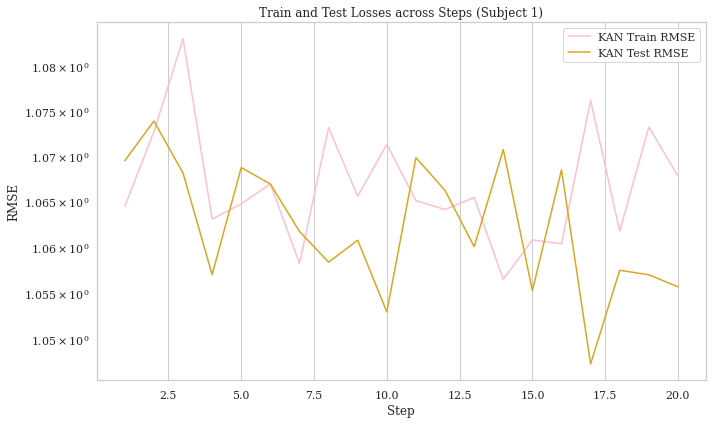

In [21]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=1):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)


In [ ]:
# MULTICLASS_Raw
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=False))
    
    df = epochs_EEG.to_data_frame().drop(columns=['time', 'epoch'])
    X = df.drop(columns=['condition']).values
    y = df.condition.values
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))


    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

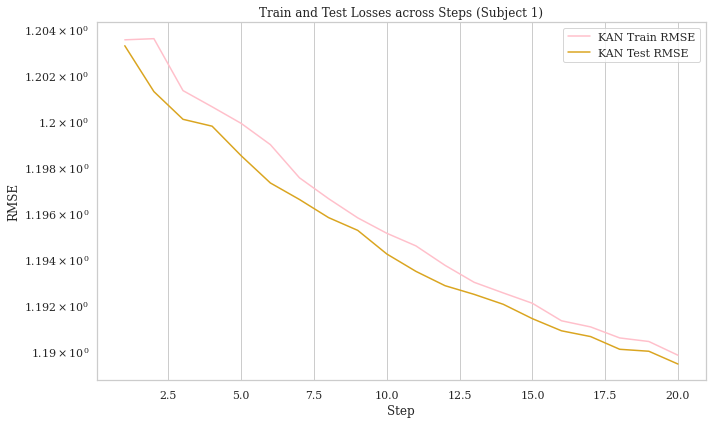

In [24]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=1):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)


In [28]:
# MULTICLASS_CSP
import time
import numpy as np
import torch
import mne
import matplotlib.pyplot as plt

metrics_KAN = {}  # Stores training/testing accuracy and loss for KAN
metrics_MLP = {}  # Stores training/testing accuracy and loss for MLP

total_train_time_KAN = 0  # Total training time for KAN
total_train_time_MLP = 0  # Total training time for MLP

subjects = [1]  # List of subjects

# Iterate over each subject
for subject in subjects:
    print(f"### Subject {subject} ###")

    # Get data for the subject
    epochs_EEG = mne.concatenate_epochs(data_EEG(subjects=[subject], multiclass=True))
    y = epochs_EEG.events[:, -1]
    X = csp.fit_transform(1e6 * epochs_EEG.get_data(), y)
    y = le.fit_transform(y)

    X = torch.from_numpy(X).double()
    y = torch.from_numpy(y).long()

    input_layer = X.shape[1]
    output_layer = len(np.unique(y))

    # Initialize models for each subject
    kan_model = KANModel(input_shape=input_layer, output_shape=output_layer, device=device)
    mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

    for param in mlp_model.parameters():
        param.data = param.data.double()

    kan_optimizer = LBFGS(kan_model.parameters(), lr=lr)
    mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe",
                          tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

    # Initialize metrics for the subject
    metrics_KAN[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}
    metrics_MLP[subject] = {'train_acc': [], 'test_acc': [], 'train_loss': [], 'test_loss': [], 'train_time': 0}

    # Cross-validation for each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"--- Fold {fold + 1} ---")

        # Split data into training and testing sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        dataset = {
            'train_input': X_train,
            'train_label': y_train,
            'test_input': X_test,
            'test_label': y_test
        }

        fold_metrics_KAN_train_loss = []
        fold_metrics_KAN_test_loss = []
        fold_metrics_KAN_train_acc = []
        fold_metrics_KAN_test_acc = []

        fold_metrics_MLP_train_loss = []
        fold_metrics_MLP_test_loss = []
        fold_metrics_MLP_train_acc = []
        fold_metrics_MLP_test_acc = []

        for epoch in range(epochs):
            print(f'###### EPOCH {epoch} ######')

            # Train KAN model
            start_time_KAN = time.time()
            results_kan = kan_model.train_model(dataset, opt="Adam", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_KAN = time.time()

            metrics_KAN[subject]['train_time'] += end_time_KAN - start_time_KAN

            fold_metrics_KAN_train_acc.append(np.mean(results_kan['train_acc']))
            fold_metrics_KAN_test_acc.append(np.mean(results_kan['test_acc']))
            fold_metrics_KAN_train_loss.append(results_kan['train_loss'])  # list of step losses
            fold_metrics_KAN_test_loss.append(results_kan['test_loss'])    # list of step losses

            # Train MLP model
            start_time_MLP = time.time()
            results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, loss_fn=loss_fn, batch=-1, lr=lr)
            end_time_MLP = time.time()

            metrics_MLP[subject]['train_time'] += end_time_MLP - start_time_MLP

            fold_metrics_MLP_train_acc.append(np.mean(results_mlp['train_acc']))
            fold_metrics_MLP_test_acc.append(np.mean(results_mlp['test_acc']))
            fold_metrics_MLP_train_loss.append(results_mlp['train_loss'])
            fold_metrics_MLP_test_loss.append(results_mlp['test_loss'])

        # Aggregate metrics per subject
        metrics_KAN[subject]['train_acc'].append(np.mean(fold_metrics_KAN_train_acc))
        metrics_KAN[subject]['test_acc'].append(np.mean(fold_metrics_KAN_test_acc))
        metrics_KAN[subject]['train_loss'].append(np.mean(fold_metrics_KAN_train_loss, axis=0))
        metrics_KAN[subject]['test_loss'].append(np.mean(fold_metrics_KAN_test_loss, axis=0))

        metrics_MLP[subject]['train_acc'].append(np.mean(fold_metrics_MLP_train_acc))
        metrics_MLP[subject]['test_acc'].append(np.mean(fold_metrics_MLP_test_acc))
        metrics_MLP[subject]['train_loss'].append(np.mean(fold_metrics_MLP_train_loss, axis=0))
        metrics_MLP[subject]['test_loss'].append(np.mean(fold_metrics_MLP_test_loss, axis=0))

    # Print final metrics
    print(f"### Subject {subject} ###")
    print(f"Training time KAN: {metrics_KAN[subject]['train_time']:.2f} seconds")
    print(f"Training time MLP: {metrics_MLP[subject]['train_time']:.2f} seconds")

    print(f"KAN Mean Training Accuracy: {np.mean(metrics_KAN[subject]['train_acc'])}")
    print(f"KAN Mean Testing Accuracy: {np.mean(metrics_KAN[subject]['test_acc'])}")
    print(f"MLP Mean Training Accuracy: {np.mean(metrics_MLP[subject]['train_acc'])}")
    print(f"MLP Mean Testing Accuracy: {np.mean(metrics_MLP[subject]['test_acc'])}")

### Subject 1 ###
--- Fold 1 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.546: 100%|█████████████| 50/50 [00:00<00:00, 105.20it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.602


train acc: 0.731 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:04<00:00, 10.23it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.593: 100%|█████████████| 50/50 [00:00<00:00, 371.95it/s, grid_size=6]


Reverting to best grid size: 5 with accuracy: 0.676


train acc: 0.745 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:04<00:00, 11.45it/s]


###### EPOCH 2 ######


train acc: 0.634 | test acc: 0.583: 100%|█████████████| 50/50 [00:00<00:00, 330.95it/s, grid_size=7]


Reverting to best grid size: 6 with accuracy: 0.653


train acc: 0.759 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:04<00:00, 10.45it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.644: 100%|█████████████| 50/50 [00:00<00:00, 229.05it/s, grid_size=8]


Reverting to best grid size: 6 with accuracy: 0.657


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:03<00:00, 16.42it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.579: 100%|█████████████| 50/50 [00:00<00:00, 179.25it/s, grid_size=8]


Reverting to best grid size: 8 with accuracy: 0.644


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.69it/s]


###### EPOCH 5 ######


train acc: 0.639 | test acc: 0.616: 100%|████████████| 50/50 [00:00<00:00, 224.66it/s, grid_size=10]


Reverting to best grid size: 10 with accuracy: 0.690


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.08it/s]


###### EPOCH 6 ######


train acc: 0.639 | test acc: 0.532: 100%|████████████| 50/50 [00:00<00:00, 309.31it/s, grid_size=12]


Reverting to best grid size: 12 with accuracy: 0.662


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.21it/s]


###### EPOCH 7 ######


train acc: 0.639 | test acc: 0.560: 100%|████████████| 50/50 [00:00<00:00, 145.70it/s, grid_size=14]


Reverting to best grid size: 13 with accuracy: 0.667


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.55it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.639: 100%|████████████| 50/50 [00:00<00:00, 307.04it/s, grid_size=15]


Reverting to best grid size: 15 with accuracy: 0.639


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.39it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.611: 100%|████████████| 50/50 [00:00<00:00, 295.69it/s, grid_size=16]


Reverting to best grid size: 15 with accuracy: 0.648


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.63it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 351.95it/s, grid_size=16]


Reverting to best grid size: 16 with accuracy: 0.634


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.22it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 162.95it/s, grid_size=17]


Reverting to best grid size: 16 with accuracy: 0.657


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.20it/s]


###### EPOCH 12 ######


train acc: 0.639 | test acc: 0.532: 100%|████████████| 50/50 [00:00<00:00, 361.78it/s, grid_size=18]


Reverting to best grid size: 17 with accuracy: 0.667


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.59it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 299.09it/s, grid_size=19]


Reverting to best grid size: 19 with accuracy: 0.648


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.26it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 238.03it/s, grid_size=21]


Reverting to best grid size: 20 with accuracy: 0.676


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.88it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.606: 100%|████████████| 50/50 [00:00<00:00, 294.56it/s, grid_size=22]


Reverting to best grid size: 21 with accuracy: 0.620


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.78it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.583: 100%|████████████| 50/50 [00:00<00:00, 117.53it/s, grid_size=23]


Reverting to best grid size: 23 with accuracy: 0.657


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.88it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.602: 100%|████████████| 50/50 [00:00<00:00, 360.41it/s, grid_size=25]


Reverting to best grid size: 25 with accuracy: 0.625


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:07<00:00,  7.10it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.574: 100%|████████████| 50/50 [00:00<00:00, 230.74it/s, grid_size=26]


Reverting to best grid size: 26 with accuracy: 0.653


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 19.74it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.556: 100%|████████████| 50/50 [00:00<00:00, 318.30it/s, grid_size=28]


Reverting to best grid size: 28 with accuracy: 0.653


train acc: 0.741 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.85it/s]


--- Fold 2 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 334.82it/s, grid_size=30]


Reverting to best grid size: 30 with accuracy: 0.722


train acc: 0.731 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:03<00:00, 12.60it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.634: 100%|████████████| 50/50 [00:00<00:00, 186.31it/s, grid_size=31]


Reverting to best grid size: 31 with accuracy: 0.755


train acc: 0.727 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:04<00:00, 10.26it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 299.96it/s, grid_size=33]


Reverting to best grid size: 33 with accuracy: 0.745


train acc: 0.727 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:04<00:00, 12.43it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.606: 100%|████████████| 50/50 [00:00<00:00, 317.30it/s, grid_size=34]


Reverting to best grid size: 34 with accuracy: 0.736


train acc: 0.727 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.66it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.639: 100%|███████████████████████████| 50/50 [00:02<00:00, 21.44it/s]


Reverting to best grid size: 34 with accuracy: 0.722


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:04<00:00, 12.21it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.704: 100%|█████████████| 50/50 [00:01<00:00, 46.86it/s, grid_size=36]


Reverting to best grid size: 36 with accuracy: 0.727


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.39it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.648: 100%|████████████| 50/50 [00:00<00:00, 302.07it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.759


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.94it/s]


###### EPOCH 7 ######


train acc: 0.625 | test acc: 0.653: 100%|█████████████| 50/50 [00:00<00:00, 75.30it/s, grid_size=38]


Reverting to best grid size: 37 with accuracy: 0.736


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.94it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 307.84it/s, grid_size=38]


Reverting to best grid size: 38 with accuracy: 0.727


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.94it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.671: 100%|████████████| 50/50 [00:00<00:00, 309.17it/s, grid_size=39]


Reverting to best grid size: 39 with accuracy: 0.741


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.41it/s]


###### EPOCH 10 ######


train acc: 0.630 | test acc: 0.699: 100%|████████████| 50/50 [00:00<00:00, 210.08it/s, grid_size=42]


Reverting to best grid size: 40 with accuracy: 0.736


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:03<00:00, 14.27it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 121.27it/s, grid_size=41]


Reverting to best grid size: 40 with accuracy: 0.745


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.53it/s]


###### EPOCH 12 ######


train acc: 0.630 | test acc: 0.630: 100%|████████████| 50/50 [00:00<00:00, 234.76it/s, grid_size=43]


Reverting to best grid size: 40 with accuracy: 0.750


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.73it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.644: 100%|████████████| 50/50 [00:00<00:00, 333.28it/s, grid_size=41]


Reverting to best grid size: 41 with accuracy: 0.736


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.36it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 149.95it/s, grid_size=44]


Reverting to best grid size: 42 with accuracy: 0.750


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.56it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.704: 100%|████████████| 50/50 [00:00<00:00, 255.65it/s, grid_size=43]


Reverting to best grid size: 43 with accuracy: 0.755


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.55it/s]


###### EPOCH 16 ######


train acc: 0.630 | test acc: 0.639: 100%|█████████████| 50/50 [00:00<00:00, 90.10it/s, grid_size=46]


Reverting to best grid size: 44 with accuracy: 0.745


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.77it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.662: 100%|████████████| 50/50 [00:00<00:00, 207.27it/s, grid_size=45]


Reverting to best grid size: 45 with accuracy: 0.731


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:05<00:00,  9.91it/s]


###### EPOCH 18 ######


train acc: 0.630 | test acc: 0.694: 100%|█████████████| 50/50 [00:00<00:00, 79.93it/s, grid_size=47]


Reverting to best grid size: 47 with accuracy: 0.731


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.01it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 192.31it/s]


Reverting to best grid size: 47 with accuracy: 0.769


train acc: 0.736 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.65it/s]


--- Fold 3 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.440: 100%|████████████| 50/50 [00:00<00:00, 316.41it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.611


train acc: 0.736 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:04<00:00, 11.22it/s]


###### EPOCH 1 ######


train acc: 0.644 | test acc: 0.495: 100%|██████████████████████████| 50/50 [00:00<00:00, 331.58it/s]


Reverting to best grid size: 47 with accuracy: 0.597


train acc: 0.731 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:06<00:00,  7.29it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.468: 100%|████████████| 50/50 [00:00<00:00, 267.62it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.630


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:06<00:00,  8.28it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 288.27it/s]


Reverting to best grid size: 47 with accuracy: 0.634


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:04<00:00, 10.18it/s]


###### EPOCH 4 ######


train acc: 0.634 | test acc: 0.505: 100%|███████████████████████████| 50/50 [00:00<00:00, 86.15it/s]


Reverting to best grid size: 47 with accuracy: 0.611


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:06<00:00,  8.14it/s]


###### EPOCH 5 ######


train acc: 0.634 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 129.21it/s, grid_size=49]


Reverting to best grid size: 47 with accuracy: 0.611


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.44it/s]


###### EPOCH 6 ######


train acc: 0.639 | test acc: 0.477: 100%|████████████| 50/50 [00:00<00:00, 182.49it/s, grid_size=49]


Reverting to best grid size: 47 with accuracy: 0.579


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:04<00:00, 12.00it/s]


###### EPOCH 7 ######


train acc: 0.639 | test acc: 0.509: 100%|████████████| 50/50 [00:00<00:00, 150.48it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.574


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.10it/s]


###### EPOCH 8 ######


train acc: 0.639 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 360.28it/s]


Reverting to best grid size: 47 with accuracy: 0.583


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.42it/s]


###### EPOCH 9 ######


train acc: 0.648 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 230.20it/s, grid_size=50]


Reverting to best grid size: 47 with accuracy: 0.630


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.21it/s]


###### EPOCH 10 ######


train acc: 0.648 | test acc: 0.523: 100%|████████████| 50/50 [00:00<00:00, 254.55it/s, grid_size=49]


Reverting to best grid size: 47 with accuracy: 0.588


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.34it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.528: 100%|████████████| 50/50 [00:00<00:00, 301.09it/s, grid_size=48]


Reverting to best grid size: 47 with accuracy: 0.620


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.35it/s]


###### EPOCH 12 ######


train acc: 0.648 | test acc: 0.565: 100%|████████████| 50/50 [00:00<00:00, 203.40it/s, grid_size=49]


Reverting to best grid size: 49 with accuracy: 0.565


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.46it/s]


###### EPOCH 13 ######


train acc: 0.644 | test acc: 0.514: 100%|████████████| 50/50 [00:00<00:00, 251.43it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.611


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.59it/s]


###### EPOCH 14 ######


train acc: 0.648 | test acc: 0.477: 100%|████████████| 50/50 [00:00<00:00, 241.14it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.611


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.83it/s]


###### EPOCH 15 ######


train acc: 0.644 | test acc: 0.542: 100%|████████████| 50/50 [00:00<00:00, 238.31it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.579


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.64it/s]


###### EPOCH 16 ######


train acc: 0.648 | test acc: 0.472: 100%|████████████| 50/50 [00:00<00:00, 352.88it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.606


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.00it/s]


###### EPOCH 17 ######


train acc: 0.644 | test acc: 0.500: 100%|████████████| 50/50 [00:00<00:00, 254.16it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.639


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:03<00:00, 16.12it/s]


###### EPOCH 18 ######


train acc: 0.648 | test acc: 0.412: 100%|████████████| 50/50 [00:00<00:00, 242.63it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.569


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.05it/s]


###### EPOCH 19 ######


train acc: 0.648 | test acc: 0.509: 100%|████████████| 50/50 [00:00<00:00, 166.66it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.583


train acc: 0.736 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.93it/s]


--- Fold 4 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 326.67it/s]


Reverting to best grid size: 49 with accuracy: 0.769


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:04<00:00, 11.25it/s]


###### EPOCH 1 ######


train acc: 0.653 | test acc: 0.681: 100%|████████████| 50/50 [00:00<00:00, 360.21it/s, grid_size=50]


Reverting to best grid size: 49 with accuracy: 0.745


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:03<00:00, 14.98it/s]


###### EPOCH 2 ######


train acc: 0.648 | test acc: 0.620: 100%|████████████| 50/50 [00:00<00:00, 179.51it/s, grid_size=50]


Reverting to best grid size: 50 with accuracy: 0.750


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.63it/s]


###### EPOCH 3 ######


train acc: 0.644 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 310.41it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:05<00:00,  8.54it/s]


###### EPOCH 4 ######


train acc: 0.648 | test acc: 0.653: 100%|██████████████████████████| 50/50 [00:00<00:00, 215.96it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:03<00:00, 15.89it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.694: 100%|██████████████████████████| 50/50 [00:00<00:00, 106.88it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:04<00:00, 11.49it/s]


###### EPOCH 6 ######


train acc: 0.648 | test acc: 0.648: 100%|███████████████████████████| 50/50 [00:00<00:00, 76.09it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:08<00:00,  5.94it/s]


###### EPOCH 7 ######


train acc: 0.653 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 158.73it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.40it/s]


###### EPOCH 8 ######


train acc: 0.648 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 291.79it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.77it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.667: 100%|███████████████████████████| 50/50 [00:00<00:00, 66.95it/s]


Reverting to best grid size: 50 with accuracy: 0.745


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.99it/s]


###### EPOCH 10 ######


train acc: 0.648 | test acc: 0.639: 100%|███████████████████████████| 50/50 [00:00<00:00, 74.42it/s]


Reverting to best grid size: 50 with accuracy: 0.745


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:03<00:00, 16.33it/s]


###### EPOCH 11 ######


train acc: 0.648 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 213.30it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.20it/s]


###### EPOCH 12 ######


train acc: 0.653 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 155.23it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 17.31it/s]


###### EPOCH 13 ######


train acc: 0.648 | test acc: 0.745: 100%|███████████████████████████| 50/50 [00:00<00:00, 70.15it/s]


Reverting to best grid size: 50 with accuracy: 0.745


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.87it/s]


###### EPOCH 14 ######


train acc: 0.648 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 143.90it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.39it/s]


###### EPOCH 15 ######


train acc: 0.648 | test acc: 0.681: 100%|███████████████████████████| 50/50 [00:00<00:00, 63.48it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.77it/s]


###### EPOCH 16 ######


train acc: 0.648 | test acc: 0.648: 100%|██████████████████████████| 50/50 [00:00<00:00, 158.89it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.49it/s]


###### EPOCH 17 ######


train acc: 0.648 | test acc: 0.690: 100%|██████████████████████████| 50/50 [00:00<00:00, 171.11it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:06<00:00,  7.76it/s]


###### EPOCH 18 ######


train acc: 0.644 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 355.87it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.25it/s]


###### EPOCH 19 ######


train acc: 0.644 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 276.57it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.755 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:03<00:00, 14.69it/s]


--- Fold 5 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 287.47it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.741 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:07<00:00,  6.95it/s]


###### EPOCH 1 ######


train acc: 0.639 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 246.17it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.736 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.64it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.620: 100%|███████████████████████████| 50/50 [00:00<00:00, 65.97it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.741 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:05<00:00,  9.86it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 219.43it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.741 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.82it/s]


###### EPOCH 4 ######


train acc: 0.630 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 254.11it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.54it/s]


###### EPOCH 5 ######


train acc: 0.630 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 373.01it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.21it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 356.49it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.79it/s]


###### EPOCH 7 ######


train acc: 0.630 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 373.05it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.09it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 154.57it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.43it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.556: 100%|██████████████████████████| 50/50 [00:00<00:00, 126.44it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 17.33it/s]


###### EPOCH 10 ######


train acc: 0.634 | test acc: 0.542: 100%|███████████████████████████| 50/50 [00:02<00:00, 24.47it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:03<00:00, 15.89it/s]


###### EPOCH 11 ######


train acc: 0.634 | test acc: 0.639: 100%|██████████████████████████| 50/50 [00:00<00:00, 122.77it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:03<00:00, 15.41it/s]


###### EPOCH 12 ######


train acc: 0.634 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 254.06it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 20.40it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 301.64it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:04<00:00, 11.75it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 133.63it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.92it/s]


###### EPOCH 15 ######


train acc: 0.630 | test acc: 0.606: 100%|███████████████████████████| 50/50 [00:00<00:00, 75.05it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:02<00:00, 17.39it/s]


###### EPOCH 16 ######


train acc: 0.634 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.18it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.79it/s]


###### EPOCH 17 ######


train acc: 0.630 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 383.19it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.90it/s]


###### EPOCH 18 ######


train acc: 0.634 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 381.75it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.79it/s]


###### EPOCH 19 ######


train acc: 0.630 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.89it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.745 | test acc: 0.458 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.10it/s]


--- Fold 6 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.620: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.41it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.00it/s]


###### EPOCH 1 ######


train acc: 0.639 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.54it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.55it/s]


###### EPOCH 2 ######


train acc: 0.634 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.76it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.98it/s]


###### EPOCH 3 ######


train acc: 0.634 | test acc: 0.625: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.76it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.00it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.43it/s]


Reverting to best grid size: 50 with accuracy: 0.667


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.84it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.593: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.95it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.75it/s]


###### EPOCH 6 ######


train acc: 0.634 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.55it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.78it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.50it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.69it/s]


###### EPOCH 8 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.67it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.71it/s]


###### EPOCH 9 ######


train acc: 0.644 | test acc: 0.505: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.01it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.09it/s]


###### EPOCH 10 ######


train acc: 0.639 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.91it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.10it/s]


###### EPOCH 11 ######


train acc: 0.644 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.91it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.12it/s]


###### EPOCH 12 ######


train acc: 0.639 | test acc: 0.662: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.60it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.13it/s]


###### EPOCH 13 ######


train acc: 0.634 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.16it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.11it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.19it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.03it/s]


###### EPOCH 15 ######


train acc: 0.634 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.24it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.11it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.86it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.20it/s]


###### EPOCH 17 ######


train acc: 0.634 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.01it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.18it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.80it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.15it/s]


###### EPOCH 19 ######


train acc: 0.634 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.50it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.755 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.11it/s]


--- Fold 7 ---
###### EPOCH 0 ######


train acc: 0.620 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.35it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.97it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.579: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.33it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.66it/s]


###### EPOCH 2 ######


train acc: 0.625 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.40it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.98it/s]


###### EPOCH 3 ######


train acc: 0.616 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.52it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.21it/s]


###### EPOCH 4 ######


train acc: 0.611 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 384.31it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.77it/s]


###### EPOCH 5 ######


train acc: 0.616 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.72it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.04it/s]


###### EPOCH 6 ######


train acc: 0.611 | test acc: 0.500: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.41it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.15it/s]


###### EPOCH 7 ######


train acc: 0.616 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.25it/s]


Reverting to best grid size: 50 with accuracy: 0.755


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.57it/s]


###### EPOCH 8 ######


train acc: 0.611 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 388.22it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 99.50it/s]


###### EPOCH 9 ######


train acc: 0.616 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.06it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.52it/s]


###### EPOCH 10 ######


train acc: 0.611 | test acc: 0.519: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.99it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.57it/s]


###### EPOCH 11 ######


train acc: 0.616 | test acc: 0.602: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.13it/s]


Reverting to best grid size: 50 with accuracy: 0.731


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.80it/s]


###### EPOCH 12 ######


train acc: 0.611 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.11it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.91it/s]


###### EPOCH 13 ######


train acc: 0.616 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.71it/s]


Reverting to best grid size: 50 with accuracy: 0.759


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.34it/s]


###### EPOCH 14 ######


train acc: 0.616 | test acc: 0.569: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.47it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.84it/s]


###### EPOCH 15 ######


train acc: 0.616 | test acc: 0.481: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.17it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.57it/s]


###### EPOCH 16 ######


train acc: 0.616 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.80it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.33it/s]


###### EPOCH 17 ######


train acc: 0.616 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.28it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.63it/s]


###### EPOCH 18 ######


train acc: 0.616 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.93it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.52it/s]


###### EPOCH 19 ######


train acc: 0.616 | test acc: 0.523: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.95it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.755 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.91it/s]


--- Fold 8 ---
###### EPOCH 0 ######


train acc: 0.639 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 395.37it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.91it/s]


###### EPOCH 1 ######


train acc: 0.639 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.74it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.778 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.97it/s]


###### EPOCH 2 ######


train acc: 0.639 | test acc: 0.509: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.68it/s]


Reverting to best grid size: 50 with accuracy: 0.648


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 21.77it/s]


###### EPOCH 3 ######


train acc: 0.639 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 386.18it/s]


Reverting to best grid size: 50 with accuracy: 0.671


train acc: 0.773 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.00it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.71it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.778 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.94it/s]


###### EPOCH 5 ######


train acc: 0.639 | test acc: 0.472: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.43it/s]


Reverting to best grid size: 50 with accuracy: 0.625


train acc: 0.778 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.03it/s]


###### EPOCH 6 ######


train acc: 0.639 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.72it/s]


Reverting to best grid size: 50 with accuracy: 0.662


train acc: 0.769 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.97it/s]


###### EPOCH 7 ######


train acc: 0.639 | test acc: 0.514: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.92it/s]


Reverting to best grid size: 50 with accuracy: 0.657


train acc: 0.769 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.09it/s]


###### EPOCH 8 ######


train acc: 0.639 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 387.08it/s]


Reverting to best grid size: 50 with accuracy: 0.634


train acc: 0.769 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 64.01it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.93it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.769 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 68.28it/s]


###### EPOCH 10 ######


train acc: 0.639 | test acc: 0.551: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.43it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:01<00:00, 26.73it/s]


###### EPOCH 11 ######


train acc: 0.639 | test acc: 0.560: 100%|██████████████████████████| 50/50 [00:00<00:00, 390.00it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.91it/s]


###### EPOCH 12 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 385.82it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.88it/s]


###### EPOCH 13 ######


train acc: 0.639 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 371.30it/s]


Reverting to best grid size: 50 with accuracy: 0.653


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.56it/s]


###### EPOCH 14 ######


train acc: 0.639 | test acc: 0.546: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.35it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.55it/s]


###### EPOCH 15 ######


train acc: 0.639 | test acc: 0.528: 100%|██████████████████████████| 50/50 [00:00<00:00, 381.95it/s]


Reverting to best grid size: 50 with accuracy: 0.620


train acc: 0.764 | test acc: 0.542 : 100%|█████████████████████████| 50/50 [00:00<00:00, 163.23it/s]


###### EPOCH 16 ######


train acc: 0.639 | test acc: 0.565: 100%|██████████████████████████| 50/50 [00:00<00:00, 401.11it/s]


Reverting to best grid size: 50 with accuracy: 0.616


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.91it/s]


###### EPOCH 17 ######


train acc: 0.639 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.94it/s]


Reverting to best grid size: 50 with accuracy: 0.639


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.80it/s]


###### EPOCH 18 ######


train acc: 0.639 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.87it/s]


Reverting to best grid size: 50 with accuracy: 0.611


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 69.61it/s]


###### EPOCH 19 ######


train acc: 0.639 | test acc: 0.532: 100%|██████████████████████████| 50/50 [00:00<00:00, 303.28it/s]


Reverting to best grid size: 50 with accuracy: 0.644


train acc: 0.764 | test acc: 0.542 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.06it/s]


--- Fold 9 ---
###### EPOCH 0 ######


train acc: 0.644 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.03it/s]


Reverting to best grid size: 50 with accuracy: 0.713


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.05it/s]


###### EPOCH 1 ######


train acc: 0.644 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.86it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.42it/s]


###### EPOCH 2 ######


train acc: 0.639 | test acc: 0.634: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.84it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.54it/s]


###### EPOCH 3 ######


train acc: 0.644 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 366.83it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.74it/s]


###### EPOCH 4 ######


train acc: 0.639 | test acc: 0.583: 100%|██████████████████████████| 50/50 [00:00<00:00, 372.62it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 65.78it/s]


###### EPOCH 5 ######


train acc: 0.644 | test acc: 0.671: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.88it/s]


Reverting to best grid size: 50 with accuracy: 0.694


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.79it/s]


###### EPOCH 6 ######


train acc: 0.644 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.50it/s]


Reverting to best grid size: 50 with accuracy: 0.722


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.87it/s]


###### EPOCH 7 ######


train acc: 0.644 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.43it/s]


Reverting to best grid size: 50 with accuracy: 0.690


train acc: 0.773 | test acc: 0.583 : 100%|█████████████████████████| 50/50 [00:00<00:00, 164.45it/s]


###### EPOCH 8 ######


train acc: 0.644 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.85it/s]


Reverting to best grid size: 50 with accuracy: 0.676


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.63it/s]


###### EPOCH 9 ######


train acc: 0.639 | test acc: 0.616: 100%|██████████████████████████| 50/50 [00:00<00:00, 397.32it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.72it/s]


###### EPOCH 10 ######


train acc: 0.644 | test acc: 0.574: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.37it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.51it/s]


###### EPOCH 11 ######


train acc: 0.639 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.03it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.73it/s]


###### EPOCH 12 ######


train acc: 0.644 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.43it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.75it/s]


###### EPOCH 13 ######


train acc: 0.639 | test acc: 0.597: 100%|██████████████████████████| 50/50 [00:00<00:00, 391.40it/s]


Reverting to best grid size: 50 with accuracy: 0.685


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.79it/s]


###### EPOCH 14 ######


train acc: 0.644 | test acc: 0.630: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.91it/s]


Reverting to best grid size: 50 with accuracy: 0.681


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.74it/s]


###### EPOCH 15 ######


train acc: 0.639 | test acc: 0.667: 100%|██████████████████████████| 50/50 [00:00<00:00, 394.67it/s]


Reverting to best grid size: 50 with accuracy: 0.708


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.57it/s]


###### EPOCH 16 ######


train acc: 0.644 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 393.37it/s]


Reverting to best grid size: 50 with accuracy: 0.699


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.84it/s]


###### EPOCH 17 ######


train acc: 0.639 | test acc: 0.611: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.24it/s]


Reverting to best grid size: 50 with accuracy: 0.718


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.96it/s]


###### EPOCH 18 ######


train acc: 0.644 | test acc: 0.588: 100%|██████████████████████████| 50/50 [00:00<00:00, 361.82it/s]


Reverting to best grid size: 50 with accuracy: 0.736


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 60.74it/s]


###### EPOCH 19 ######


train acc: 0.639 | test acc: 0.606: 100%|██████████████████████████| 50/50 [00:00<00:00, 357.35it/s]


Reverting to best grid size: 50 with accuracy: 0.704


train acc: 0.773 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.90it/s]


--- Fold 10 ---
###### EPOCH 0 ######


train acc: 0.630 | test acc: 0.681: 100%|██████████████████████████| 50/50 [00:00<00:00, 406.66it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.755 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.90it/s]


###### EPOCH 1 ######


train acc: 0.630 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 414.22it/s]


Reverting to best grid size: 50 with accuracy: 0.764


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:02<00:00, 23.76it/s]


###### EPOCH 2 ######


train acc: 0.630 | test acc: 0.778: 100%|██████████████████████████| 50/50 [00:00<00:00, 410.00it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.24it/s]


###### EPOCH 3 ######


train acc: 0.630 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.26it/s]


Reverting to best grid size: 50 with accuracy: 0.815


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.92it/s]


###### EPOCH 4 ######


train acc: 0.625 | test acc: 0.685: 100%|██████████████████████████| 50/50 [00:00<00:00, 360.70it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.64it/s]


###### EPOCH 5 ######


train acc: 0.625 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 382.78it/s]


Reverting to best grid size: 50 with accuracy: 0.773


train acc: 0.755 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.61it/s]


###### EPOCH 6 ######


train acc: 0.630 | test acc: 0.755: 100%|██████████████████████████| 50/50 [00:00<00:00, 413.74it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.59it/s]


###### EPOCH 7 ######


train acc: 0.620 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.18it/s]


Reverting to best grid size: 50 with accuracy: 0.819


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 85.00it/s]


###### EPOCH 8 ######


train acc: 0.630 | test acc: 0.713: 100%|██████████████████████████| 50/50 [00:00<00:00, 412.15it/s]


Reverting to best grid size: 50 with accuracy: 0.824


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 70.84it/s]


###### EPOCH 9 ######


train acc: 0.630 | test acc: 0.644: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.67it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.10it/s]


###### EPOCH 10 ######


train acc: 0.630 | test acc: 0.759: 100%|██████████████████████████| 50/50 [00:00<00:00, 409.41it/s]


Reverting to best grid size: 50 with accuracy: 0.810


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 76.51it/s]


###### EPOCH 11 ######


train acc: 0.630 | test acc: 0.704: 100%|██████████████████████████| 50/50 [00:00<00:00, 404.77it/s]


Reverting to best grid size: 50 with accuracy: 0.778


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 71.28it/s]


###### EPOCH 12 ######


train acc: 0.630 | test acc: 0.708: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.82it/s]


Reverting to best grid size: 50 with accuracy: 0.782


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 67.02it/s]


###### EPOCH 13 ######


train acc: 0.630 | test acc: 0.676: 100%|██████████████████████████| 50/50 [00:00<00:00, 411.42it/s]


Reverting to best grid size: 50 with accuracy: 0.769


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 63.27it/s]


###### EPOCH 14 ######


train acc: 0.630 | test acc: 0.657: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.12it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 61.92it/s]


###### EPOCH 15 ######


train acc: 0.630 | test acc: 0.731: 100%|██████████████████████████| 50/50 [00:00<00:00, 389.38it/s]


Reverting to best grid size: 50 with accuracy: 0.806


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.19it/s]


###### EPOCH 16 ######


train acc: 0.630 | test acc: 0.741: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.92it/s]


Reverting to best grid size: 50 with accuracy: 0.810


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.00it/s]


###### EPOCH 17 ######


train acc: 0.630 | test acc: 0.727: 100%|██████████████████████████| 50/50 [00:00<00:00, 392.01it/s]


Reverting to best grid size: 50 with accuracy: 0.796


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.00it/s]


###### EPOCH 18 ######


train acc: 0.630 | test acc: 0.745: 100%|██████████████████████████| 50/50 [00:00<00:00, 396.52it/s]


Reverting to best grid size: 50 with accuracy: 0.801


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.83it/s]


###### EPOCH 19 ######


train acc: 0.630 | test acc: 0.699: 100%|██████████████████████████| 50/50 [00:00<00:00, 360.50it/s]


Reverting to best grid size: 50 with accuracy: 0.792


train acc: 0.755 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.25it/s]

### Subject 1 ###
Training time KAN: 45.39 seconds
Training time MLP: 364.31 seconds
KAN Mean Training Accuracy: 0.6333268880844116
KAN Mean Testing Accuracy: 0.594703733921051
MLP Mean Training Accuracy: 0.7511088848114014
MLP Mean Testing Accuracy: 0.5460250377655029


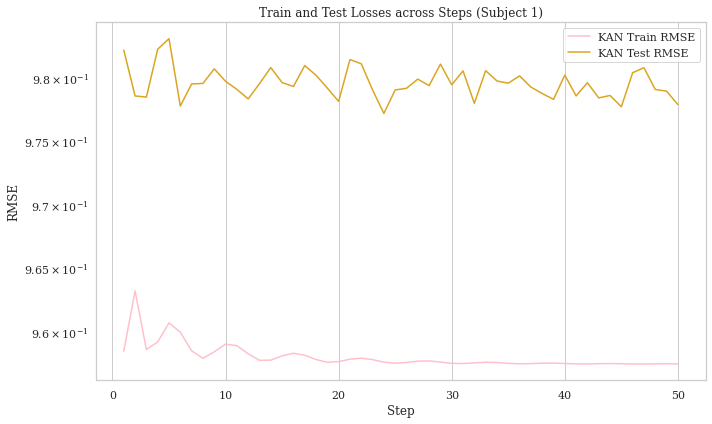

In [29]:
def plot_rmse_vs_steps(metrics, model_name='KAN', subject=2):
    try:
        train_loss_all_folds = metrics[subject]['train_loss']
        test_loss_all_folds = metrics[subject]['test_loss']

        if isinstance(train_loss_all_folds[0], (float, np.float64)):
            print(f"[Warning] RMSE per step not available for Subject {subject}. Skipping plot.")
            return

        train_rmse_per_step = np.mean([np.sqrt(losses) for losses in train_loss_all_folds], axis=0)
        test_rmse_per_step = np.mean([np.sqrt(losses) for losses in test_loss_all_folds], axis=0)

        steps_range = np.arange(1, len(train_rmse_per_step) + 1)

        plt.figure(figsize=(10, 6))
        plt.plot(steps_range, train_rmse_per_step, label=f'{model_name} Train RMSE', color='pink')
        plt.plot(steps_range, test_rmse_per_step, label=f'{model_name} Test RMSE', color='goldenrod')
        plt.xlabel('Step')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Optional for better visualization
        plt.title(f'Train and Test Losses across Steps (Subject {subject})')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[Error in RMSE Plot for Subject {subject}] {e}")

# Call the plotting function
for s in subjects:
    plot_rmse_vs_steps(metrics_KAN, model_name='KAN', subject=s)
